In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
first_run = False

if 'google.colab' in str(get_ipython()):
  print("Running in colab...")
  
  !pip install h2o

  from google.colab import drive
  drive.mount('/content/drive')

  train_all_features = '/content/drive/MyDrive/Repasse Gui/dataset_balanced/all questions/df_auto_balanced_labeled-4C.csv'
  validation_dataset_path = '/content/drive/MyDrive/Repasse Gui/dataset_anonymized/all_features_validation.csv'
  path_models = "/content/drive/MyDrive/Repasse Gui/models_H2O"
else:
  if first_run:
    !pip install h2o
    !pip install pandas
    !pip install sklearn
    !pip install matplotlib
  
  print("Running locally...")
  
  train_all_features = f"/home/gui_sales/Desktop/czrm/dataset_balanced/df_auto_balanced_labeled-4C.csv"
  path_models = f"/home/gui_sales/Desktop/czrm/models_H2O"

Running in colab...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.5 MB 43 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541401 sha256=07c9cf857200789006fb3ae0b7fc84a3e1d96082e0041640e15c4c5b06f6fd4c
  Stored in directory: /root/.cache/pip/wheels/27/c0/36/708db83f33c19ac70a7fbceea2fc175485732d84aeebf0c69e
Successfully built h2o
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9n60enrf
  JVM stdout: /tmp/tmp9n60enrf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9n60enrf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_waw20o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### List of indexes for selected features from model selections

In [ ]:
df = h2o.import_file(train_all_features, header=0)
df = df.drop([0])
df["ia level"] = df["ia level"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
feat_dict = dict()
idx = 0
for feat in df.columns:
    feat_dict.update({idx:feat})
    idx += 1

feat_dict

{0: 'Nos últimos 3 meses o(a) Sr(a) teve a preocupação de que a comida na sua casa acabasse antes que tivesse condição de comprar, receber ou produzir mais comida?',
 1: 'Nos últimos 3 meses a comida acabou antes que o(a) Sr(a) tivesse dinheiro para comprar mais?',
 2: 'Nos últimos 3 meses, o(a) Sr(a) alguma vez comeu menos do que achou que devia porque não havia dinheiro suficiente para comprar comida?',
 3: 'Nos últimos 3 meses, o(a) Sr(a) ficou sem dinheiro para ter uma alimentação saudável e variada?',
 4: 'Nos últimos 3 meses, o(a) Sr(a) ou algum adulto em sua casa diminuiu, alguma vez, a quantidade de alimentos nas refeições, ou pulou refeições, porque não havia dinheiro suficiente para comprar a comida?',
 5: 'Você acha que após a COVID houve uma mudança na disponibilidade de alimentos para a sua família?',
 6: 'Você cria animais que são utilizados para consumo da sua família?',
 7: 'Você planta alimentos que são utilizados para consumo da sua família?',
 8: 'Atualmente, alguém 

In [ ]:
def get_accuracy(model, test):
    preds = model.predict(test).as_data_frame(use_pandas=True)
    y_hat = preds["predict"]
    y = test["ia level"].as_data_frame(use_pandas=True)
    y = y["ia level"]

    hits = 0
    for prediction, target in zip(y_hat, y):
        if prediction == target:
            hits += 1

    return hits/len(y)

In [ ]:
def get_f1(model, test):
    preds = model.predict(test).as_data_frame(use_pandas=True)
    y_hat = preds["predict"]
    y = test["ia level"].as_data_frame(use_pandas=True)
    y = y["ia level"]

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for prediction, target in zip(y_hat, y):
        if prediction == 'grave' and target == 'grave':
            tp += 1 
        if prediction == 'grave' and target == 'não grave':
            fp += 1
        if prediction == 'não grave' and target == 'grave':
            fn += 1
        if prediction == 'grave' and target == 'não grave':
            fp += 1

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*((precision*recall)/(precision+recall))

    print('Precision:', precision)
    print('Recall:', recall)

    return f1_score

In [ ]:
best_accuracy = 0
best_f1 = 0
best_model = None
best_feature_set = None

In [ ]:
response_col = "ia level"

def apply_autoML_for(training):
    aml = H2OAutoML(max_runtime_secs=0, seed=42, nfolds=10)
    display(training)
    aml.train(y=response_col, training_frame=training)

    aml.explain()
    return aml

# Teste

In [ ]:
SFM_sgd_classifier = [9, 10, 13, 25]

df_SFM_sgd_classifier = df[SFM_sgd_classifier]


feature_combinations = {
    'df_SFM_sgd_classifier' : df[SFM_sgd_classifier]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)
    f1 = get_f1(auto_ml.leader, test)

    if f1 > best_f1:
        best_f1 = f1
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-f1:{f1}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has f1: {f1}"))
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model selected by f1"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_sgd_classifier

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",creas,ia level
0,0.285479,0,moderada
0,0.330033,0,moderada
0,0.412541,0,sem ia
0.166667,0.130333,0,leve
0.166667,0.806392,0,sem ia
0,0.387917,0,leve
0.166667,0.412541,0,moderada
0.166667,0.532946,0,sem ia
0,0.412541,0,moderada
0,0.412541,0,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFM_sgd_classifier-StackedEnsemble_AllModels_3_AutoML_1_20221108_150730-acc:0.42381193979367493

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SFM_sgd_classifier-StackedEnsemble_AllModels_3_AutoML_1_20221108_150730-acc:0.42381193979367493

### df_SFM_sgd_classifier has accuracy: 0.42381193979367493

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221108_150730

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.45325151518268975
RMSE: 0.6732395674518022
LogLoss: 1.1727650093330506
Null degrees of freedom: 9938
Residual degrees of freedom: 9734
Null deviance: 27544.34414531462
Residual deviance: 23312.22285552238
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
21       355     1574        441       0.991217  2,370 / 2,391
7        740     791         1040      0.712956  1,838 / 2,578
27       7       2254        101       0.056509  135 / 2,389
9        558     756         1258      0.512592  1,323 / 2,581
64       1660    5375        2840      0.570077  5,666 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.429923
2    0.755307
3    0.926451
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.46392159393950466
RMSE: 0.6811179001755163
LogLoss: 1.1980412337257584
Null degrees of freedom: 53214
Residual degrees of freedom: 53032
Null deviance: 147519.46402641703
Residual deviance: 127507.52850543248
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  ---------------
215      3121    8604        1047      0.983445   12,772 / 12,987
144      6809    4358        2309      0.500073   6,811 / 13,620
273      246     11925       543       0.0817741  1,062 / 12,987
118      5944    4251        3308      0.75714    10,313 / 13,621
750      16120   29138       7207      0.581753   30,958 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.418247
2    0.742986
3    0.916245
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.418237  0.00488306  0.415358      0.417712      0.414721      0.416012      0.424169      0.416326      0.429829      0.416682      0.415069      0.416493
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.581763  0.00488306  0.584642      0.582288      0.585279      0.583988      0.575831      0.583674      0.570171      0.583318      0.584931      0.583507
err_count                3095.8    38.921      3091          3064          3133          3122          3083          3139          3043          3154          3051          3078
logloss                  1.19807   0.00585645  1.19484       1.20474       1.20422       1.20267       1.19284       1.1972        1.18921       1.19194       1.20517       1.19789
max_per_class_error      0.983454  0.0

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
preds = auto_ml.leader.predict(test).as_data_frame(use_pandas=True)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
y_hat = preds["predict"]

In [ ]:
y = test["ia level"].as_data_frame(use_pandas=True)
y = y["ia level"]

In [ ]:
y

0       moderada
1       moderada
2       moderada
3         sem ia
4          grave
          ...   
5908    moderada
5909        leve
5910       grave
5911      sem ia
5912        leve
Name: ia level, Length: 5913, dtype: object

# Execução Select From Model (SFM)

In [ ]:
SFM_sgd_classifier = [9, 10, 13, 25]
SFM_sgd_one_class_svm = [10, 11, 14, 16, 17, 18, 19, 20, 24, 25]
df_SFM_sgd_classifier = df[SFM_sgd_classifier]
df_SFM_sgd_one_class_svm = df[SFM_sgd_one_class_svm]

feature_combinations = {
    'df_SFM_sgd_classifier' : df[SFM_sgd_classifier],
    'df_SFM_sgd_one_class_svm' : df[SFM_sgd_one_class_svm]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_sgd_classifier

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",creas,ia level
0,0.577558,0,grave
0,0.412541,0,leve
0,0.49505,0,moderada
0,0.660066,0,leve
0,0.432343,0,leve
0,0.412541,0,moderada
0,0.363861,0,moderada
0,0.437308,0,sem ia
0.231115,0.723877,0,leve
0,0.249175,0,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFM_sgd_classifier-StackedEnsemble_AllModels_3_AutoML_1_20221020_182810-acc:0.41772365973279213

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFM_sgd_classifier-StackedEnsemble_AllModels_3_AutoML_1_20221020_182810-acc:0.41772365973279213

### df_SFM_sgd_classifier has accuracy: 0.41772365973279213

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221020_182810

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4545738558048676
RMSE: 0.6742209250719438
LogLoss: 1.1777882542141662
Null degrees of freedom: 9938
Residual degrees of freedom: 9629
Null deviance: 27554.91553780429
Residual deviance: 23412.074917269194
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
11       507     1642        288       0.995507   2.437 / 2.448
3        834     800         873       0.667729   1.676 / 2.510
4        15      2329        95        0.0466639  114 / 2.443
4        702     772         1060      0.582348   1.478 / 2.538
22       2058    5543        2316      0.574001   5.705 / 9.939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.425999
2    0.752792
3    0.923433
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.46090578601389925
RMSE: 0.678900424225747
LogLoss: 1.1921648086129175
Null degrees of freedom: 53214
Residual degrees of freedom: 52953
Null deviance: 147522.04276412263
Residual deviance: 126882.1005806728
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  ---------------
245      2700    8594        1448      0.981135   12.742 / 12.987
158      5854    4354        3254      0.570191   7.766 / 13.620
291      223     11962       511       0.0789251  1.025 / 12.987
127      4979    4267        4248      0.688129   9.373 / 13.621
821      13756   29177       9461      0.580776   30.906 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.419224
2    0.743475
3    0.91679
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.419212  0.00619456  0.41498       0.424553      0.419578      0.412084      0.42062       0.423763      0.41128       0.429443      0.423121      0.412701
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.580788  0.00619456  0.58502       0.575447      0.580422      0.587916      0.57938       0.576237      0.58872       0.570557      0.576879      0.587299
err_count                3090.6    42.8517     3093          3028          3107          3143          3102          3099          3142          3085          3009          3098
logloss                  1.19217   0.00571611  1.20124       1.18791       1.19693       1.18566       1.19928       1.18506       1.19422       1.1878        1.19039       1.19324
max_per_class_error      0.981162  

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_sgd_one_class_svm

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,O domicílio está localizado em área de conflito/violência?,ia level
0.347647,0,0,0,1,1,1,0,1,leve
0.523927,0,1,0,1,1,1,1,1,moderada
0.330033,1,1,0,1,1,1,1,1,grave
0.412541,1,1,0,1,0,1,0,1,grave
0.412541,1,1,1,1,0,1,0,1,moderada
0.330033,1,0,0,0,0,0,0,1,moderada
0.414191,0,0,0,1,1,1,1,1,grave
0.330033,0,1,1,1,1,1,1,1,grave
0.330033,0,1,1,1,1,1,1,1,sem ia
0.292601,1,0,0,0,0,1,0,1,sem ia


AutoML progress: |████████████
19:39:28.649: DRF_1_AutoML_2_20221020_192853 [DRF def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_1_AutoML_2_20221020_192853_cv_9.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (276,1 KB per tree x 50 > 19,0 KB) - try decreasing ntrees and/or max_depth or increasing min_rows!


█
19:40:17.909: GBM_3_AutoML_2_20221020_192853 [GBM def_3] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_3_AutoML_2_20221020_192853_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (7,7 KB per tree x 10000 > 64,1 MB) - try decreasing ntrees and/or max_depth or increasing min_rows!



19:40:21.301: GBM_4_AutoML_2_20221020_192853 [GBM def_4] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_4_AutoML_2_20221020_192853_cv

### Best Model Updated: df_SFM_sgd_one_class_svm-StackedEnsemble_AllModels_3_AutoML_2_20221020_192853-acc:0.4569592423473702

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFM_sgd_one_class_svm-StackedEnsemble_AllModels_3_AutoML_2_20221020_192853-acc:0.4569592423473702

### df_SFM_sgd_one_class_svm has accuracy: 0.4569592423473702

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20221020_192853

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.38525236039758926
RMSE: 0.6206870067897259
LogLoss: 1.01179151683365
Null degrees of freedom: 9938
Residual degrees of freedom: 9587
Null deviance: 27551.47992194136
Residual deviance: 20112.39177161928
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
979      442     738         295       0.601059  1.475 / 2.454
174      1525    327         458       0.386071  959 / 2.484
411      240     1549        201       0.354852  852 / 2.401
162      549     377         1512      0.418462  1.088 / 2.600
1726     2756    2991        2466      0.440085  4.374 / 9.939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.559916
2    0.819499
3    0.943455
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.43800136535549583
RMSE: 0.6618167158326358
LogLoss: 1.1560787139154245
Null degrees of freedom: 53214
Residual degrees of freedom: 52915
Null deviance: 147516.65849448825
Residual deviance: 123041.45752201864
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4006     2653    4444        1884      0.691538  8.981 / 12.987
1255     6825    2097        3443      0.498899  6.795 / 13.620
2281     1724    7617        1365      0.41349   5.370 / 12.987
1066     3796    2349        6410      0.529403  7.211 / 13.621
8608     14998   16507       13102     0.532876  28.357 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.467124
2    0.76283
3    0.920098
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.467134  0.00668229  0.463401      0.461992      0.459369      0.474747      0.460777      0.477501      0.469927      0.460699      0.473543      0.469384
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.532866  0.00668229  0.536599      0.538008      0.540631      0.525253      0.539223      0.522499      0.530073      0.539301      0.526457      0.530616
err_count                2835.7    50.9554     2837          2831          2894          2808          2887          2810          2829          2916          2746          2799
logloss                  1.15607   0.00584325  1.15378       1.16051       1.15636       1.15675       1.15708       1.14625       1.15601       1.16655       1.15935       1.14809
max_per_class_error      0.691584  0.0103441   0.706

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
SFM_logistic_regression = [8, 10, 13, 15, 22, 25]
#SFM_logistic_regression_cv = [0, 2, 5, 14, 17]
SFM_perceptron = [9, 10, 11, 13, 14, 25]
SFM_passive_agressive_classifier = [9, 11, 13, 14, 17, 19, 25]
SFM_ridge_classifier = [9, 10, 13, 22, 25]
#SFM_ridge_classifier_cv = [1, 2, 5, 14, 17]

In [ ]:
df_SFM_logistic_regression = df[SFM_logistic_regression]
#df_SFM_logistic_regression_cv = df[SFM_logistic_regression_cv]
df_SFM_perceptron = df[SFM_perceptron]
df_SFM_passive_agressive_classifier = df[SFM_passive_agressive_classifier]
df_SFM_ridge_classifier = df[SFM_ridge_classifier]
#df_SFM_ridge_classifier_cv = df[SFM_ridge_classifier_cv]


In [ ]:
feature_combinations = {
    'df_SFM_logistic_regression' : df[SFM_logistic_regression],
   # 'df_SFM_logistic_regression_cv' : df[SFM_logistic_regression_cv],
    'df_SFM_perceptron' : df[SFM_perceptron],
    'df_SFM_passive_agressive_classifier' : df[SFM_passive_agressive_classifier],
    'df_SFM_ridge_classifier' : df[SFM_ridge_classifier],
    #'df_SFM_ridge_classifier_cv' : df[SFM_ridge_classifier_cv]
}

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_logistic_regression

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",creas,Qual é o material predominante na construção das paredes externas no domicílio?,"Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?",ia level
1,0.849743,0,0,0,sem ia
0,0.318797,0,1,0,sem ia
1,0.551212,0,0,0,leve
0,0.412541,0,0,0,sem ia
0,0.270152,0,0,0,leve
0,0.506698,0,0,0,sem ia
0,0.372578,0,0,0,sem ia
0,0.990099,0,0,0,moderada
0,0.412541,0,0,0,moderada
1,0.538921,0,0,0,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFM_logistic_regression-StackedEnsemble_AllModels_3_AutoML_1_20221019_215441-acc:0.410958904109589

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFM_logistic_regression-StackedEnsemble_AllModels_3_AutoML_1_20221019_215441-acc:0.410958904109589

### df_SFM_logistic_regression has accuracy: 0.410958904109589

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221019_215441

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.45112995395719774
RMSE: 0.671662083161762
LogLoss: 1.1663928759074171
Null degrees of freedom: 9938
Residual degrees of freedom: 9759
Null deviance: 27547.578680266615
Residual deviance: 23185.55758728764
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
56       368     1598        448       0.977328   2.414 / 2.470
21       840     733         998       0.675926   1.752 / 2.592
17       27      2196        104       0.0631399  148 / 2.344
17       676     724         1116      0.559416   1.417 / 2.533
111      1911    5251        2666      0.576617   5.731 / 9.939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.423383
2    0.762954
3    0.925445
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.460964590242649
RMSE: 0.678943731278704
LogLoss: 1.1935751985866576
Null degrees of freedom: 53214
Residual degrees of freedom: 53044
Null deviance: 147519.77526965208
Residual deviance: 127032.20838557798
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1813     2646    7067        1461      0.860399  11.174 / 12.987
670      5662    4069        3220      0.584318  7.959 / 13.621
1480     337     10468       702       0.193963  2.519 / 12.987
574      4645    3932        4469      0.67188   9.151 / 13.620
4537     13290   25536       9852      0.578841  30.803 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.421159
2    0.737649
3    0.912036
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.421189  0.00543999  0.422924      0.421133      0.428358      0.416199      0.414457      0.417627      0.427394      0.414463      0.427914      0.421422
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.578811  0.00543999  0.577076      0.578867      0.571642      0.583801      0.585543      0.582373      0.572606      0.585537      0.572086      0.578578
err_count                3080.3    55.5559     3051          3046          3060          3121          3135          3132          3056          3166          2984          3052
logloss                  1.19356   0.00540368  1.19162       1.19698       1.18979       1.19057       1.20358       1.18954       1.18947       1.20028       1.18741       1.19636
max_per_class_error      0.860377  0.00600

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_perceptron

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,creas,A casa onde a família mora é:,ia level
0,0.393104,1,0,0,leve
0,0.189769,0,0,1,moderada
0,0.412541,0,0,1,grave
0,0.49505,1,0,0,sem ia
0.166667,0.577558,1,0,1,leve
0,0.412541,0,0,1,moderada
0,0.330033,0,0,1,sem ia
0,0.50421,1,0,0,grave
0.166667,0.672241,1,0,0,sem ia
0.166667,0.999255,1,0,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFM_perceptron-StackedEnsemble_AllModels_2_AutoML_2_20221019_225514-acc:0.4128192119059699

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFM_perceptron-StackedEnsemble_AllModels_2_AutoML_2_20221019_225514-acc:0.4128192119059699

### df_SFM_perceptron has accuracy: 0.4128192119059699

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_2_20221019_225514

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.44913996676370765
RMSE: 0.6701790557483184
LogLoss: 1.1486346711425712
Null degrees of freedom: 9939
Residual degrees of freedom: 9844
Null deviance: 27556.204028918874
Residual deviance: 22834.857262314315
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
332      457     1299        403       0.86672   2.159 / 2.491
216      1198    546         502       0.513404  1.264 / 2.462
255      85      1891        154       0.207128  494 / 2.385
137      567     626         1272      0.511145  1.330 / 2.602
940      2307    4362        2331      0.527867  5.247 / 9.940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.472133
2    0.755835
3    0.927565
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4771088441152452
RMSE: 0.6907306596027465
LogLoss: 1.2301228364921342
Null degrees of freedom: 53214
Residual degrees of freedom: 53118
Null deviance: 147517.18821073667
Residual deviance: 130921.97348785785
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
2209     2790    6119        1869      0.829907  10.778 / 12.987
1844     5547    2670        3559      0.592731  8.073 / 13.620
2200     779     9035        973       0.304304  3.952 / 12.987
1184     4315    3147        4975      0.634755  8.646 / 13.621
7437     13431   20971       11376     0.59098   31.449 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.40902
2    0.718425
3    0.904726
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.409044  0.0061704   0.409495      0.420563      0.409006      0.40217       0.401382      0.407958      0.415215      0.408729      0.413535      0.402388
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.590956  0.0061704   0.590505      0.579438      0.590994      0.59783       0.598618      0.592042      0.584785      0.591271      0.586465      0.597612
err_count                3144.9    56.3036     3122          3049          3163          3196          3205          3184          3121          3197          3059          3153
logloss                  1.23009   0.00596041  1.2288        1.22475       1.23136       1.23747       1.24056       1.22918       1.22272       1.23305       1.22236       1.23064
max_per_class_error      0.829885  0.0100628  

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_passive_agressive_classifier

"Se sim, quantos trabalham?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,creas,A casa onde a família mora é:,O domicílio possui água canalizada em pelo menos um cômodo?,"No domicílio, existe banheiro ou sanitário?",ia level
0,0,0,1,0,1,leve
0.166667,0,0,0,1,1,sem ia
0,1,0,1,1,1,grave
0,0,0,1,1,1,leve
0,0,0,0,1,1,sem ia
0,1,0,0,1,1,grave
0,1,0,1,1,1,grave
0,0,0,1,0,1,leve
0,1,0,0,1,1,grave
0,1,0,1,1,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%



### df_SFM_passive_agressive_classifier has accuracy: 0.33062743108405207

### Details of the best model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_3_20221020_130134_model_5


Model Summary: 
    number_of_trees
--  -----------------
    32

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.5347148127153688
RMSE: 0.7312419659150922
LogLoss: 1.3339587218387003
Mean Per-Class Error: 0.669671801398276
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4565     2722    263         5437      0.648495  8.422 / 12.987
2259     3797    202         7363      0.721239  9.824 / 13.621
3225     2991    432         6339      0.966736  12.555 / 12.987
1949     2603    109         8959      0.342217  4.661 / 13.620
11998    12113   1006        28098     0.666391  35.462 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.333609
2    0.601447
3    0.82052
4    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.5390072697004369
RMSE: 0.7341711446934134
LogLoss: 1.3451626628834485
Mean Per-Class Error: 0.6776534104341371
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4478     2742    287         5480      0.655194  8.509 / 12.987
2285     3649    204         7483      0.732105  9.972 / 13.621
3264     2984    399         6340      0.969277  12.588 / 12.987
1991     2730    101         8798      0.354038  4.822 / 13.620
12018    12105   991         28101     0.674453  35.891 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.325547
2    0.59658
3    0.81866
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.325547  0.00828658  0.326381      0.323563      0.334085      0.3354        0.326381      0.331141      0.325127      0.324375      0.323623      0.305394
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.674453  0.00828658  0.673619      0.676437      0.665915      0.6646        0.673619      0.668859      0.674873      0.675625      0.676377      0.694606
err_count                3589.1    43.9329     3585          3600          3544          3537          3585          3559          3591          3595          3599          3696
logloss                  1.34516   0.00379367  1.34357       1.34457       1.33921       1.34035       1.34566       1.34471       1.34523       1.34929       1.34702       1.35202
max_per_class_error      0.969323  0.00366236  0.974522      0.971948      0.973262      0.967391      0.970196      0.963677      0.971809      0.968992      0.966847      0.964582
mean_per_class_accuracy  0.322294  0.0073895   0.3199

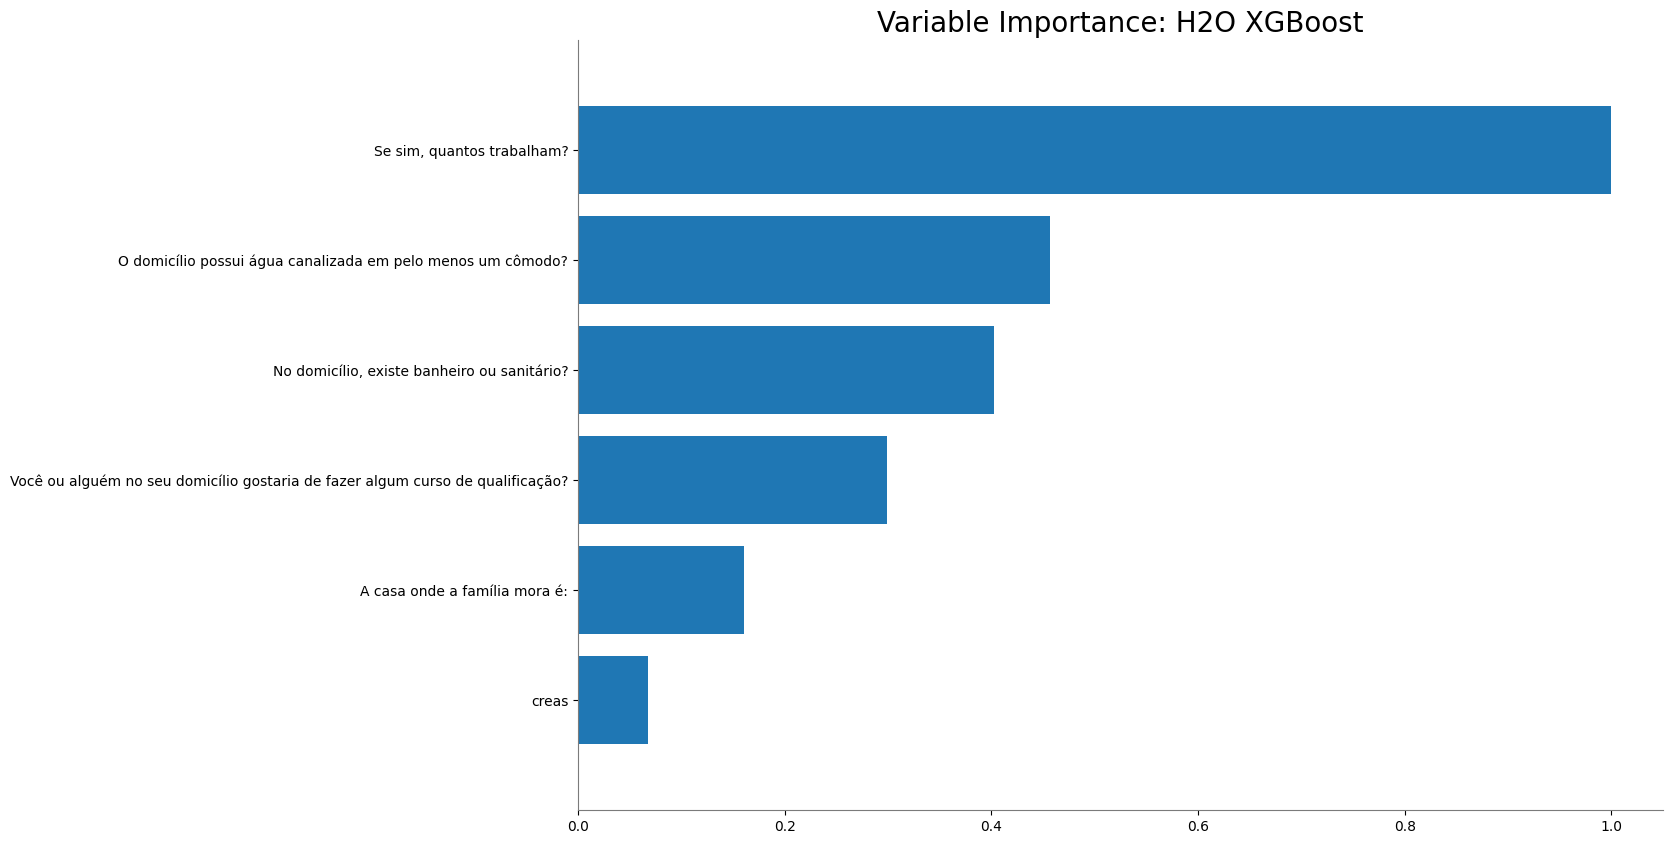

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_ridge_classifier

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",creas,"Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?",ia level
0,0.553376,0,0,sem ia
0,0.245875,0,0,sem ia
0,0.382755,0,0,grave
0,0.412541,0,0,grave
0.166667,0.139879,0,0,sem ia
0,0.409823,0,0,grave
0,0.49505,0,0,grave
0,0.165017,0,0,grave
0,0.491749,0,1,moderada
0,0.349148,0,0,leve


AutoML progress: |████████████
14:12:36.404: DRF_1_AutoML_4_20221020_140208 [DRF def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_1_AutoML_4_20221020_140208_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (140,0 KB per tree x 50 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!


██
14:14:31.239: GBM_4_AutoML_4_20221020_140208 [GBM def_4] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_4_AutoML_4_20221020_140208_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (10,8 KB per tree x 10000 > 83,5 MB) - try decreasing ntrees and/or max_depth or increasing min_rows!


███████████████████████████████████████████████
15:00:18.878: StackedEnsemble_AllModels_3_AutoML_4_20221020_140208 [StackedEnsemble all_4 (built with AUTO metalearner, using all AutoML models

### Best Model Updated: df_SFM_ridge_classifier-StackedEnsemble_BestOfFamily_4_AutoML_4_20221020_140208-acc:0.417385421951632

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFM_ridge_classifier-StackedEnsemble_BestOfFamily_4_AutoML_4_20221020_140208-acc:0.417385421951632

### df_SFM_ridge_classifier has accuracy: 0.417385421951632

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_4_20221020_140208

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.45276199016842944
RMSE: 0.6728759099331982
LogLoss: 1.158712208672478
Null degrees of freedom: 9938
Residual degrees of freedom: 9875
Null deviance: 27559.859364113483
Residual deviance: 23032.881283991515
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
105      657     1524        209       0.957916   2.390 / 2.495
17       1342    722         339       0.445455   1.078 / 2.420
70       75      2205        98        0.0992647  243 / 2.448
18       1067    708         783       0.69604    1.793 / 2.576
210      3141    5159        1429      0.553778   5.504 / 9.939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.446222
2    0.754201
3    0.92293
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4713082227229738
RMSE: 0.6865189165077491
LogLoss: 1.2158024813589206
Null degrees of freedom: 53214
Residual degrees of freedom: 53153
Null deviance: 147519.505549681
Residual deviance: 129397.85809102992
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1109     3079    7429        1370      0.914607  11.878 / 12.987
863      6245    3616        2896      0.541483  7.375 / 13.620
1284     612     10417       674       0.19789   2.570 / 12.987
648      5269    3676        4028      0.70428   9.593 / 13.621
3904     15205   25138       8968      0.59036   31.416 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.40964
2    0.729869
3    0.907413
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.40969   0.00932449  0.403442      0.406499      0.419096      0.410026      0.408853      0.411305      0.401724      0.392639      0.422273      0.421043
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.59031   0.00932449  0.596558      0.593501      0.580904      0.589974      0.591147      0.588695      0.598276      0.607361      0.577727      0.578957
err_count                3141.6    74.3374     3154          3123          3109          3154          3165          3166          3193          3284          3014          3054
logloss                  1.21576   0.00842198  1.22313       1.21648       1.21328       1.20855       1.21469       1.21091       1.22197       1.23139       1.201         1.21624
max_per_class_error      0.914191  0.021

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFM_sgd_classifier

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",creas,ia level
0,0.424412,0,grave
0,0.412541,0,leve
0,0.30477,0,leve
0.166667,0.278878,0,leve
0,0.412541,0,leve
0,0.412541,0,sem ia
0,0.412541,0,moderada
0.0388661,0.473747,0,leve
0.166667,0.991249,0,sem ia
0,0.371287,0,grave


AutoML progress: |██████████████████
15:18:29.68: GBM_3_AutoML_5_20221020_150216 [GBM def_3] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_3_AutoML_5_20221020_150216_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (3,3 KB per tree x 10000 > 29,8 MB) - try decreasing ntrees and/or max_depth or increasing min_rows!



15:18:46.533: GBM_4_AutoML_5_20221020_150216 [GBM def_4] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_4_AutoML_5_20221020_150216_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (6,7 KB per tree x 10000 > 39,2 MB) - try decreasing ntrees and/or max_depth or increasing min_rows!


████████
15:25:52.548: XRT_1_AutoML_5_20221020_150216 [DRF XRT (Extremely Randomized Trees)] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF 

H2OConnectionError: Local server has died unexpectedly. RIP.

<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

# Execução Boruta

In [ ]:
boruta = [9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25]

In [ ]:
df_boruta = df[boruta]

In [ ]:
feature_combinations = {
    "df_boruta" : df[boruta]
}

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_boruta

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0.412541,1,0,0,0,1,1,1,1,1,0,0,1,sem ia
0,0.825083,1,1,1,0,1,1,0,0,1,0,0,1,grave
0,0.465578,1,0,1,0,1,1,1,1,1,0,0,1,sem ia
0.0152179,0.24085,1,0,0,0,1,1,0,1,1,1,0,1,sem ia
0.5,1,1,1,1,0,0,0,1,0,0,0,0,1,grave
0,0.418804,1,0,0,0,1,0,0,1,1,0,0,0,leve
0,0.330033,0,0,1,0,1,1,0,1,1,0,0,1,moderada
0,0.412541,1,0,1,0,0,1,1,1,1,0,0,1,leve
0,0.412541,0,0,1,0,0,1,1,1,0,0,0,1,sem ia
0,0.412541,1,0,0,0,0,0,1,1,1,0,0,1,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_boruta-StackedEnsemble_AllModels_3_AutoML_1_20221020_204916-acc:0.5514967021816337

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_boruta-StackedEnsemble_AllModels_3_AutoML_1_20221020_204916-acc:0.5514967021816337

### df_boruta has accuracy: 0.5514967021816337

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221020_204916

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.2855293508305522
RMSE: 0.534349465079317
LogLoss: 0.779254396299687
Null degrees of freedom: 9938
Residual degrees of freedom: 9697
Null deviance: 27548.43839183852
Residual deviance: 15490.018889645178
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
951      280     895         296       0.607349  1.471 / 2.422
36       1983    260         292       0.228705  588 / 2.571
92       189     1851        269       0.229071  550 / 2.401
52       222     206         2065      0.188605  480 / 2.545
1131     2674    3212        2922      0.310796  3.089 / 9.939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.689204
2    0.898682
3    0.974243
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.36146404670706184
RMSE: 0.6012188010259342
LogLoss: 0.9963730140608016
Null degrees of freedom: 53214
Residual degrees of freedom: 53038
Null deviance: 147521.18472415113
Residual deviance: 106043.97988649111
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5189     2071    3849        1878      0.600447  7.798 / 12.987
852      9166    1301        2302      0.327068  4.455 / 13.621
2476     1585    7280        1646      0.439439  5.707 / 12.987
932      2349    1626        8713      0.360279  4.907 / 13.620
9449     15171   14056       14539     0.42971   22.867 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.57029
2    0.829071
3    0.948943
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.570311  0.00427438  0.572347      0.577347      0.56417       0.566779      0.573029      0.563778      0.569608      0.572221      0.571127      0.572701
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.429689  0.00427438  0.427653      0.422653      0.43583       0.433221      0.42697       0.436222      0.430392      0.427779      0.428873      0.427299
err_count                2286.7    41.4301     2261          2224          2333          2316          2286          2346          2297          2313          2237          2254
logloss                  0.996364  0.00764064  0.992977      0.996424      0.997652      0.994257      0.985929      1.01137       1.00317       0.989209      0.990149      1.00251
max_per_class_error      0.600454  0.00790565  0.59813

Variable importance plot is not available for this type of model (stackedensemble).


# Sequencial Feature Selector (SFS)

In [ ]:
SFS_ridge_classifier_forward = [8, 11, 14, 15, 17, 18, 19, 24, 25]
SFS_ridge_classifier_backward = [8, 11, 14, 15, 17, 18, 19, 20, 25]
SFS_logistic_regression_forward = [8, 12, 15, 17, 20, 21, 22, 24, 25]
SFS_logistic_regression_backward = [8, 11, 15, 17, 18, 19, 20, 21, 25]

In [ ]:
df_SFS_ridge_classifier_forward = df[SFS_ridge_classifier_forward]
df_SFS_ridge_classifier_backward = df[SFS_ridge_classifier_backward]
df_SFS_logistic_regression_forward = df[SFS_logistic_regression_forward]
df_SFS_logistic_regression_backward = df[SFS_logistic_regression_backward]

In [ ]:
feature_combinations = {
    'df_SFS_ridge_classifier_forward' : df[SFS_ridge_classifier_forward],
    'df_SFS_ridge_classifier_backward' : df[SFS_ridge_classifier_backward],
    'df_SFS_logistic_regression_forward' : df[SFS_logistic_regression_forward],
    'df_SFS_logistic_regression_backward' : df[SFS_logistic_regression_backward]
}

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_ridge_classifier_forward

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,1,0,1,1,1,1,grave
0,0,1,0,0,1,1,1,leve
0,1,0,0,1,1,1,0,moderada
0,0,0,1,1,1,1,1,moderada
1,1,1,0,1,1,1,1,sem ia
0,1,1,1,1,0,1,1,grave
0,1,1,1,1,1,1,1,moderada
0,1,0,0,1,1,1,0,leve
0,1,0,1,1,1,1,1,moderada
0,1,1,1,0,1,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFS_ridge_classifier_forward-GBM_grid_1_AutoML_1_20221021_143957_model_10-acc:0.3585320480297649

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFS_ridge_classifier_forward-GBM_grid_1_AutoML_1_20221021_143957_model_10-acc:0.3585320480297649

### df_SFS_ridge_classifier_forward has accuracy: 0.3585320480297649

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20221021_143957_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    33                 132                         130761                 0            8            5.42424       1             153           74.3106

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.5244758672614757
RMSE: 0.7242070610408847
LogLoss: 1.3148657499087006
Mean Per-Class Error: 0.6348622331423651
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5538     2227    1495        3727      0.573574  7.449 / 12.987
2807     4002    957         5854      0.706167  9.618 / 13.620
3562     2518    2100        4807      0.8383    10.887 / 12.987
2364     2462    914         7881      0.421408  5.740 / 13.621
14271    11209   5466        22269     0.633167  33.694 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.366833
2    0.635911
3    0.846228
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.5272436319357953
RMSE: 0.7261154398136671
LogLoss: 1.3227273522064174
Mean Per-Class Error: 0.6390197644854025
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5497     2236    1535        3719      0.576731  7.490 / 12.987
2860     3947    965         5848      0.710206  9.673 / 13.620
3609     2517    2069        4792      0.840687  10.918 / 12.987
2407     2503    926         7785      0.428456  5.836 / 13.621
14373    11203   5495        22144     0.637358  33.917 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.362642
2    0.628056
3    0.841548
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.362398  0.00504511  0.363773      0.358136      0.354002      0.359076      0.364337      0.365157      0.365909      0.359331      0.36215       0.372111
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.637602  0.00504511  0.636227      0.641864      0.645998      0.640924      0.635663      0.634843      0.634091      0.640669      0.63785       0.627889
err_count                3393      27.0267     3386          3416          3438          3411          3383          3378          3374          3409          3394

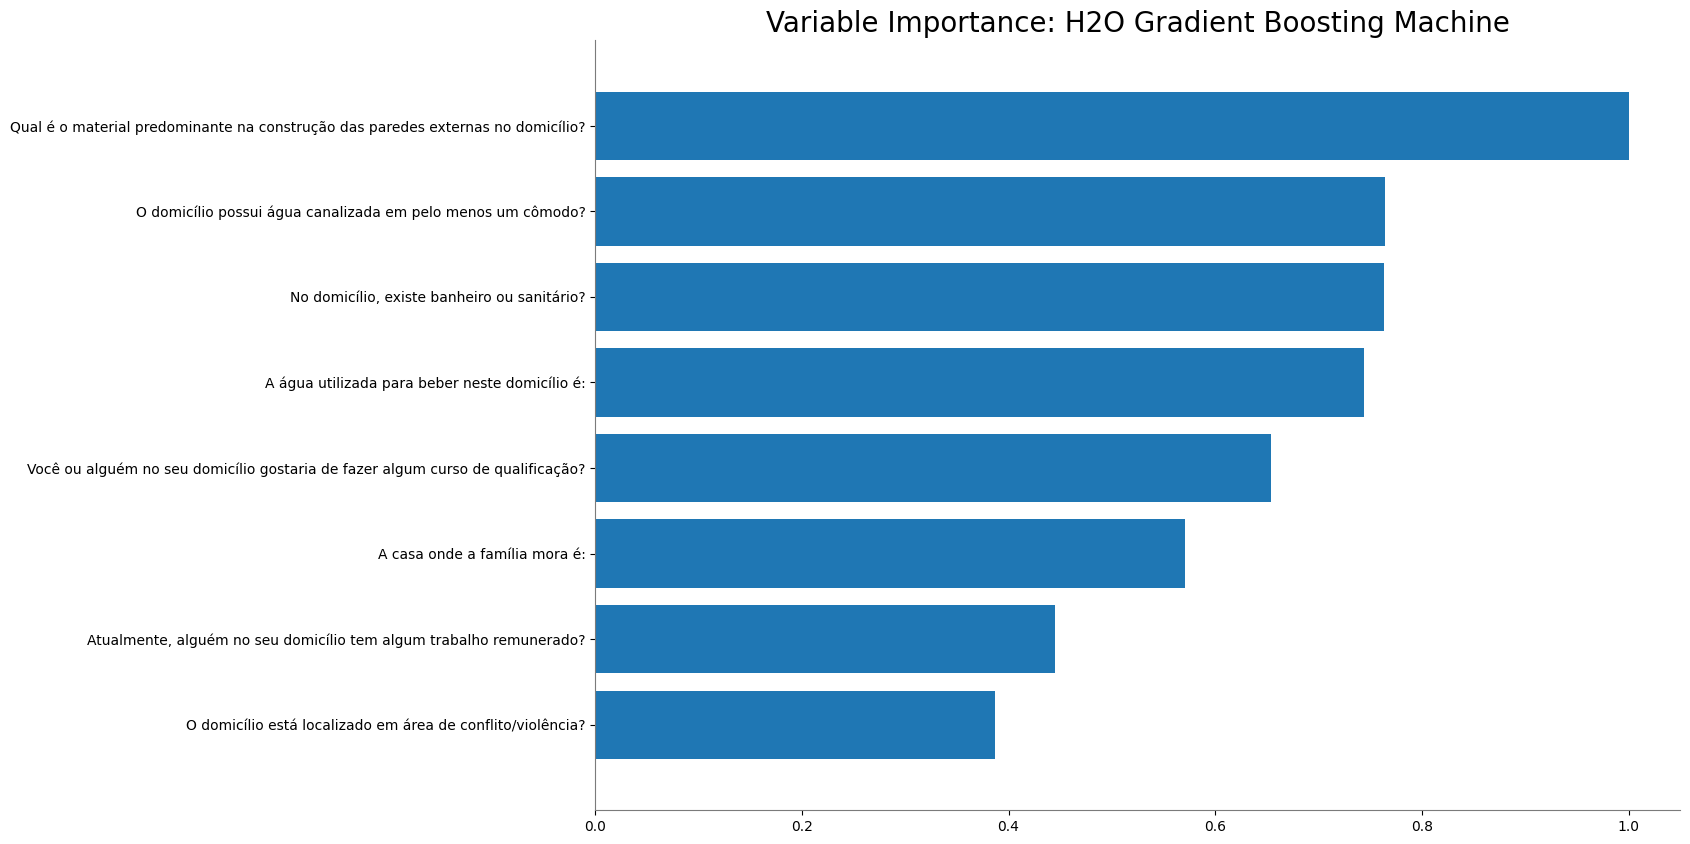

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_ridge_classifier_backward

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,ia level
0,0,0,0,0,1,1,1,sem ia
0,0,1,1,0,0,1,0,grave
0,0,0,0,1,1,1,1,leve
0,0,0,0,1,1,1,0,moderada
0,1,1,1,0,1,1,0,grave
1,1,1,0,0,1,0,0,moderada
0,1,1,1,1,0,1,1,sem ia
0,1,1,0,0,1,1,0,sem ia
1,1,0,1,0,0,1,1,grave
0,0,1,0,1,0,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SFS_ridge_classifier_backward-GBM_grid_1_AutoML_2_20221021_154027_model_10-acc:0.37476746152545237

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SFS_ridge_classifier_backward-GBM_grid_1_AutoML_2_20221021_154027_model_10-acc:0.37476746152545237

### df_SFS_ridge_classifier_backward has accuracy: 0.37476746152545237

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20221021_154027_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    31                 124                         153819                 0            8            5.62097       1             186           94.1129

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.5224482263707408
RMSE: 0.7228058012846471
LogLoss: 1.3112414418093246
Mean Per-Class Error: 0.6310334223298042
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4975     3070    1540        3402      0.616925  8.012 / 12.987
2207     5072    955         5387      0.627634  8.549 / 13.621
3005     3354    2117        4511      0.836991  10.870 / 12.987
1986     3174    868         7592      0.442584  6.028 / 13.620
12173    14670   5480        20892     0.628751  33.459 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.371249
2    0.638485
3    0.845701
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.5256588573742708
RMSE: 0.7250233495372895
LogLoss: 1.3202339706262967
Mean Per-Class Error: 0.636085052213608
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4913     3100    1592        3382      0.621699  8.074 / 12.987
2221     5038    997         5365      0.63013   8.583 / 13.621
3059     3370    2072        4486      0.840456  10.915 / 12.987
2002     3243    912         7463      0.452056  6.157 / 13.620
12195    14751   5573        20696     0.633825  33.729 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.366175
2    0.629033
3    0.840891
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.3661    0.00401814   0.36847       0.360391      0.372416      0.359451      0.367155      0.369667      0.365533      0.364405      0.368352      0.365157
auc                      nan       0            nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.6339    0.00401814   0.631529      0.639609      0.627584      0.640549      0.632845      0.630333      0.634467      0.635595      0.631648      0.634843
err_count                3373.3    21.4323      3361          3404          3340          3409          3368          3354          3376          3382         

<Figure size 640x480 with 0 Axes>

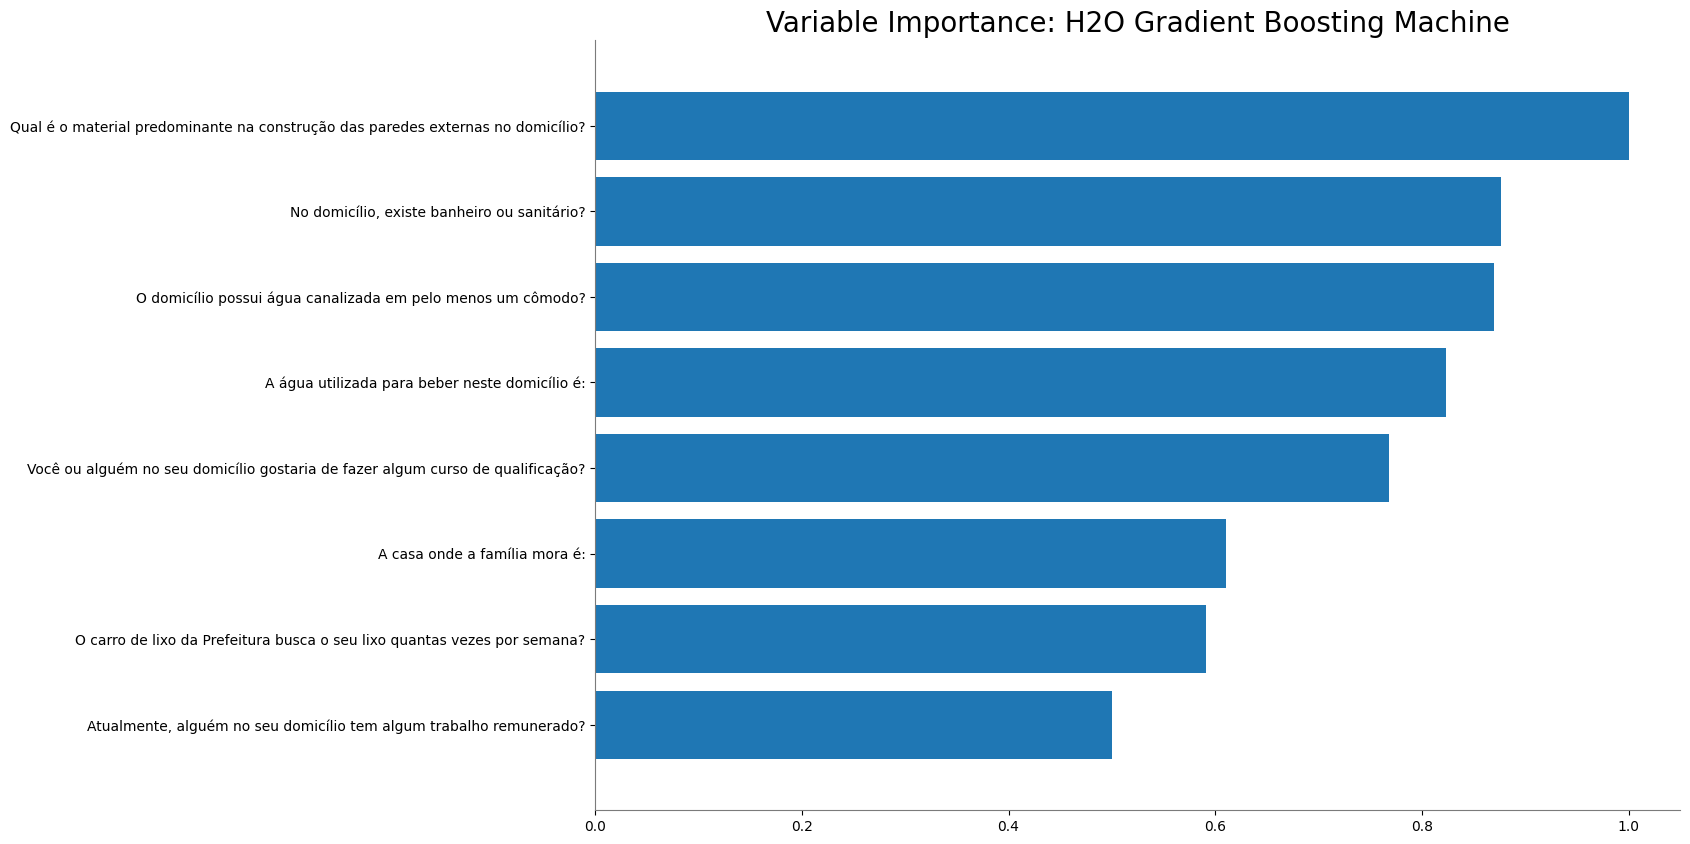

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_logistic_regression_forward

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",cras,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0,1,1,0,0,1,leve
0,0,0,1,1,0,0,1,moderada
0,0,0,0,0,0,0,1,moderada
1,0,0,1,1,0,0,1,sem ia
0,0,1,0,1,1,0,1,moderada
0,1,0,1,1,0,0,1,moderada
0,1,1,1,1,0,0,1,grave
0,0,0,1,1,0,0,1,grave
1,0,0,1,1,0,0,1,moderada
1,1,0,1,0,0,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### df_SFS_logistic_regression_forward has accuracy: 0.3416201589717571

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_3_20221021_164031


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    38                 152                         61045                  6            6            5.93421       1             40            27.2632

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.5371448963538101
RMSE: 0.732901696241597
LogLoss: 1.3409471712705596
Mean Per-Class Error: 0.6606776834877466
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5611     3569    1712        2095      0.567953  7.376 / 12.987
3339     5990    1196        3096      0.560238  7.631 / 13.621
4104     4180    2118        2585      0.836914  10.869 / 12.987
3225     4889    1115        4391      0.677606  9.229 / 13.620
16279    18628   6141        12167     0.659682  35.105 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.340318
2    0.610298
3    0.826891
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.5385861234296193
RMSE: 0.7338842711419964
LogLoss: 1.344699567383367
Mean Per-Class Error: 0.6637700191986792
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5583     3483    1723        2198      0.570109  7.404 / 12.987
3341     5781    1226        3273      0.575582  7.840 / 13.621
4133     4048    2095        2711      0.838685  10.892 / 12.987
3240     4737    1158        4485      0.670705  9.135 / 13.620
16297    18049   6202        12667     0.662802  35.271 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.337198
2    0.605074
3    0.823076
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.337198  0.00524289  0.335776      0.332018      0.33991       0.3292        0.341413      0.339598      0.345612      0.330577      0.340162      0.337718
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.662802  0.00524289  0.664224      0.667982      0.66009       0.6708        0.658587      0.660402      0.654388      0.669423      0.659838      0.662281
err_count                3527.1    28.0097     3535          3555          3513          3570          3505          3514          3482          3562          3511          3524
l

<Figure size 640x480 with 0 Axes>

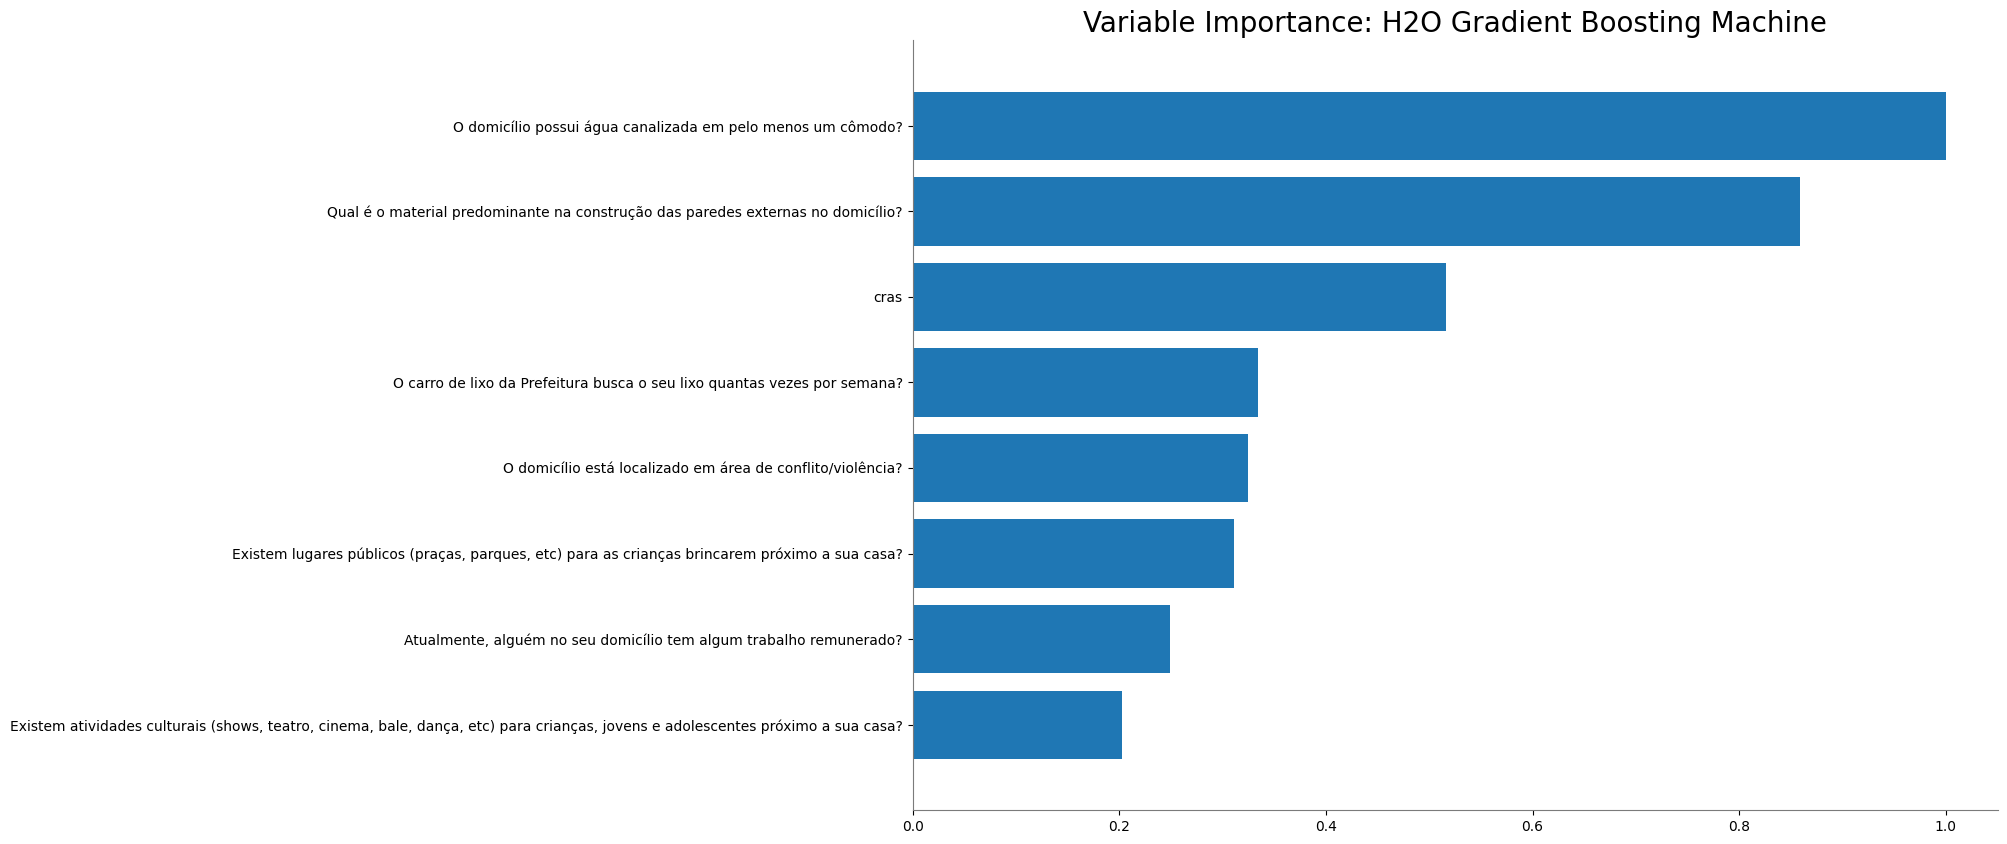

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SFS_logistic_regression_backward

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,1,0,0,0,0,0,grave
1,1,0,1,1,1,0,0,leve
0,0,0,1,0,1,1,0,moderada
0,0,1,1,1,1,0,0,moderada
0,0,1,1,1,0,0,0,grave
0,1,0,1,0,1,0,0,leve
0,0,1,0,0,0,0,0,sem ia
0,1,0,1,1,1,1,0,sem ia
0,0,0,1,0,1,0,0,moderada
0,1,0,1,1,1,0,0,leve


AutoML progress: |█████████████████████████████████████████████
18:13:11.546: GBM_grid_1_AutoML_4_20221021_174056 [GBM Grid Search] failed: water.exceptions.H2OGridException: Aborting Grid search after too many consecutive model failures.

████████████
18:32:33.962: StackedEnsemble_AllModels_3_AutoML_4_20221021_174056 [StackedEnsemble all_4 (built with AUTO metalearner, using all AutoML models)] failed: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space

█████
18:39:44.700: StackedEnsemble_AllModels_4_AutoML_4_20221021_174056 [StackedEnsemble all_5 (built with AUTO metalearner, using all AutoML models)] failed: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space


18:40:06.115: GBM_lr_annealing_selection_AutoML_4_20221021_174056 [GBM lr_annealing] failed: water.exceptions.H2OIllegalArgumentException: Can only convert jobs producing a single Model or ModelCo

### df_SFS_logistic_regression_backward has accuracy: 0.3541349568746829

### Details of the best model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_3_AutoML_4_20221021_174056


Model Summary: 
    number_of_trees
--  -----------------
    35

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.5267558617313493
RMSE: 0.7257794856093338
LogLoss: 1.3226515501747105
Mean Per-Class Error: 0.6429692680943382
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4734     2701    1900        3652      0.635482  8.253 / 12.987
2221     4881    1196        5322      0.64163   8.739 / 13.620
2806     3121    2581        4479      0.801263  10.406 / 12.987
1925     3648    1149        6899      0.493503  6.722 / 13.621
11686    14351   6826        20352     0.641173  34.120 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.358827
2    0.629597
3    0.84215
4    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.5287696948619495
RMSE: 0.7271655209523823
LogLoss: 1.3284524656903893
Mean Per-Class Error: 0.6467544858248696
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4661     2718    1811        3797      0.641103  8.326 / 12.987
2126     4825    1144        5525      0.645742  8.795 / 13.620
2837     3155    2383        4612      0.816509  10.604 / 12.987
1827     3666    1095        7033      0.483665  6.588 / 13.621
11451    14364   6433        20967     0.644799  34.313 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.355201
2    0.625049
3    0.83873
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.3552    0.00466832  0.35419       0.365088      0.35513       0.356633      0.350432      0.34937       0.360083      0.351438      0.355196      0.354445
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.6448    0.00466832  0.64581       0.634912      0.64487       0.643367      0.649568      0.65063       0.639917      0.648562      0.644804      0.645555
err_count                3431.3    24.7613     3437          3379          3432          3424          3457          3462          3405          3451          3431          3435
logloss                  1.32845   0.00524768  1.32938       1.32          1.32619       1.31936       1.33228       1.33379       1.33044       1.32965       1.3347        1.32873
max_per_class_error      0.816449  0.0158237   0.814704      0.818745      0.791022      0.832812      0.846329      0.807932      0.811683      0.826087      0.814409      0.800772
mean_per_class_accuracy  0.353318  0.00442971  0.353845      0.3

<Figure size 640x480 with 0 Axes>

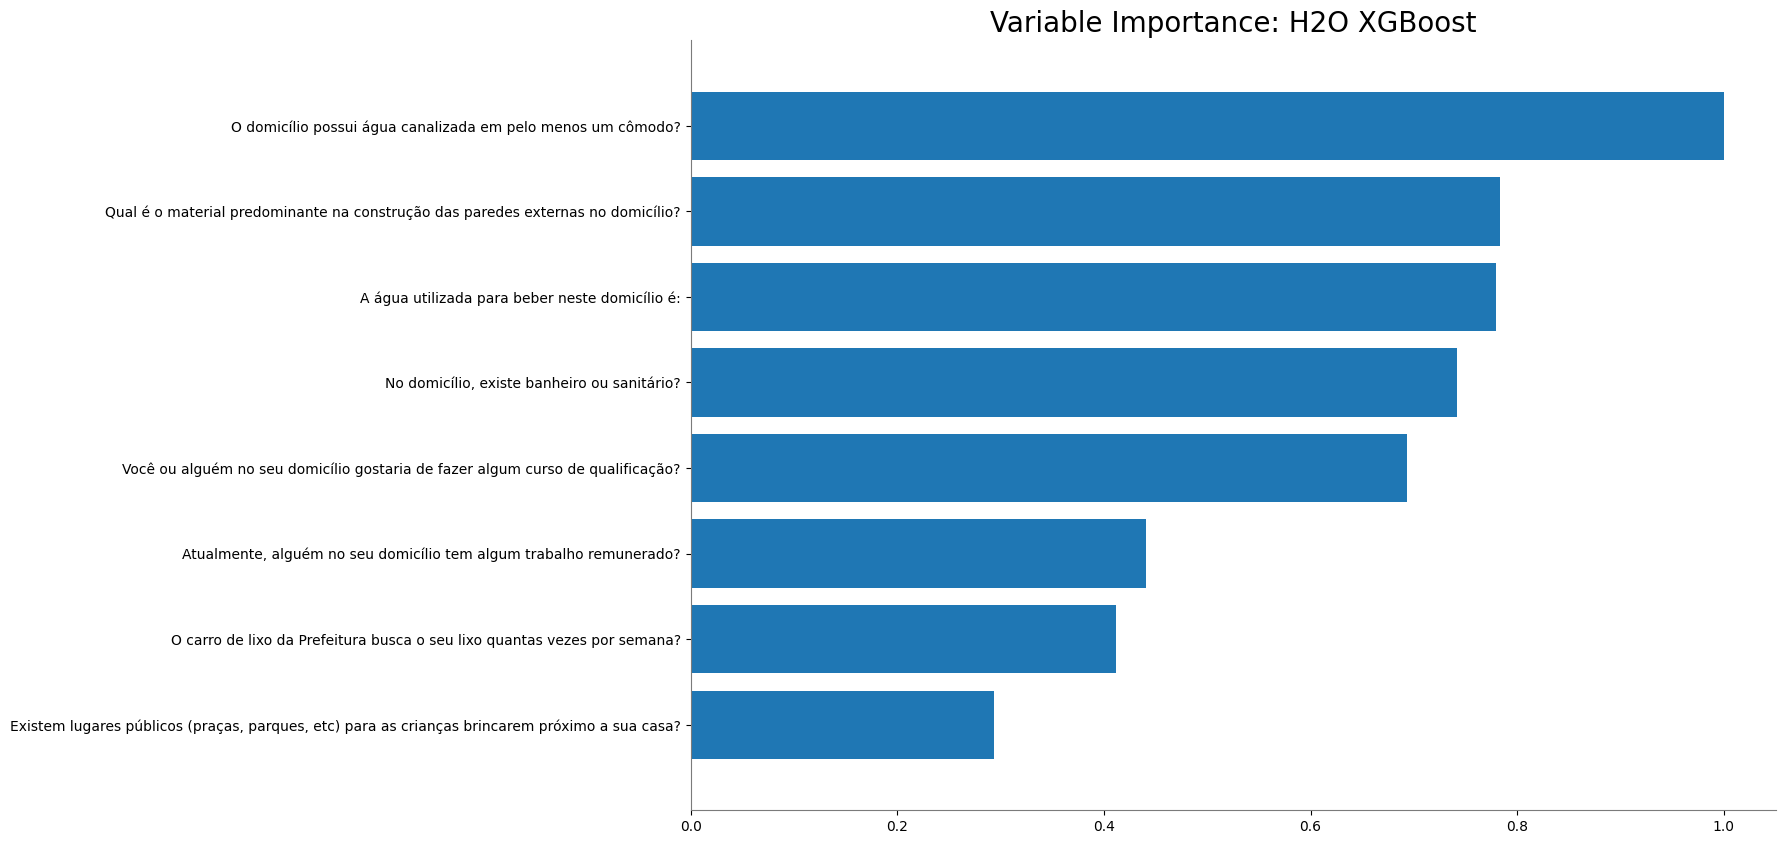

<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

# Select K Best

## Chi2

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_6

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,1,1,0,1,1,grave
0,1,0,1,0,0,moderada
0,1,0,1,1,0,grave
1,1,0,1,1,0,leve
1,1,0,1,1,1,sem ia
0,1,1,0,0,1,moderada
0,0,0,1,1,0,leve
1,1,0,1,1,0,grave
0,1,1,0,1,0,grave
0,0,1,1,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_6-GBM_grid_1_AutoML_1_20221022_221446_model_13-acc:0.33823778116015557

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_6-GBM_grid_1_AutoML_1_20221022_221446_model_13-acc:0.33823778116015557

### df_SKBest_6 has accuracy: 0.33823778116015557

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20221022_221446_model_13


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    36                 144                         34499                  4            4            3.94444       1             16            14.4722

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.5389734383390177
RMSE: 0.7341481038176273
LogLoss: 1.3444702904265258
Mean Per-Class Error: 0.6645267987104592
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4733     3902    1889        2463      0.635559  8.254 / 12.987
2540     5988    1285        3807      0.560352  7.632 / 13.620
3234     4470    2262        3021      0.825826  10.725 / 12.987
2195     5305    1168        4953      0.63637   8.668 / 13.621
12702    19665   6604        14244     0.662952  35.279 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.337048
2    0.609189
3    0.828
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.5395936638031156
RMSE: 0.7345703940420656
LogLoss: 1.346216377113649
Mean Per-Class Error: 0.6653926426912724
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4696     3896    1928        2467      0.638408  8.291 / 12.987
2527     5947    1301        3845      0.563363  7.673 / 13.620
3223     4453    2275        3036      0.824825  10.712 / 12.987
2184     5282    1183        4972      0.634975  8.649 / 13.621
12630    19578   6687        14320     0.663817  35.325 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.336183
2    0.606765
3    0.826853
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.336183  0.00666953  0.338782      0.323375      0.337091      0.347426      0.338031      0.330201      0.337343      0.334524      0.332268      0.342793
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.663817  0.00666953  0.661218      0.676625      0.662909      0.652574      0.661969      0.669799      0.662657      0.665476      0.667732      0.657207
err_count                3532.5    35.4534     3519          3601          3528          3473          3523          3564          3526          3541          3553    

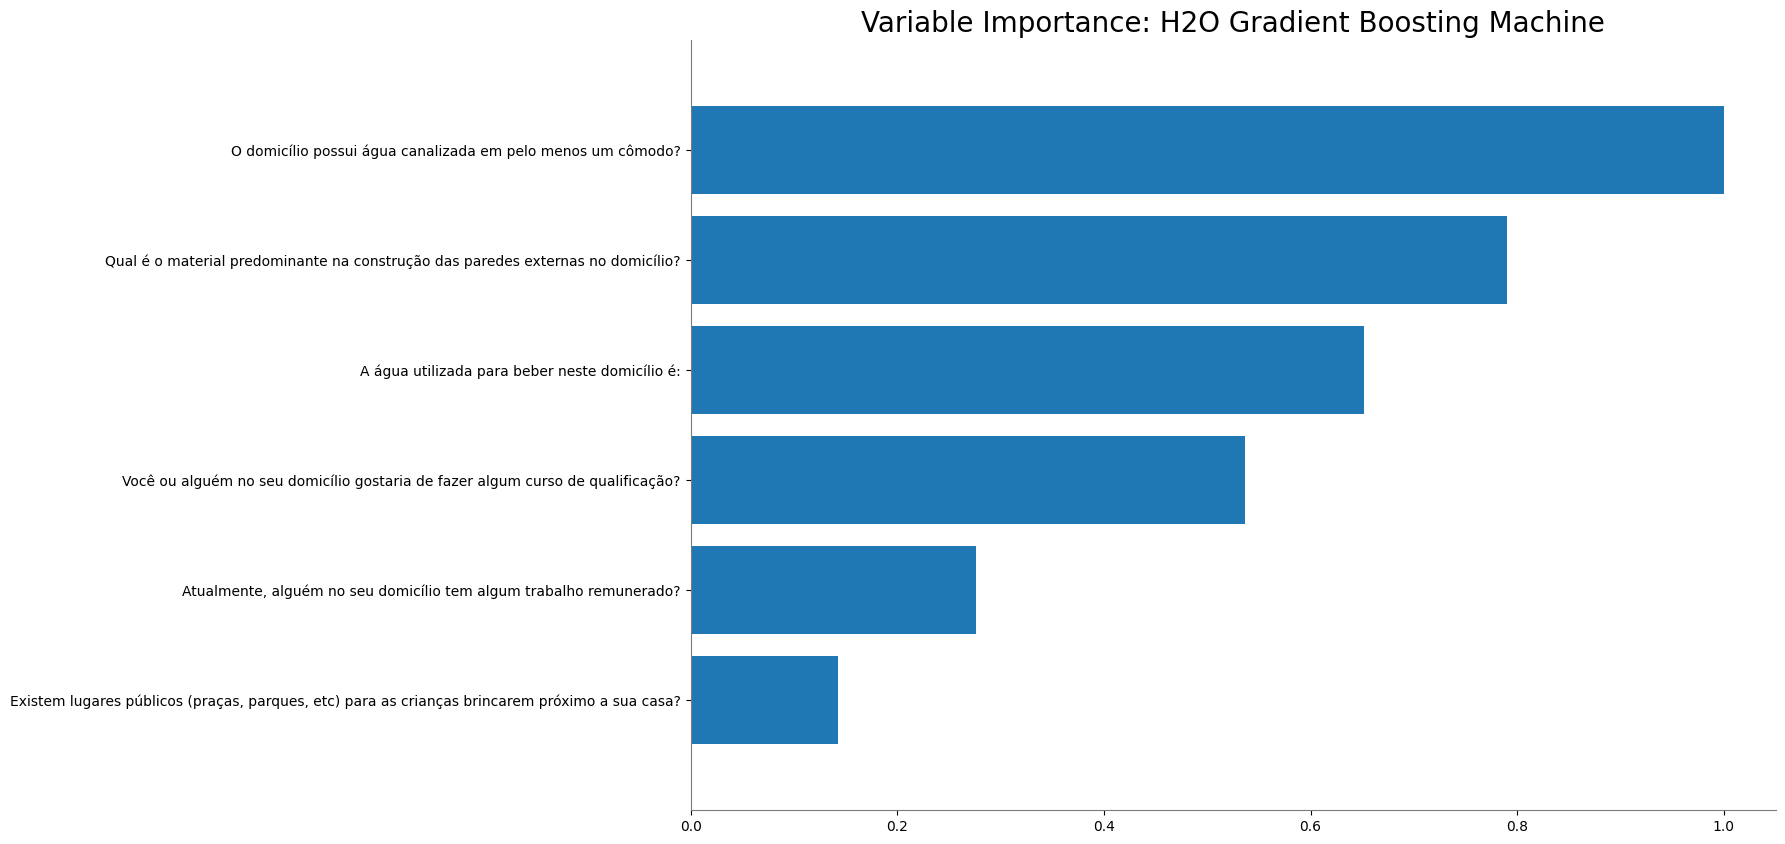

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_7

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é o material predominante na construção das paredes externas no domicílio?0,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
1,1,0,0,1,1,1,moderada
1,1,0,0,1,1,0,leve
0,0,0,0,1,1,0,sem ia
0,1,0,0,0,1,0,grave
0,0,0,0,1,0,0,grave
0,1,0,0,1,0,1,moderada
0,0,0,0,1,1,0,moderada
1,1,0,0,1,1,1,moderada
0,1,0,0,1,0,0,grave
0,1,0,0,1,1,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_7-XGBoost_grid_1_AutoML_2_20221022_231519_model_5-acc:0.3402672078471165

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_7-XGBoost_grid_1_AutoML_2_20221022_231519_model_5-acc:0.3402672078471165

### df_SKBest_7 has accuracy: 0.3402672078471165

### Details of the best model

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_2_20221022_231519_model_5


Model Summary: 
    number_of_trees
--  -----------------
    30

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.5362752371919014
RMSE: 0.7323081572616145
LogLoss: 1.3417724925535957
Mean Per-Class Error: 0.664218534360288
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4472     3850    2144        2521      0.655656  8.515 / 12.987
2308     5841    1493        3978      0.571145  7.779 / 13.620
2966     4381    2560        3080      0.80288   10.427 / 12.987
1997     5172    1374        5078      0.627193  8.543 / 13.621
11743    19244   7571        14657     0.66267   35.264 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.33733
2    0.612346
3    0.830292
4    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.537247439443423
RMSE: 0.7329716498224355
LogLoss: 1.344576823007614
Mean Per-Class Error: 0.6652683388241893
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4497     3846    2123        2521      0.653731  8.490 / 12.987
2330     5831    1481        3978      0.57188   7.789 / 13.620
3039     4378    2490        3080      0.80827   10.497 / 12.987
2033     5164    1346        5078      0.627193  8.543 / 13.621
11899    19219   7440        14657     0.663704  35.319 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.336296
2    0.609058
3    0.828808
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.336296  0.00601735   0.334836      0.33634       0.330703      0.324126      0.346674      0.339786      0.339974      0.335275      0.33941       0.335839
auc                      nan       0            nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.663704  0.00601735   0.665163      0.66366       0.669297      0.675874      0.653326      0.660214      0.660026      0.664725      0.66059       0.664161
err_count                3531.9    32.1332      3540          3532          3562          3597          3477          3513          3512          3537          3515          3534
logloss                  1.34458   0.00401222   1.34421       1.34666       1.34792       1.35053       1.3387        1.33813       1.34302       1.34646       1.34744       1.3427
max_per_class_error      0.808282  0.0132811    0.806475      0.82467       0.824167      0.814565      0.794552      0.805195      0.794286      0.806991      0.788388      0.823529
mean_per_class_accuracy  0.334672  0.00568625 

<Figure size 640x480 with 0 Axes>

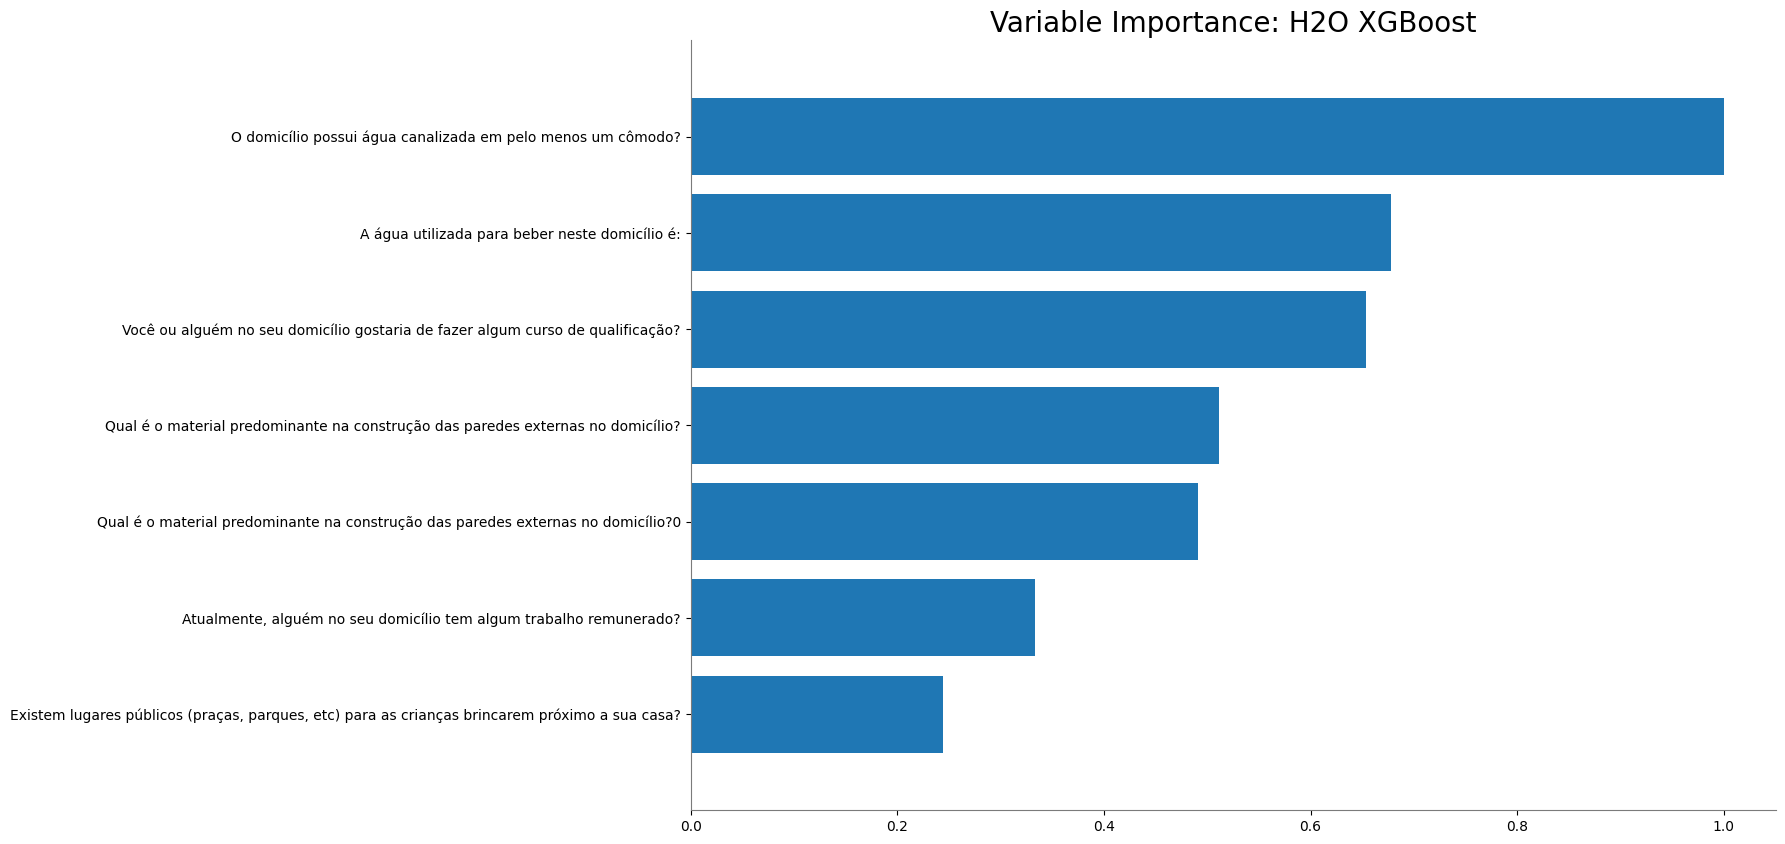

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_8

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,creas,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","No domicílio, existe banheiro ou sanitário?",ia level
1,0,0,0,0,1,0,1,leve
0,0,0,0,1,1,0,1,moderada
0,1,0,0,1,1,1,1,moderada
0,0,0,1,1,0,0,1,sem ia
0,1,0,0,1,1,0,1,sem ia
0,0,0,0,0,1,0,1,leve
0,1,0,0,1,1,0,1,moderada
0,0,0,0,0,0,0,1,grave
1,1,0,1,1,0,0,0,sem ia
0,1,0,1,0,0,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Total input file size of 7,5 KB is much larger than total cluster memory of Zero  , please use either a larger cluster or smaller data.
  Request: POST /3/Parse
    data: {'destination_frame': 'AutoML_3_20221023_01602_leaderboard', 'parse_type': 'CSV', 'separator': '44', 'check_header': '1', 'number_columns': '6', 'chunk_size': '4194304', 'delete_on_done': 'True', 'blocking': 'False', 'column_types': '["string","string","double","double","double","double"]', 'single_quotes': 'False', 'escapechar': '0', 'column_names': '["","model_id","mean_per_class_error","logloss","rmse","mse"]', 'source_frames': '["upload_ad9eaefeccc9d0273859335bc3ee4c0e"]'}


<Figure size 640x480 with 0 Axes>

In [ ]:
SKBest_6 = [8, 11, 15, 17, 18, 21, 25]
SKBest_7 = [8, 11, 15, 15, 17, 18, 21, 25]
SKBest_8 = [8, 11, 13, 15, 17, 18, 21, 19, 25]
SKBest_9 = [8, 11, 12, 13, 15, 17, 18, 21, 19, 25]
SKBest_10 = [8, 11, 12, 14, 15, 17, 18, 21, 19, 22, 25]
SKBest_11 = [8, 11, 12, 13, 15, 17, 18, 21, 19, 22, 23, 25]

df_SKBest_6 = df[SKBest_6]
df_SKBest_7 = df[SKBest_7]
df_SKBest_8 = df[SKBest_8]
df_SKBest_9 = df[SKBest_9]
df_SKBest_10 = df[SKBest_10]
df_SKBest_11 = df[SKBest_11]

feature_combinations = {
    'df_SKBest_6' : df[SKBest_6],
    'df_SKBest_7' : df[SKBest_7],
    'df_SKBest_8' : df[SKBest_8],
    'df_SKBest_9' : df[SKBest_9],
    'df_SKBest_10' : df[SKBest_10],
    'df_SKBest_11' : df[SKBest_11]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

In [ ]:
SKBest_1 = [15, 25]
SKBest_2 = [8, 15, 25]
SKBest_3 = [8, 15, 17, 25]
SKBest_4 = [8, 15, 17, 18, 25]
SKBest_5 = [8, 15, 17, 18, 21, 25]


In [ ]:
df_SKBest_1 = df[SKBest_1]
df_SKBest_2 = df[SKBest_2]
df_SKBest_3 = df[SKBest_3]
df_SKBest_4 = df[SKBest_4]
df_SKBest_5 = df[SKBest_5]



In [ ]:
feature_combinations = {
    'df_SKBest_1' : df[SKBest_1],
    'df_SKBest_2' : df[SKBest_2],
    'df_SKBest_3' : df[SKBest_3],
    'df_SKBest_4' : df[SKBest_4],
    'df_SKBest_5' : df[SKBest_5],
    'df_SKBest_6' : df[SKBest_6],
    'df_SKBest_7' : df[SKBest_7],
    'df_SKBest_8' : df[SKBest_8],
    'df_SKBest_9' : df[SKBest_9],
    'df_SKBest_10' : df[SKBest_10],
    'df_SKBest_11' : df[SKBest_11]
}

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_1

Qual é o material predominante na construção das paredes externas no domicílio?,ia level
0,grave
0,grave
0,leve
1,leve
0,sem ia
0,leve
0,moderada
0,leve
1,leve
0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_1-DeepLearning_grid_1_AutoML_1_20221022_121512_model_5-acc:0.29054625401657364

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_1-DeepLearning_grid_1_AutoML_1_20221022_121512_model_5-acc:0.29054625401657364

### df_SKBest_1 has accuracy: 0.29054625401657364

### Details of the best model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20221022_121512_model_5


Status of Neuron Layers: predicting ia level, 4-class classification, multinomial distribution, CrossEntropy loss, 604 weights/biases, 11,3 KB, 3.599.901 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight          weight_rms          mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  -------------------  ------------------  -------------------  -------------------
    1        1        Input             15.0
    2        100      RectifierDropout  20.0       0.0   0.0   0.0012361844403494615  0.001650291495025158  0.0         0.07235046877573041  0.2704402208328247  0.11302150373775964  0.17997175455093384
    3        4        Softmax                      0.0   0.0   0.06793290683348459    0.06387600302696228   0.0         -5.708209770026151   4.620391845703125   -41.22384573998112   1.2919402122497559

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.555523150871098
RMSE: 0.7453342544597679
LogLoss: 1.3768619435280622
Mean Per-Class Error: 0.7193662294558469
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
691      1746    0           0         0.716455  1.746 / 2.437
408      2126    0           0         0.16101   408 / 2.534
554      1818    0           0         1         2.372 / 2.372
366      2233    0           0         1         2.599 / 2.599
2019     7923    0           0         0.716657  7.125 / 9.942

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.283343
2    0.563669
3    0.780326
4    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.5548696533609266
RMSE: 0.7448957332143383
LogLoss: 1.3754190225616185
Mean Per-Class Error: 0.7139871611997649
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3614     1946    0           7427      0.721722  9.373 / 12.987
2115     2325    0           9181      0.829308  11.296 / 13.621
3171     1951    0           7865      1         12.987 / 12.987
1834     2319    0           9467      0.304919  4.153 / 13.620
10734    8541    0           33940     0.710495  37.809 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.289505
2    0.565198
3    0.787597
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.289505  0.00504632   0.28448       0.295941      0.282788      0.29519       0.293499      0.289795      0.285473      0.

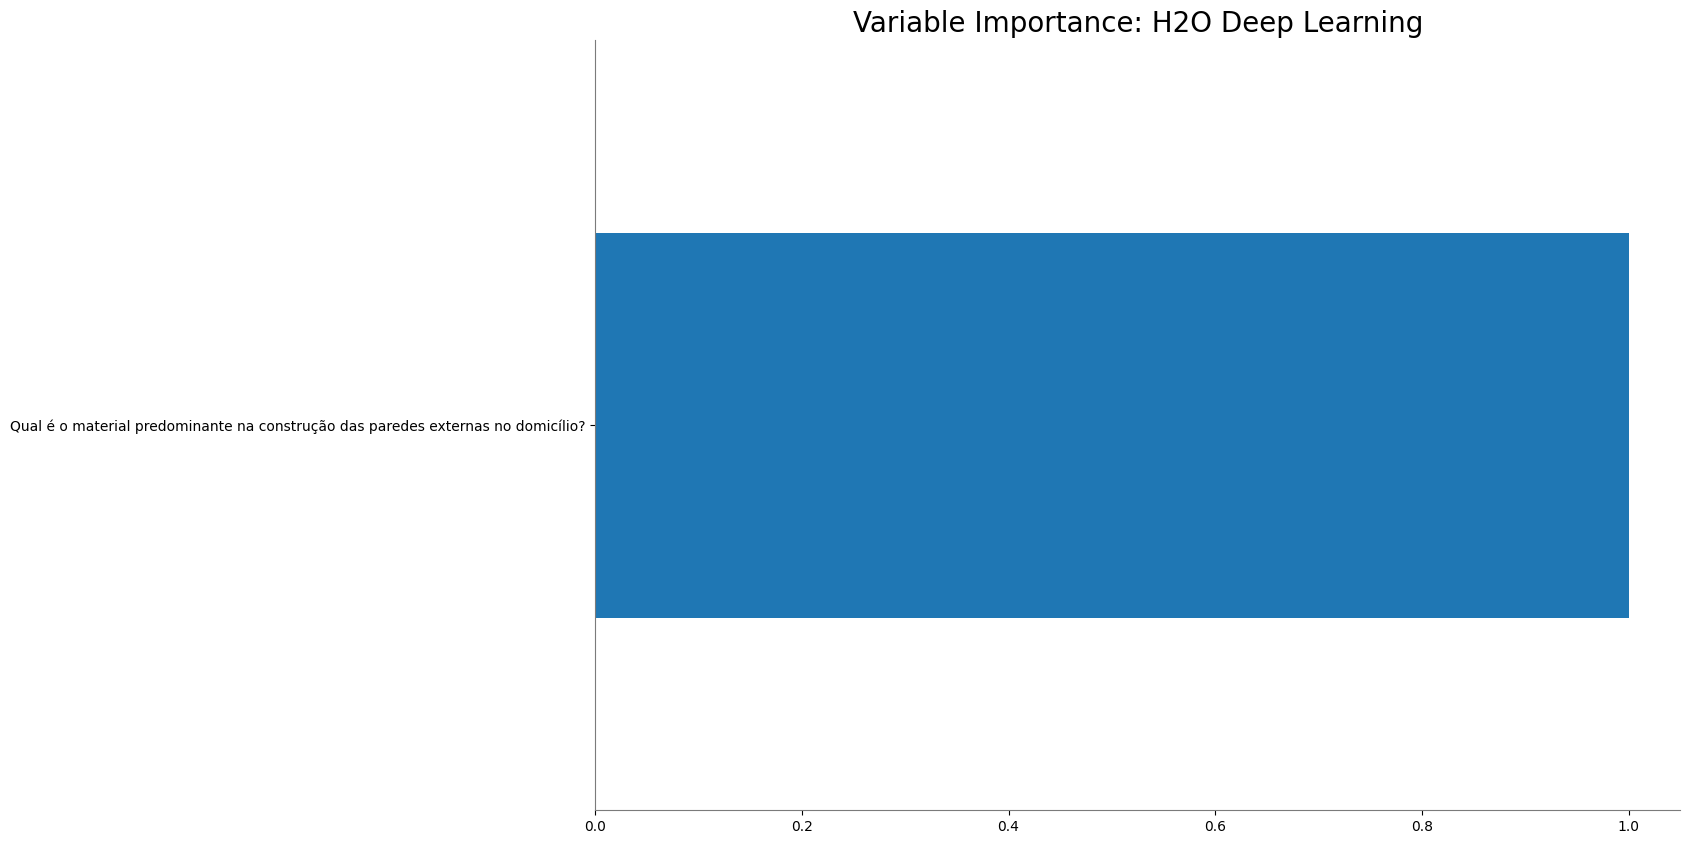

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_2

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Qual é o material predominante na construção das paredes externas no domicílio?,ia level
0,0,sem ia
0,1,grave
0,0,sem ia
0,0,moderada
0,1,grave
0,0,moderada
0,1,sem ia
1,0,leve
1,0,sem ia
0,0,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_2-StackedEnsemble_AllModels_1_AutoML_2_20221022_131527-acc:0.29663453407745644

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_2-StackedEnsemble_AllModels_1_AutoML_2_20221022_131527-acc:0.29663453407745644

### df_SKBest_2 has accuracy: 0.29663453407745644

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20221022_131527

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.5539172359668252
RMSE: 0.7442561628678833
LogLoss: 1.3725692526016595
Null degrees of freedom: 9940
Residual degrees of freedom: 9867
Null deviance: 27557.798766780652
Residual deviance: 27289.421880226193
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
603      0       85          1801      0.757734  1.886 / 2.489
338      0       52          2162      1         2.552 / 2.552
496      0       81          1798      0.965895  2.294 / 2.375
308      0       41          2176      0.138218  349 / 2.525
1745     0       259         7937      0.712303  7.081 / 9.941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.287697
2    0.563625
3    0.783724
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.5537643296716848
RMSE: 0.7441534315392793
LogLoss: 1.3721788998815085
Null degrees of freedom: 53214
Residual degrees of freedom: 53146
Null deviance: 147516.90105984954
Residual deviance: 146041.00031438895
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3298     2243    325         7121      0.746054  9.689 / 12.987
1900     3013    198         8509      0.778781  10.607 / 13.620
2776     2352    382         7477      0.970586  12.605 / 12.987
1664     2809    173         8975      0.341091  4.646 / 13.621
9638     10417   1078        32082     0.705572  37.547 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.294428
2    0.565386
3    0.788725
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.294392  0.00628525   0.290225      0.286529      0.300635      0.289616      0.297161      0.290869      0.304478      0.300536      0.287303      0.29657
auc                      nan       0            nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.705608  0.00628525   0.709775      0.713471      0.699365      0.710384      0.702839      0.709132      0.695522      0.699464      0.712697      0.70343
err_count                3754.7    35.4089      3754          3755          3743          3797          3763          3813          3712          3782          3716          3712
logloss                  1.37218   0.00215653   1.37498       1.37434       1.37029       1.37364       1.37414       1.37075       1.36993       1.37099       1.36915       1.37361
max_per_class_error      0.970569  0.004

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_3

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,ia level
0,0,1,moderada
1,1,1,grave
0,0,0,sem ia
0,0,0,sem ia
0,0,0,sem ia
0,0,1,sem ia
0,0,1,sem ia
0,0,0,leve
0,0,1,leve
0,0,1,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_3-DeepLearning_grid_1_AutoML_3_20221022_141537_model_7-acc:0.31861998985286655

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_3-DeepLearning_grid_1_AutoML_3_20221022_141537_model_7-acc:0.31861998985286655

### df_SKBest_3 has accuracy: 0.31861998985286655

### Details of the best model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20221022_141537_model_7


Status of Neuron Layers: predicting ia level, 4-class classification, multinomial distribution, CrossEntropy loss, 804 weights/biases, 14,2 KB, 5.099.961 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate            rate_rms              momentum    mean_weight           weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  -------------------  --------------------  ----------  --------------------  -------------------  --------------------  -------------------
    1        3        Input             5.0
    2        100      RectifierDropout  20.0       0.0   0.0   0.01335201517213136  0.01680854707956314   0.0         0.005170718471405659  0.11237931251525879  -0.10405212077694488  0.12835347652435303
    3        4        Softmax                      0.0   0.0   0.02434448906336911  0.013326987624168396  0.0         -1.3772283120980138   2.13112735748291     -135.90057310919872   0.13105911016464233

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.5489983829074302
RMSE: 0.7409442508768322
LogLoss: 1.3666452246187346
Mean Per-Class Error: 0.693740239613408
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
761      86      373         1225      0.688753  1.684 / 2.445
434      81      266         1740      0.96787   2.440 / 2.521
589      57      384         1370      0.84      2.016 / 2.400
415      58      244         1859      0.278339  717 / 2.576
2199     282     1267        6194      0.6897    6.857 / 9.942

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.3103
2    0.585999
3    0.804164
4    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.5493551223898181
RMSE: 0.7411849447943597
LogLoss: 1.3650702444468437
Mean Per-Class Error: 0.6899779010368968
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5809     3286    320         3572      0.552707  7.178 / 12.987
3435     4468    258         5459      0.671953  9.152 / 13.620
4763     3530    396         4298      0.969508  12.591 / 12.987
3311     4205    190         5915      0.565744  7.706 / 13.621
17318    15489   1164        19244     0.688283  36.627 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.311717
2    0.589477
3    0.806013
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.311717  0.00588656   0.317926      0.300827      0.306276      0.304397      0.314356      0.317797      0.315166      0

<Figure size 640x480 with 0 Axes>

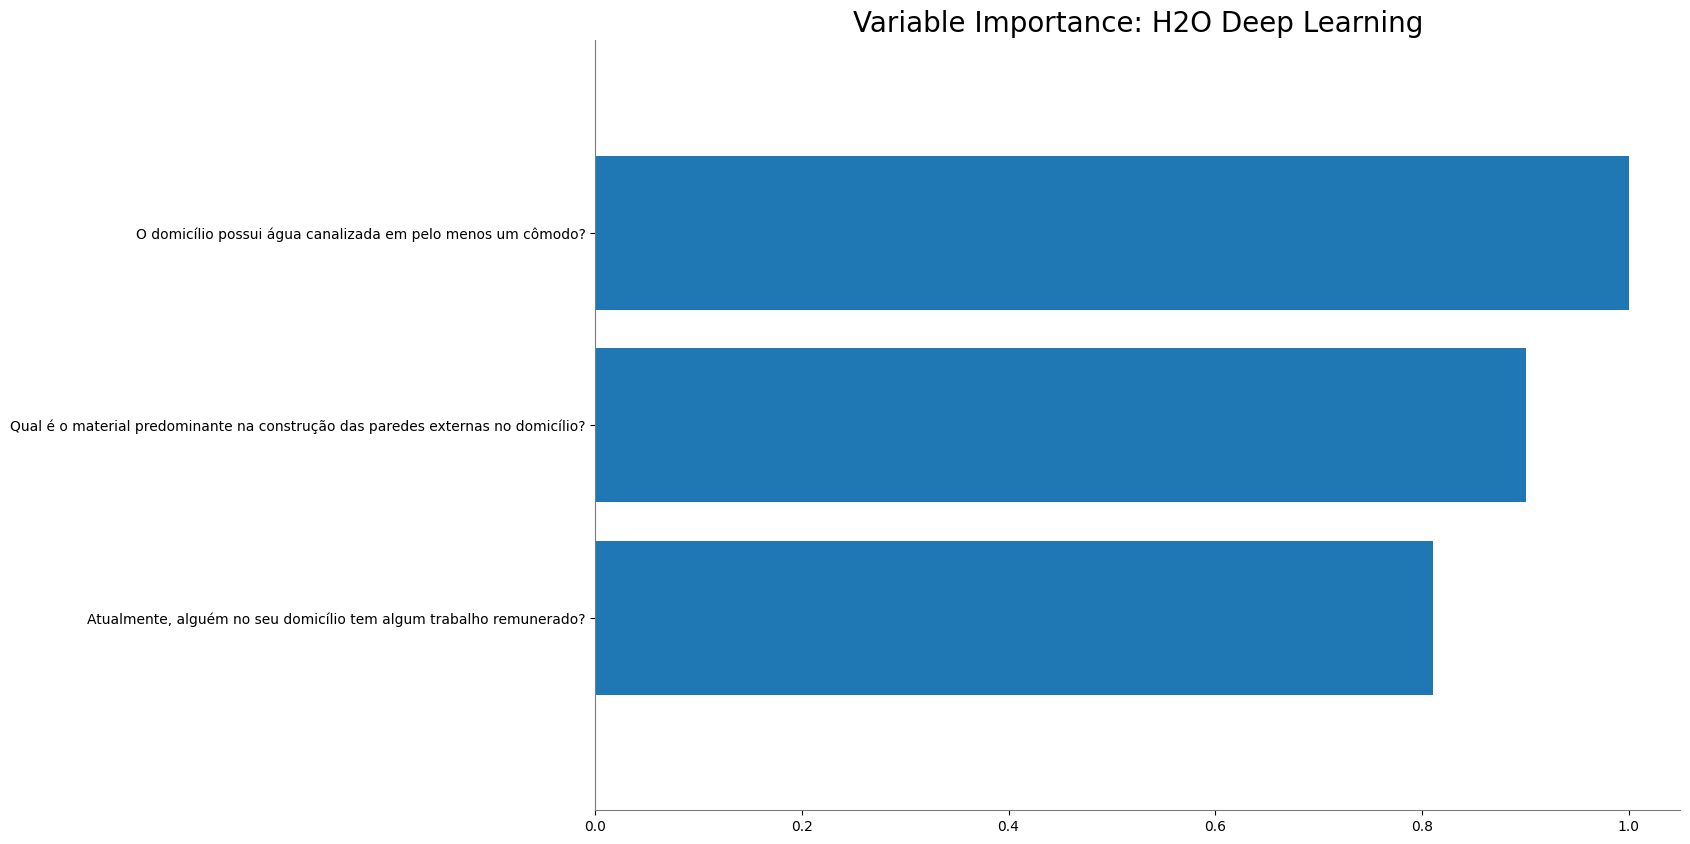

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_4

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,ia level
0,0,1,1,leve
0,0,1,1,sem ia
0,0,1,1,sem ia
0,1,1,0,leve
0,1,0,0,grave
0,1,1,1,grave
0,0,1,0,sem ia
0,0,1,1,leve
0,1,1,1,moderada
0,0,1,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_4-DeepLearning_grid_1_AutoML_4_20221022_151546_model_2-acc:0.33012007441231184

### Best Model Saved To: /home/gui_sales/Desktop/czrm/models_H2O/df_SKBest_4-DeepLearning_grid_1_AutoML_4_20221022_151546_model_2-acc:0.33012007441231184

### df_SKBest_4 has accuracy: 0.33012007441231184

### Details of the best model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_4_20221022_151546_model_2


Status of Neuron Layers: predicting ia level, 4-class classification, multinomial distribution, CrossEntropy loss, 904 weights/biases, 15,6 KB, 4.400.136 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight           weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  --------------------  -------------------  --------------------  -------------------
    1        4        Input             0.0
    2        100      RectifierDropout  20.0       0.0   0.0   0.0014598328297142872  0.0017049522139132023  0.0         0.043983487880177564  0.19641506671905518  -0.07501780614671635  0.24862200021743774
    3        4        Softmax                      0.0   0.0   0.018648236617555086   0.024885743856430054   0.0         -3.0958407184272074   2.448087692260742    -19.729172263303187   0.02623242884874344

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.5426374293765301
RMSE: 0.7366392803649084
LogLoss: 1.3522882158299612
Mean Per-Class Error: 0.6774981723912933
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
879      532     201         873       0.646278  1.606 / 2.485
464      559     104         1348      0.774141  1.916 / 2.475
664      450     270         1086      0.890688  2.200 / 2.470
416      439     147         1510      0.398885  1.002 / 2.512
2423     1980    722         4817      0.676323  6.724 / 9.942

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.323677
2    0.601489
3    0.820559
4    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.5442404782706122
RMSE: 0.7377265606378912
LogLoss: 1.3570904519938372
Mean Per-Class Error: 0.6825009937475885
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4338     2669    1438        4542      0.665974  8.649 / 12.987
2407     2988    818         7407      0.780617  10.632 / 13.620
3174     2309    1672        5832      0.871256  11.315 / 12.987
2294     2362    958         8007      0.412158  5.614 / 13.621
12213    10328   4886        25788     0.680447  36.210 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.319553
2    0.596993
3    0.815747
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.319553  0.00458584   0.31398       0.325442      0.324502      0.324314      0.313604      0.320053   

<Figure size 640x480 with 0 Axes>

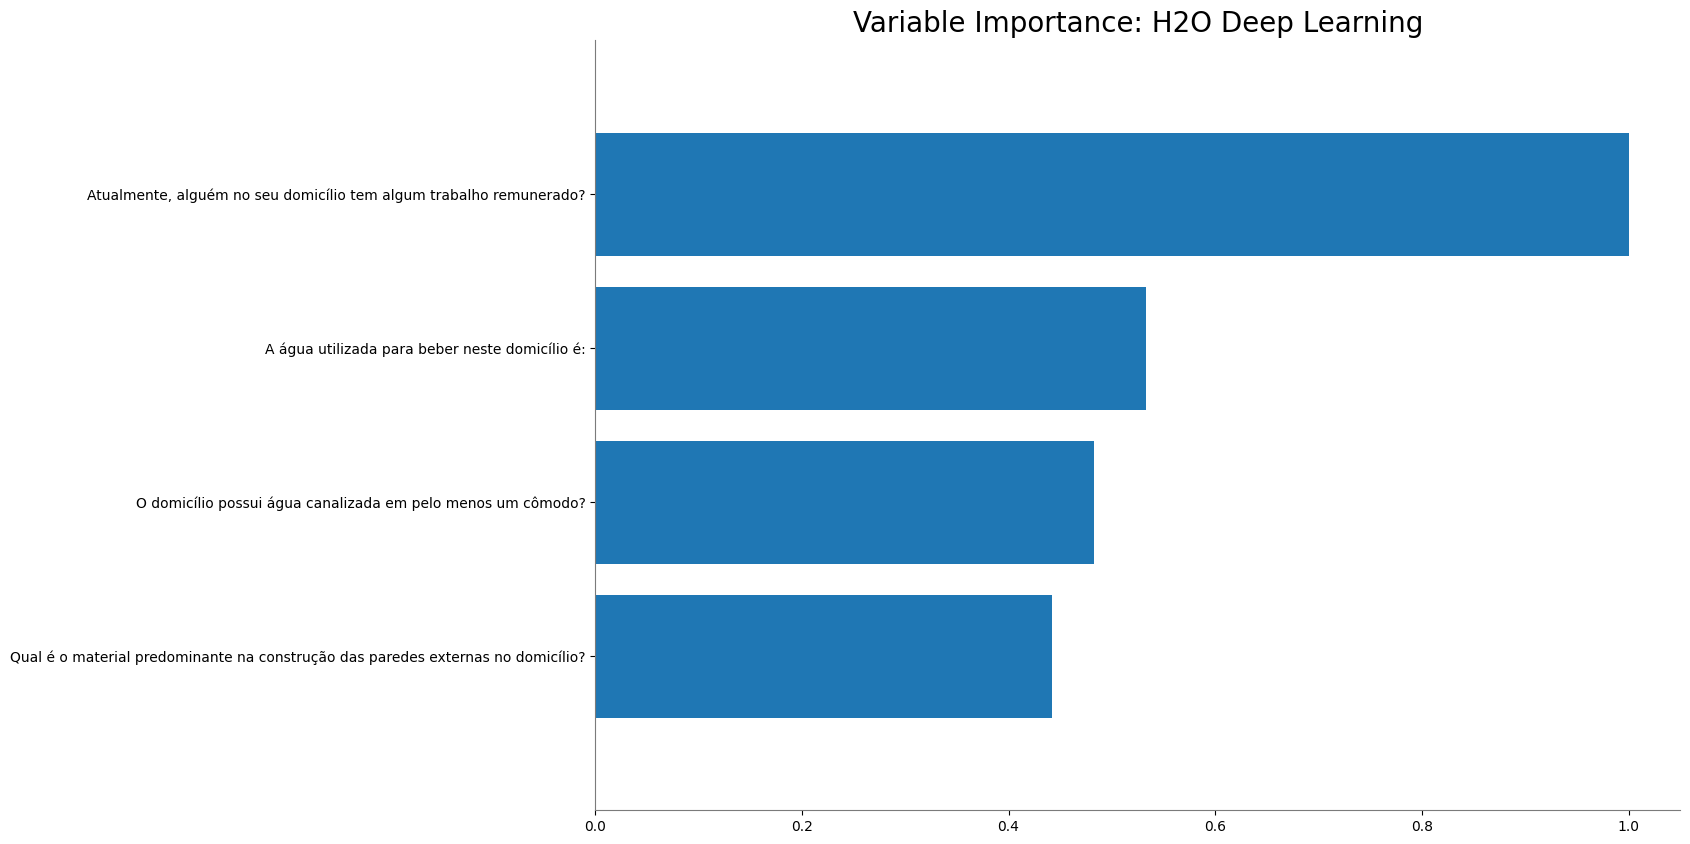

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_5

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,1,1,0,sem ia
0,0,0,1,0,moderada
1,1,1,0,0,grave
0,0,1,1,0,sem ia
0,0,0,1,0,sem ia
0,0,1,0,0,sem ia
1,0,1,1,0,sem ia
1,0,1,0,0,grave
0,0,1,1,1,moderada
0,0,1,1,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### df_SKBest_5 has accuracy: 0.31405377980720445

### Details of the best model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_5_20221022_161601_model_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    30                 120                         30643                  0            5            3.475         1             31            15.625

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.5430621143830024
RMSE: 0.7369274824451877
LogLoss: 1.3519136979197741
Mean Per-Class Error: 0.6754455544113673
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5801     2362    1267        3557      0.553323  7.186 / 12.987
3719     3549    698         5654      0.739427  10.071 / 13.620
4298     2737    1548        4404      0.880804  11.439 / 12.987
3381     2947    867         6426      0.528228  7.195 / 13.621
17199    11595   4380        20041     0.674453  35.891 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.325547
2    0.60186
3    0.819637
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.5436103251167262
RMSE: 0.737299345664111
LogLoss: 1.3534850229908708
Mean Per-Class Error: 0.6766739716151168
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5715     2362    1354        3556      0.559945  7.272 / 12.987
3664     3549    754         5653      0.739427  10.071 / 13.620
4275     2737    1574        4401      0.878802  11.413 / 12.987
3340     2947    912         6422      0.528522  7.199 / 13.621
16994    11595   4594        20032     0.675655  35.955 / 53.215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.324345
2    0.600583
3    0.816349
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.324345  0.00568967   0.320744      0.326193      0.31755       0.322059      0.322999      0.323811      0.333772      0.334712      0.320992      0.320616
auc                      nan       0            nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.675655  0.00568967   0.679256      0.673807      0.68245       0.677941      0.677001      0.676189      0.666228      0.665288      0.679008      0.679384
err_count                3595.5    30.4385      3615          3586          3632          3608          3603          3598          3545          3540          

<Figure size 640x480 with 0 Axes>

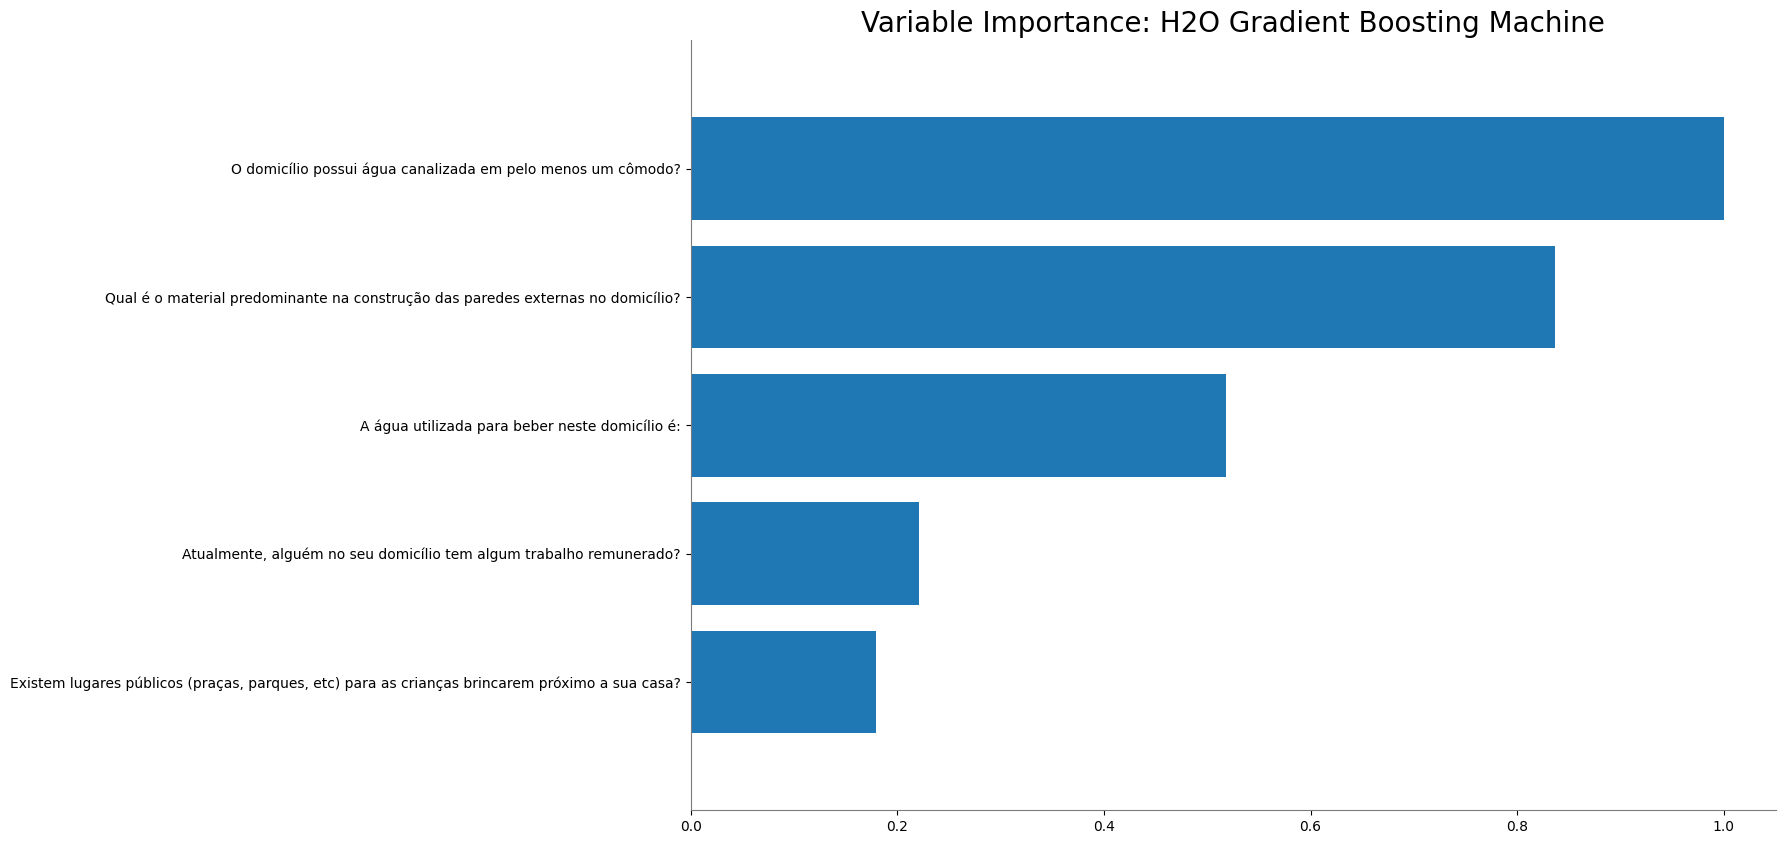

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_6

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
1,1,0,1,1,0,leve
0,1,1,0,0,0,sem ia
0,0,0,1,0,0,moderada
0,1,0,0,1,1,leve
0,0,0,0,1,0,moderada
0,1,0,0,1,0,grave
0,1,0,1,1,0,moderada
0,0,0,1,1,0,leve
1,0,0,1,1,1,leve
0,1,1,0,1,0,moderada


AutoML progress: |██████████████████████████████████████████████████████████████
18:15:34.506: StackedEnsemble_AllModels_4_AutoML_6_20221022_171616 [StackedEnsemble all_5 (built with AUTO metalearner, using all AutoML models)] failed: java.lang.RuntimeException: java.lang.AssertionError: I am really confused about the heap usage; MEM_MAX=1828716544 heapUsedGC=1934610208

█| (done) 100%

18:15:49.193: GBM_lr_annealing_selection_AutoML_6_20221022_171616 [GBM lr_annealing] failed: water.exceptions.H2OIllegalArgumentException: Can only convert jobs producing a single Model or ModelContainer.
18:15:50.739: StackedEnsemble_BestOfFamily_5_AutoML_6_20221022_171616 [StackedEnsemble best_of_family_gbm (built with gbm metalearner, using top model from each algorithm type)] failed: java.lang.RuntimeException: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: metalearner_gbm_StackedEnsemble_BestOfFamily_5_AutoML_6_20221022_171616_cv_1.  Details: ERRR on fi

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Total input file size of 7,8 KB is much larger than total cluster memory of Zero  , please use either a larger cluster or smaller data.
  Request: POST /3/Parse
    data: {'destination_frame': 'AutoML_6_20221022_171616_leaderboard', 'parse_type': 'CSV', 'separator': '44', 'check_header': '1', 'number_columns': '6', 'chunk_size': '4194304', 'delete_on_done': 'True', 'blocking': 'False', 'column_types': '["string","string","double","double","double","double"]', 'single_quotes': 'False', 'escapechar': '0', 'column_names': '["","model_id","mean_per_class_error","logloss","rmse","mse"]', 'source_frames': '["upload_ad9183789fb3f23d970d002330a14bb0"]'}


<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

In [ ]:
SKBest_12 = [8, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25]
SKBest_13 = [8, 9, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25]
SKBest_14 = [8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25]
SKBest_15 = [8, 9, 10, 11, 12, 13, 15, 8, 17, 18, 19, 20, 21, 22, 23, 25]
SKBest_16 = [8, 9, 10, 11, 12, 13, 6, 15, 8, 17, 18, 19, 20, 21, 22, 23, 25]
SKBest_17 = [8, 9, 10, 11, 12, 13, 6, 15, 8, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [ ]:
df_SKBest_12 = df[SKBest_12]
df_SKBest_13 = df[SKBest_13]
df_SKBest_14 = df[SKBest_14]
df_SKBest_15 = df[SKBest_15]
df_SKBest_16 = df[SKBest_16]
df_SKBest_17 = df[SKBest_17]

In [ ]:
feature_combinations = {
    'df_SKBest_12' : df[SKBest_12],
    'df_SKBest_13' : df[SKBest_13],
    'df_SKBest_14' : df[SKBest_14],
    'df_SKBest_15' : df[SKBest_15],
    'df_SKBest_16' : df[SKBest_16],
    'df_SKBest_17' : df[SKBest_17]
}

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_12

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",ia level
0,0,0,0,0,1,1,1,1,1,1,1,moderada
0,1,0,0,0,1,0,1,0,0,0,0,leve
0,1,1,0,1,0,1,0,1,0,0,1,sem ia
0,0,0,0,0,1,1,1,1,0,0,0,sem ia
0,0,0,0,0,1,0,1,1,0,0,0,sem ia
0,1,1,0,0,0,1,1,1,0,0,0,moderada
0,0,0,0,0,1,0,1,0,0,0,0,leve
0,1,0,0,1,1,1,1,1,0,0,0,grave
0,0,0,0,0,1,1,1,1,0,0,0,sem ia
0,1,0,0,0,1,1,1,0,0,0,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_12-DRF_1_AutoML_1_20221024_225935-acc:0.38034838491459494

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_12-DRF_1_AutoML_1_20221024_225935-acc:0.38034838491459494

### df_SKBest_12 has accuracy: 0.38034838491459494

### Details of the best model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20221024_225935


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    48                 192                         1.87531e+06            12           12           12            644           900           771.859

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.5036905335445431
RMSE: 0.7097115847614037
LogLoss: 1.4200832484173391
Mean Per-Class Error: 0.6140526461210714
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5065     2670    1949        3303      0.609995  7,922 / 12,987
2092     5363    1166        4999      0.606241  8,257 / 13,620
3125     2974    2751        4137      0.788173  10,236 / 12,987
1958     2887    1309        7467      0.451802  6,154 / 13,621
12240    13894   7175        19906     0.612027  32,569 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.387973
2    0.659138
3    0.856807
4    1

ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.503631154587285
RMSE: 0.7096697503679334
LogLoss: 1.3853008783102532
Mean Per-Class Error: 0.6159847905325257
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5026     2711    1925        3325      0.612998  7,961 / 12,987
2095     5361    1163        5001      0.606388  8,259 / 13,620
3118     2983    2723        4163      0.790329  10,264 / 12,987
1952     2923    1312        7434      0.454225  6,187 / 13,621
12191    13978   7123        19923     0.613943  32,671 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.386057
2    0.656356
3    0.857465
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.385906  0.00407609  0.394025      0.382751      0.385194      0.388388      0.379932      0.383575      0.389025      0.387521      0.382259      0.386394
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.614094  0.00407609  0.605975      0.617249      0.614807      0.611612      0.620068      0.616425      0.610975      0.612479      0.617741      0.613606
err_count                3267.9    21.6818     3225          3285          3272          3255          3300          3280          3251          3259          3287          3265
logl

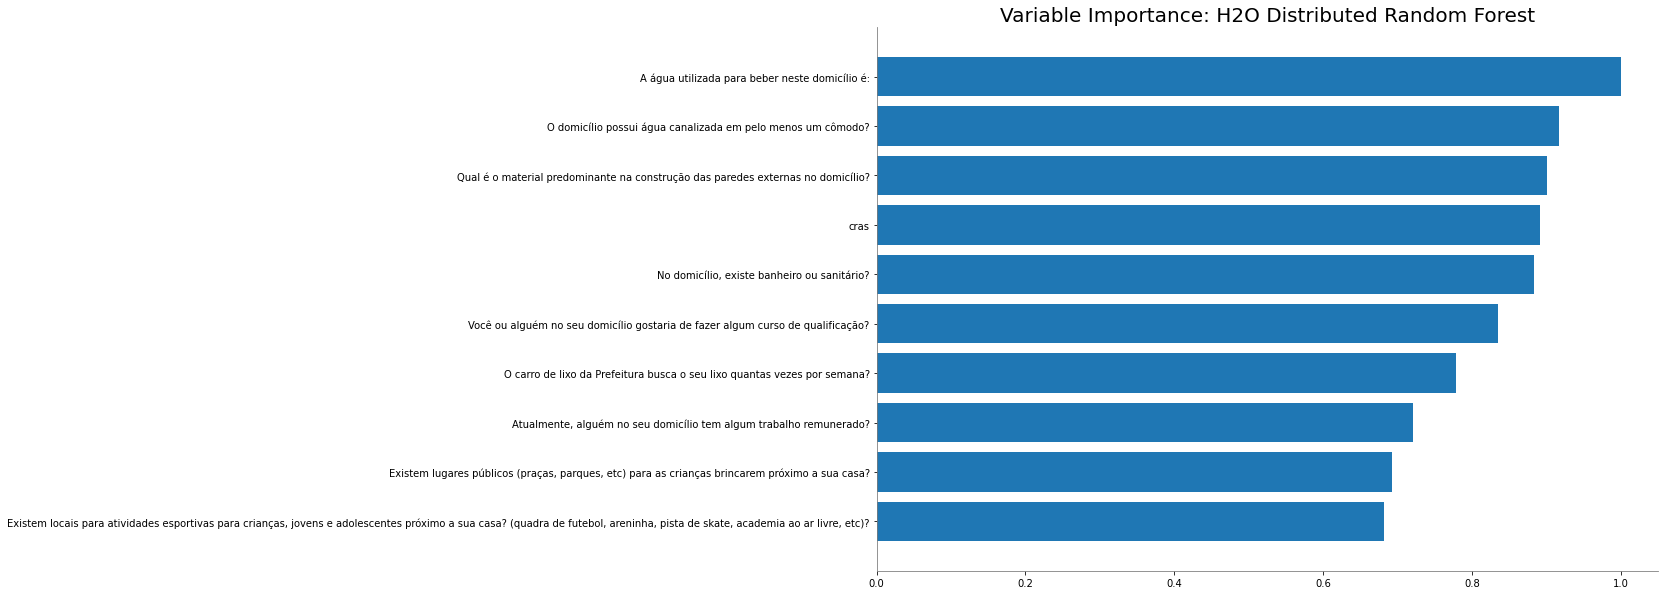

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_13

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",ia level
0,0,0,0,0,0,0,1,0,0,0,0,0,grave
0,0,1,1,0,1,0,0,0,0,0,0,0,moderada
0,0.139412,0,1,0,0,1,1,1,1,1,0,1,leve
0,0,0,0,0,0,1,1,1,1,0,0,1,grave
0,0,1,1,0,0,1,1,1,0,0,0,0,grave
0,0,0,0,0,0,1,1,1,1,0,0,1,sem ia
0,0,0,1,0,0,1,1,1,1,0,0,0,grave
1,0.167806,0,0,0,0,1,1,1,1,0,0,0,grave
1,0.166667,1,1,0,0,1,1,1,1,0,0,1,moderada
0,0,0,1,0,1,1,1,1,1,0,0,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_13-DRF_1_AutoML_2_20221025_00009-acc:0.3972602739726027

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_13-DRF_1_AutoML_2_20221025_00009-acc:0.3972602739726027

### df_SKBest_13 has accuracy: 0.3972602739726027

### Details of the best model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_2_20221025_00009


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 200                         2.95066e+06            16           20           19.185        947           1323          1166.66

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.4976615870590772
RMSE: 0.7054513357128734
LogLoss: 1.4420253406964247
Mean Per-Class Error: 0.609050071817721
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5051     2732    2043        3161      0.611073  7,936 / 12,987
2049     5512    1328        4731      0.595301  8,108 / 13,620
3118     2925    3104        3840      0.760992  9,883 / 12,987
1898     3040    1448        7235      0.468835  6,386 / 13,621
12116    14209   7923        18967     0.607216  32,313 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.392784
2    0.663591
3    0.858593
4    1

ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.4976285135746714
RMSE: 0.7054278939584622
LogLoss: 1.3770804385873168
Mean Per-Class Error: 0.6096566987058339
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5028     2736    2059        3164      0.612844  7,959 / 12,987
2064     5497    1314        4745      0.596402  8,123 / 13,620
3107     2916    3085        3879      0.762455  9,902 / 12,987
1880     3009    1471        7261      0.466926  6,360 / 13,621
12079    14158   7929        19049     0.607799  32,344 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.392201
2    0.66329
3    0.859964
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.392202  0.00402568  0.392709      0.386697      0.392522      0.386885      0.396467      0.390528      0.392783      0.395039      0.399173      0.389213
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.607798  0.00402568  0.60729       0.613303      0.607478      0.613115      0.603533      0.609472      0.607217      0.604961      0.600827      0.610787
err_count                3234.4    21.521      3232          3264          3233          3263          3212          3243          3231          3219          3197          3250
logloss 

<Figure size 432x288 with 0 Axes>

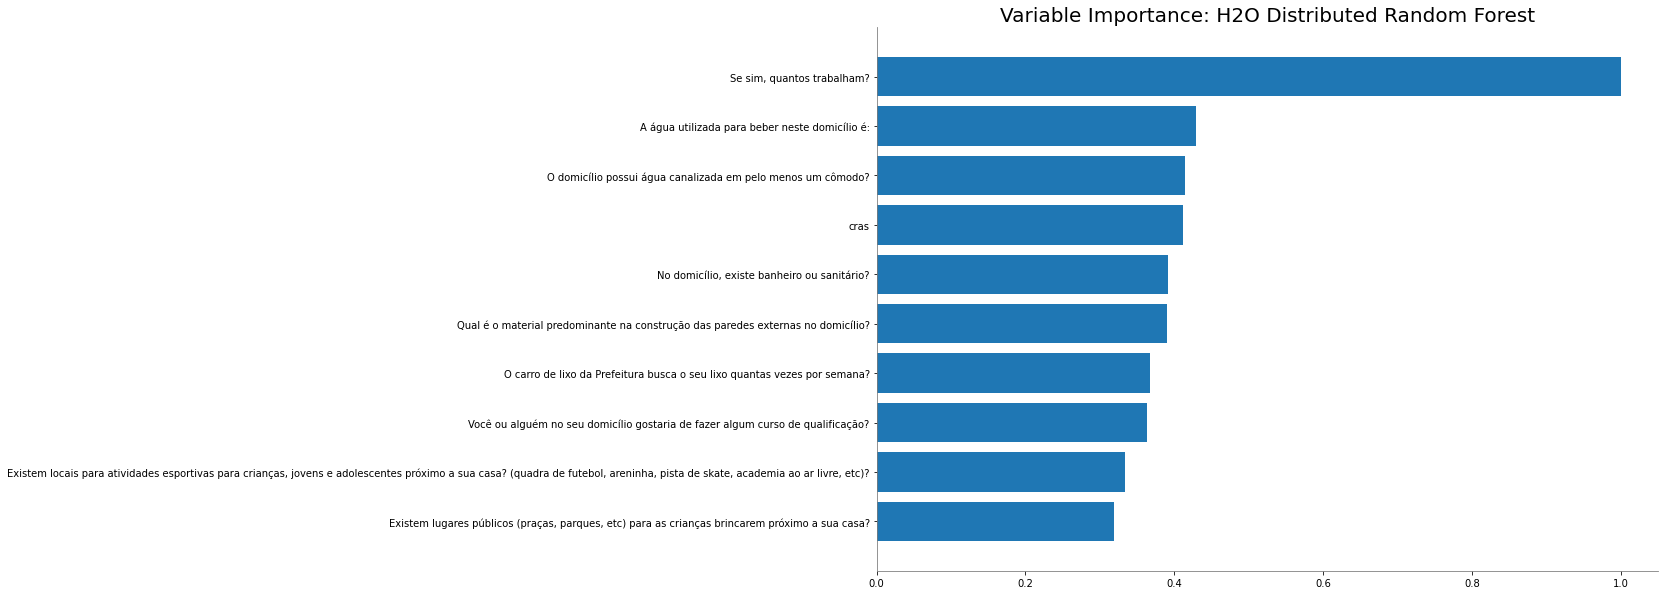

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_14

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",ia level
0,0,0.430323,0,0,0,0,1,0,1,1,0,0,0,sem ia
0,0,0.374903,1,0,0,0,0,0,1,1,1,0,0,grave
0,0,0.453795,1,0,0,0,1,0,1,0,0,1,0,moderada
0,0,0.412541,1,0,0,0,1,1,1,1,0,0,0,leve
0,0,0.270767,0,0,0,0,1,1,1,1,1,0,0,leve
1,0.166667,0.618812,0,0,0,0,0,0,1,1,1,0,1,sem ia
1,0.166667,0.316315,0,0,0,0,1,1,1,1,0,0,0,sem ia
0,0,0.418401,1,0,0,0,1,1,1,1,1,0,1,leve
0,0,0.577558,0,0,0,0,0,0,1,1,0,0,0,moderada
0,0,0.403142,1,0,0,1,0,1,1,1,0,0,0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_14-StackedEnsemble_AllModels_3_AutoML_3_20221025_10040-acc:0.5102316928800947

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_14-StackedEnsemble_AllModels_3_AutoML_3_20221025_10040-acc:0.5102316928800947

### df_SKBest_14 has accuracy: 0.5102316928800947

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_3_20221025_10040

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.36439995946167775
RMSE: 0.6036554973340984
LogLoss: 0.9636699841093205
Null degrees of freedom: 9938
Residual degrees of freedom: 9776
Null deviance: 27555.108983165905
Residual deviance: 19155.83194412507
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
686      408     1002        374       0.722267  1,784 / 2,470
66       1619    305         527       0.356774  898 / 2,517
135      215     1860        213       0.232357  563 / 2,423
85       483     321         1640      0.351522  889 / 2,529
972      2725    3488        2754      0.415937  4,134 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.584063
2    0.847168
3    0.955529
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.411228148243945
RMSE: 0.641270729289857
LogLoss: 1.10090524535695
Null degrees of freedom: 53214
Residual degrees of freedom: 53064
Null deviance: 147520.21002454523
Residual deviance: 117169.34526334018
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4132     2207    4550        2098      0.681836  8,855 / 12,987
944      7373    1982        3322      0.458703  6,248 / 13,621
2227     1388    7798        1574      0.399553  5,189 / 12,987
944      3075    2209        7392      0.457269  6,228 / 13,620
8247     14043   16539       14386     0.498356  26,520 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.501644
2    0.7885
3    0.933853
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.50164   0.00528515  0.502553      0.503041      0.501401      0.501122      0.49477       0.496467      0.500281      0.513963      0.504601      0.498199
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.49836   0.00528515  0.497447      0.496959      0.498599      0.498878      0.50523       0.503533      0.499719      0.486037      0.495399      0.501801
err_count                2652      39.1039     2630          2615          2669          2667          2705          2708          2667          2628          2584          2647
logloss                  1.10091   0.00682725  1.09399       1.10865       1.10581       1.10011       1.1107        1.10108       1.09714       1.09131       1.09367       1.10662
max_per_class_error      0.681584  0.0378039   0.668513   

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_15

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?0",O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",ia level
0,0,0.417385,0,1,0,0,0,1,1,1,1,1,1,1,grave
0,0,0.577558,1,1,0,0,0,0,1,0,0,0,0,0,grave
0,0,0.317165,1,0,0,0,0,1,1,1,1,1,0,0,leve
1,0.333333,0.907591,1,0,0,0,1,1,1,1,1,0,0,1,sem ia
0,0,0.330033,0,1,0,0,0,1,1,1,1,0,0,0,grave
0,0.148881,0.308619,0,0,0,1,0,1,1,1,1,0,0,1,sem ia
0,0,0.391089,0,1,0,0,0,1,0,1,1,0,0,0,moderada
0,0,0.581335,0,1,0,0,0,1,1,1,1,1,0,0,sem ia
0,0,0.412541,0,0,0,0,0,0,1,0,0,0,0,0,sem ia
0,0,0.412541,1,0,0,0,0,1,0,1,1,0,0,0,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_SKBest_15 has accuracy: 0.49670218163368846

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_4_20221025_20105

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3696308913916824
RMSE: 0.6079727719163766
LogLoss: 0.9776922287448767
Null degrees of freedom: 9938
Residual degrees of freedom: 9773
Null deviance: 27564.146909161507
Residual deviance: 19434.56612299066
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
725      427     904         383       0.702747  1,714 / 2,439
71       1597    309         428       0.335967  808 / 2,405
176      257     1784        332       0.300118  765 / 2,549
94       425     307         1720      0.32443   826 / 2,546
1066     2706    3304        2863      0.413824  4,113 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.586176
2    0.836704
3    0.956635
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.41842079259195686
RMSE: 0.6468545374285913
LogLoss: 1.1160617961941575
Null degrees of freedom: 53214
Residual degrees of freedom: 53054
Null deviance: 147521.22168062112
Residual deviance: 118782.45696894419
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4282     2360    4080        2265      0.670286  8,705 / 12,987
1013     7573    1653        3381      0.443979  6,047 / 13,620
2325     1746    7044        1872      0.457611  5,943 / 12,987
1055     3067    1812        7687      0.435651  5,934 / 13,621
8675     14746   14589       15205     0.500404  26,629 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.499596
2    0.781189
3    0.928498
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.499621  0.0085118   0.504634      0.496769      0.496357      0.485784      0.496451      0.512272      0.503279      0.494359      0.512653      0.493649
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.500379  0.0085118   0.495366      0.503231      0.503643      0.514216      0.503549      0.487728      0.496721      0.505641      0.487347      0.506351
err_count                2662.9    60.759      2619          2648          2696          2749          2696          2623          2651          2734          2542          2671
logloss                  1.11602   0.0094111   1.10996       1.11271       1.11833       1.12631       1.12967       1.10079       1.11409       1.12512       1.10473       1.11848
max_per_class_error      0.669719  0.0370148   0.657

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_16

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Você cria animais que são utilizados para consumo da sua família?,Qual é o material predominante na construção das paredes externas no domicílio?,"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?0",O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",ia level
0,0,0.610561,1,0,0,1,1,0,0,0,0,0,0,0,0,grave
0,0,0.412541,1,0,0,0,0,0,1,1,1,0,0,0,0,leve
0,0,0.330388,1,1,0,0,1,0,1,1,1,1,0,0,0,sem ia
0,0.225341,0.789619,0,0,0,1,0,0,0,1,1,1,0,0,0,sem ia
0,0,0.536304,0,0,0,0,0,0,0,1,1,0,0,0,0,moderada
0,0,0.277228,1,1,0,0,0,0,1,1,1,0,0,0,0,moderada
0,0,0.412541,1,0,0,0,1,0,1,1,1,1,0,0,1,moderada
0,0,0.502202,1,0,0,0,0,0,1,0,1,1,1,0,1,grave
0,0,0.237,0,0,0,0,1,0,1,0,1,1,0,0,0,leve
0,0,0.412541,1,0,0,0,0,0,0,1,1,1,0,0,0,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_16-StackedEnsemble_AllModels_1_AutoML_5_20221025_30134-acc:0.5308641975308642

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_16-StackedEnsemble_AllModels_1_AutoML_5_20221025_30134-acc:0.5308641975308642

### df_SKBest_16 has accuracy: 0.5308641975308642

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_5_20221025_30134

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3239799937307766
RMSE: 0.5691924048428411
LogLoss: 0.8685266123829349
Null degrees of freedom: 9940
Residual degrees of freedom: 9851
Null deviance: 27560.46867725896
Residual deviance: 17268.046107397517
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1199     330     617         328       0.51536   1,275 / 2,474
87       1887    225         293       0.242777  605 / 2,492
299      281     1589        249       0.342845  829 / 2,418
107      323     321         1806      0.293704  751 / 2,557
1692     2821    2752        2676      0.348054  3,460 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.651946
2    0.863193
3    0.962881
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4062166424857225
RMSE: 0.6373512708747998
LogLoss: 1.0934802363156189
Null degrees of freedom: 53214
Residual degrees of freedom: 53130
Null deviance: 147519.17715787305
Residual deviance: 116379.1015510713
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4654     2404    3898        2031      0.641642  8,333 / 12,987
1008     8165    1592        2856      0.400558  5,456 / 13,621
2395     1944    7049        1599      0.457226  5,938 / 12,987
1011     3127    1842        7640      0.43906   5,980 / 13,620
9068     15640   14381       14126     0.483078  25,707 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.516922
2    0.791863
3    0.932575
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.516905  0.00589054  0.522972      0.514725      0.511211      0.516183      0.526896      0.511252      0.51602       0.521176      0.508247      0.520371
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.483095  0.00589054  0.477028      0.485275      0.488789      0.483817      0.473104      0.488748      0.48398       0.478824      0.491753      0.479629
err_count                2570.7    35.9816     2523          2554          2616          2586          2533          2628          2583          2589          2564          2531
logloss                  1.09348   0.0114705   1.08448       1.08326       1.10308       1.10919       1.07187       1.09317       1.09446       1.09909       1.10575       1.0904
max_per_class_error      0.64162   0.0157378   0.645038

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_17

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Você cria animais que são utilizados para consumo da sua família?,Qual é o material predominante na construção das paredes externas no domicílio?,"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?0",O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.25775,1,0,0,1,0,0,1,1,1,0,0,0,0,1,leve
0,0,0.412541,0,1,0,0,0,0,1,1,1,1,1,0,1,1,grave
0,0,0.344547,0,0,0,0,0,0,1,0,1,1,0,0,0,1,grave
0,0,0.38347,0,0,0,1,0,0,0,1,0,1,1,0,0,1,grave
0,0,0.411776,1,0,0,1,0,0,1,1,1,1,0,0,0,1,leve
0,0,0.311881,1,1,0,0,0,0,0,0,1,1,0,0,0,1,grave
0,0,0.412541,1,0,0,0,0,0,0,1,1,0,0,0,0,1,leve
1,0.28427,0.497705,1,1,0,1,0,1,0,0,0,0,0,0,0,1,sem ia
0,0,0.412541,1,0,0,0,0,0,1,1,1,0,0,0,0,1,sem ia
0,0,0.478742,1,0,0,0,0,0,1,0,1,1,0,0,0,1,sem ia


AutoML progress: |██████████████████████████████████████████████████████████

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

## F_Classif

In [ ]:
SKBest_fclassif_1 = [17, 25]
SKBest_fclassif_2 = [15, 17, 25]
SKBest_fclassif_3 = [10, 15, 17, 25]
SKBest_fclassif_4 = [10, 15, 17, 19, 25]


In [ ]:
df_SKBest_fclassif_1 = df[SKBest_fclassif_1]
df_SKBest_fclassif_2 = df[SKBest_fclassif_2]
df_SKBest_fclassif_3 = df[SKBest_fclassif_3]
df_SKBest_fclassif_4 = df[SKBest_fclassif_4]


In [ ]:
feature_combinations = {
    'df_SKBest_fclassif_1' : df[SKBest_fclassif_1],
    'df_SKBest_fclassif_2' : df[SKBest_fclassif_2],
    'df_SKBest_fclassif_3' : df[SKBest_fclassif_3],
    'df_SKBest_fclassif_4' : df[SKBest_fclassif_4],

}


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_1

O domicílio possui água canalizada em pelo menos um cômodo?,ia level
1,moderada
0,grave
1,moderada
0,sem ia
1,leve
1,moderada
1,grave
1,sem ia
0,leve
1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_1-DeepLearning_grid_1_AutoML_1_20221025_125611_model_2-acc:0.289193302891933

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_1-DeepLearning_grid_1_AutoML_1_20221025_125611_model_2-acc:0.289193302891933

### df_SKBest_fclassif_1 has accuracy: 0.289193302891933

### Details of the best model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20221025_125611_model_2


Status of Neuron Layers: predicting ia level, 4-class classification, multinomial distribution, CrossEntropy loss, 604 weights/biases, 11.2 KB, 3,099,825 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  --------------------  ----------  ---------------------  -------------------  -------------------  -------------------
    1        1        Input             0.0
    2        100      RectifierDropout  20.0       0.0   0.0   0.004664851104316767  0.010958902537822723  0.0         -0.002499007188316682  0.11566635966300964  0.05987182196716817  0.1620781421661377
    3        4        Softmax                      0.0   0.0   0.055732875895082544  0.037970930337905884  0.0         -2.8278928517270834    2.316761016845703    -28.56001982781223   0.05642993748188019

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.5549678366869775
RMSE: 0.7449616343725208
LogLoss: 1.3748607061238507
Mean Per-Class Error: 0.7099127602752555
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
901      1512    0           0         0.626606  1,512 / 2,413
552      2039    0           0         0.213045  552 / 2,591
667      1725    0           0         1         2,392 / 2,392
500      2046    0           0         1         2,546 / 2,546
2620     7322    0           0         0.704285  7,002 / 9,942

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.295715
2    0.568598
3    0.797626
4    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.5551739773874537
RMSE: 0.7450999781153222
LogLoss: 1.374120283812744
Mean Per-Class Error: 0.7050488783399864
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4794     836     0           7357      0.630862  8,193 / 12,987
2842     1133    0           9645      0.916814  12,487 / 13,620
3613     931     0           8443      1         12,987 / 12,987
2621     1091    0           9909      0.27252   3,712 / 13,621
13870    3991    0           35354     0.702415  37,379 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.297585
2    0.567227
3    0.796787
4    1

Cross-Validation Metrics Summary: 
                         mean      sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.297585  0.00422823   0.294062      0.300263      0.297069      0.29876       0.290116      0.298252      0.30389  

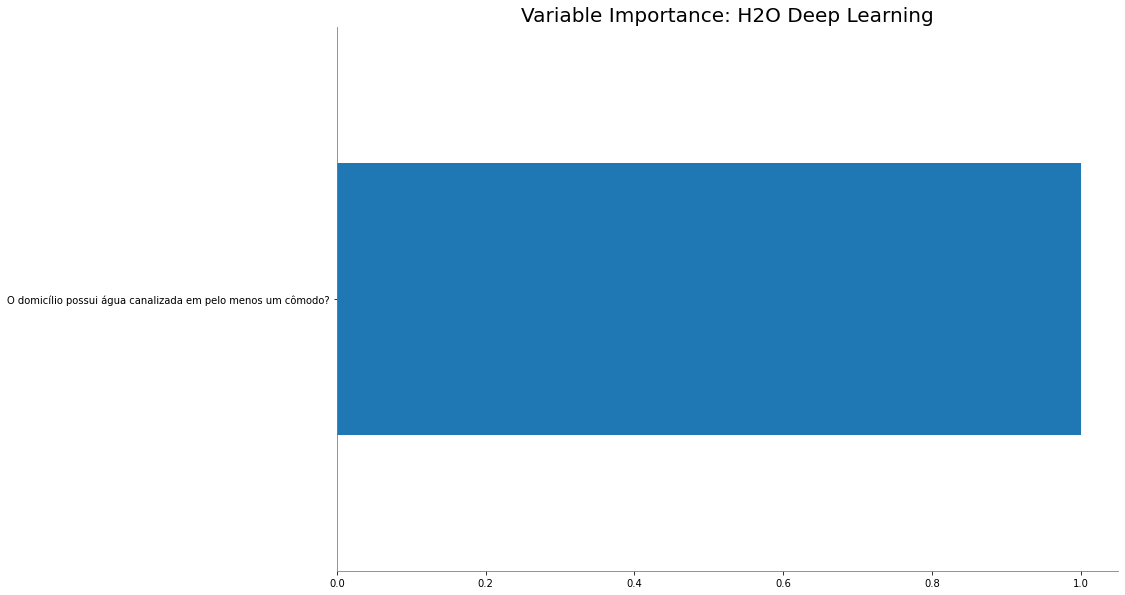

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_2

Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,ia level
0,1,grave
0,1,grave
1,0,grave
0,1,leve
0,1,grave
1,1,grave
0,1,leve
0,1,leve
0,0,leve
1,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_2-DRF_1_AutoML_2_20221025_135616-acc:0.3105022831050228

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_2-DRF_1_AutoML_2_20221025_135616-acc:0.3105022831050228

### df_SKBest_fclassif_2 has accuracy: 0.3105022831050228

### Details of the best model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_2_20221025_135616


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    28                 112                         12166                  2            2            2             4             4             4

ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.5498964798216496
RMSE: 0.741550052135154
LogLoss: 1.366096598436159
Mean Per-Class Error: 0.6916580550391124
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4783     0       1744        6460      0.631709  8,204 / 12,987
2828     0       1295        9498      1         13,621 / 13,621
3591     0       1874        7522      0.855702  11,113 / 12,987
2630     0       1173        9817      0.279222  3,803 / 13,620
13832    0       6086        33297     0.690426  36,741 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.309574
2    0.588312
3    0.807141
4    1

ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.5498969680135931
RMSE: 0.7415503813050015
LogLoss: 1.366084546613904
Mean Per-Class Error: 0.6916580550391124
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4783     0       1744        6460      0.631709  8,204 / 12,987
2828     0       1295        9498      1         13,621 / 13,621
3591     0       1874        7522      0.855702  11,113 / 12,987
2630     0       1173        9817      0.279222  3,803 / 13,620
13832    0       6086        33297     0.690426  36,741 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.309574
2    0.588312
3    0.807141
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.309574  0.00666172  0.316047      0.306464      0.313604      0.304397      0.313604      0.314415      0.294869      0.31479       0.311971      0.305582
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.690426  0.00666172  0.683953      0.693536      0.686396      0.695603      0.686396      0.685585      0.705131      0.68521       0.688029      0.694418
err_count                3674.1    35.3787     3640          3691          3653          3702          3653          3648          3752          3646          3661          3695
logloss   

<Figure size 432x288 with 0 Axes>

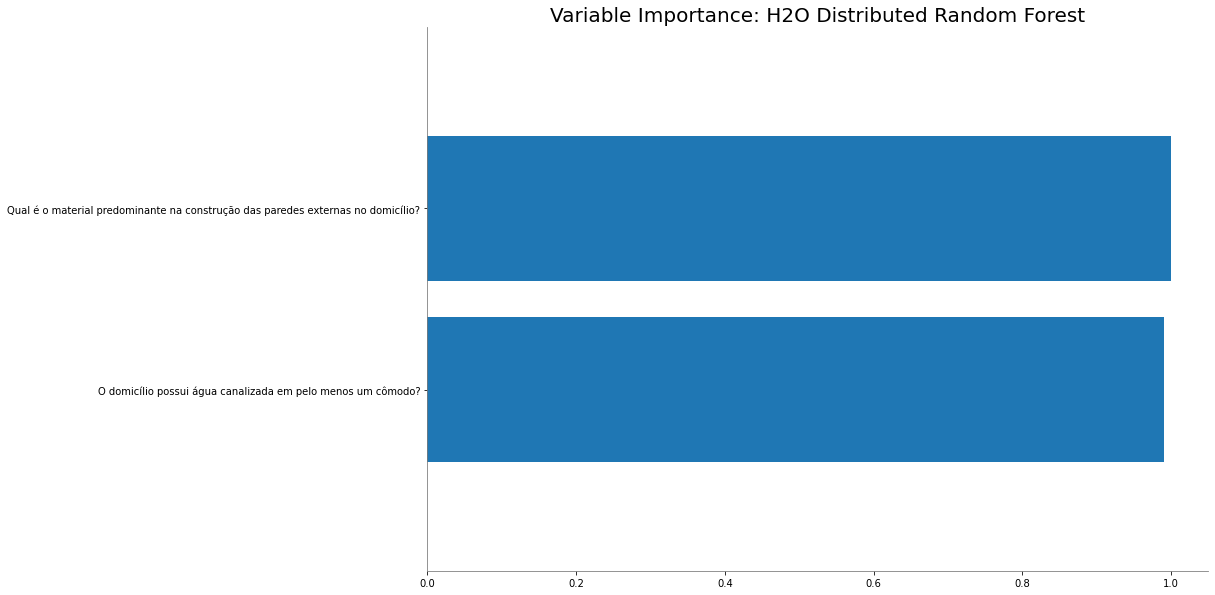

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_3

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,ia level
0.189769,0,1,grave
0.412541,0,0,leve
0.39604,0,0,grave
0.479436,0,1,leve
0.403596,0,1,sem ia
0.412541,0,1,sem ia
0.462819,1,0,grave
0.412541,0,0,moderada
0.629536,0,1,leve
0.49505,0,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_3-StackedEnsemble_AllModels_3_AutoML_3_20221025_145756-acc:0.42364282090309485

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_3-StackedEnsemble_AllModels_3_AutoML_3_20221025_145756-acc:0.42364282090309485

### df_SKBest_fclassif_3 has accuracy: 0.42364282090309485

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_3_20221025_145756

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4497026993258037
RMSE: 0.6705987617985912
LogLoss: 1.1653892562233623
Null degrees of freedom: 9938
Residual degrees of freedom: 9799
Null deviance: 27548.436776626168
Residual deviance: 23165.607635207994
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
354      411     1309        324       0.852377  2,044 / 2,398
119      876     734         853       0.660728  1,706 / 2,582
234      25      2061        105       0.150103  364 / 2,425
114      711     667         1042      0.588792  1,492 / 2,534
821      2023    4771        2324      0.564041  5,606 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.435959
2    0.764966
3    0.921421
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4566923332418735
RMSE: 0.6757901547387869
LogLoss: 1.185237996057013
Null degrees of freedom: 53214
Residual degrees of freedom: 53088
Null deviance: 147522.40079420054
Residual deviance: 126144.8799203479
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
2392     2921    6640        1034      0.815816  10,595 / 12,987
962      6350    3822        2487      0.533808  7,271 / 13,621
1797     387     10235       568       0.211904  2,752 / 12,987
819      5487    3708        3606      0.735242  10,014 / 13,620
5970     15145   24405       7695      0.575627  30,632 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.424373
2    0.750352
3    0.914573
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.424351  0.00729081  0.414413      0.423793      0.421072      0.438085      0.426784      0.434176      0.425707      0.417052      0.420054      0.42237
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.575649  0.00729081  0.585587      0.576207      0.578928      0.561915      0.573216      0.565824      0.574293      0.582948      0.579946      0.57763
err_count                3063.2    43.3174     3096          3032          3099          3004          3069          3043          3065          3152          3025          3047
logloss                  1.18524   0.00419301  1.18943       1.18617       1.1847        1.17436       1.18378       1.18784       1.1866        1.18775       1.18459       1.18718
max_per_class_error      0.815972  0.00907988  0.

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_4

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,"No domicílio, existe banheiro ou sanitário?",ia level
0.157591,0,1,1,moderada
0.288779,0,1,1,moderada
0.412541,1,0,1,moderada
0.393564,1,0,0,sem ia
0.437294,0,0,0,moderada
0.412541,0,1,1,sem ia
0.412541,0,0,1,moderada
0.348643,0,1,1,sem ia
0.254125,0,0,0,grave
0.330033,0,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_4-StackedEnsemble_AllModels_3_AutoML_4_20221025_155843-acc:0.42905462540165734

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_4-StackedEnsemble_AllModels_3_AutoML_4_20221025_155843-acc:0.42905462540165734

### df_SKBest_fclassif_4 has accuracy: 0.42905462540165734

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_4_20221025_155843

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4425490180971004
RMSE: 0.6652435780201869
LogLoss: 1.1514418919289877
Null degrees of freedom: 9938
Residual degrees of freedom: 9805
Null deviance: 27549.210558072566
Residual deviance: 22888.361927764417
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
273      378     1451        298       0.88625   2,127 / 2,400
45       785     740         928       0.685749  1,713 / 2,498
124      21      2175        111       0.105306  256 / 2,431
58       558     785         1209      0.536782  1,401 / 2,610
500      1742    5151        2546      0.553074  5,497 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.446926
2    0.773518
3    0.923634
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4547628342794906
RMSE: 0.6743610563188615
LogLoss: 1.1823399908842334
Null degrees of freedom: 53214
Residual degrees of freedom: 53099
Null deviance: 147517.3691738057
Residual deviance: 125836.44522980895
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
2465     3057    6375        1090      0.810195  10,522 / 12,987
950      6457    3548        2666      0.525953  7,164 / 13,621
1648     801     9955        583       0.233464  3,032 / 12,987
740      5410    3550        3920      0.712188  9,700 / 13,620
5803     15725   23428       8259      0.571606  30,418 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.428394
2    0.754731
3    0.912957
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.42837   0.0073778   0.434651      0.429685      0.420699      0.434718      0.431827      0.437523      0.427581      0.428704      0.425613      0.412701
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.57163   0.0073778   0.565349      0.570315      0.579301      0.565282      0.568173      0.562477      0.572419      0.571296      0.574387      0.587299
err_count                3041.8    42.5436     2989          3001          3101          3022          3042          3025          3055          3089          2996          3098
logloss                  1.18234   0.00640466  1.17274       1.1846        1.19261       1.17568       1.18249       1.17468       1.18282       1.18572       1.18254       1.18953
max_per_class_error      0.810054  0.00770804  

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_5

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0.354785,0,1,0,1,leve
0.301749,1,1,0,1,leve
0.261889,0,1,0,1,leve
0.878427,0,1,1,1,sem ia
0.123762,0,0,1,1,grave
0.412541,0,0,0,1,grave
0.447152,0,1,1,1,grave
0.258615,0,1,1,1,grave
0.330033,0,1,1,1,sem ia
0.412541,1,0,0,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_5-StackedEnsemble_AllModels_3_AutoML_5_20221025_165927-acc:0.4346355487907999

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_5-StackedEnsemble_AllModels_3_AutoML_5_20221025_165927-acc:0.4346355487907999

### df_SKBest_fclassif_5 has accuracy: 0.4346355487907999

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_5_20221025_165927

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.43689767809398994
RMSE: 0.6609823583833307
LogLoss: 1.1355093196173076
Null degrees of freedom: 9938
Residual degrees of freedom: 9779
Null deviance: 27547.963221589987
Residual deviance: 22571.654255352838
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
358      312     1377        386       0.852857   2,075 / 2,433
69       756     732         1009      0.705378   1,810 / 2,566
113      27      2149        96        0.0989518  236 / 2,385
87       515     688         1265      0.504892   1,290 / 2,555
627      1610    4946        2756      0.544421   5,411 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.455579
2    0.788007
3    0.932488
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.45153264038126506
RMSE: 0.6719617849113632
LogLoss: 1.177967512562281
Null degrees of freedom: 53214
Residual degrees of freedom: 53089
Null deviance: 147521.62998349522
Residual deviance: 125371.08236200358
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3466     3406    4663        1452      0.733118  9,521 / 12,987
1378     7099    1877        3267      0.478819  6,522 / 13,621
2395     2006    7922        664       0.390005  5,065 / 12,987
1045     5564    2266        4745      0.651615  8,875 / 13,620
8284     18075   16728       10128     0.563431  29,983 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.436569
2    0.755332
3    0.919308
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.436536  0.0056078   0.439569      0.435576      0.433215      0.435466      0.441539      0.439011      0.432078      0.443869      0.424655      0.440379
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.563464  0.0056078   0.560431      0.564424      0.566785      0.564534      0.558461      0.560989      0.567922      0.556131      0.575345      0.559621
err_count                2998.3    28.7211     2963          2970          3034          3018          2990          3017          3031          3007          3001          2952
logloss                  1.17799   0.00856276  1.16401       1.18812       1.1892        1.17483       1.17986       1.17711       1.17984       1.16763       1.18693       1.1724
max_per_class_error      0.733107  0.013

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_6

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0,0.410622,0,1,1,1,sem ia
0.245346,0.630331,0,1,1,1,sem ia
0,0.412541,0,1,1,1,leve
0,0.38762,0,1,1,1,leve
0,0.412541,1,0,1,1,leve
0.166667,0.000825083,0,1,1,1,sem ia
0.166667,0.49505,1,1,0,1,moderada
0,0.418677,1,1,1,1,sem ia
0,0.301155,0,1,0,1,leve
0,0.337185,0,1,1,1,grave


AutoML progress: |█████ (cancelled)

18:03:00.25: Empty leaderboard.
AutoML was not able to build any model within a max runtime constraint of 3600 seconds, you may want to increase this value before retrying.



H2OJobCancelled: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

In [ ]:
SKBest_fclassif_5 = [10, 15, 17, 18, 19, 25]
SKBest_fclassif_6 = [9, 10, 15, 17, 18, 19, 25]
SKBest_fclassif_7 = [8, 9, 10, 15, 17, 18, 19, 25]

In [ ]:
df_SKBest_fclassif_5 = df[SKBest_fclassif_5]
df_SKBest_fclassif_6 = df[SKBest_fclassif_6]
df_SKBest_fclassif_7 = df[SKBest_fclassif_7]

In [ ]:
feature_combinations = {
    'df_SKBest_fclassif_5' : df[SKBest_fclassif_5],
    'df_SKBest_fclassif_6' : df[SKBest_fclassif_6],
    'df_SKBest_fclassif_7' : df[SKBest_fclassif_7]
}


In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_5

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0.257426,1,1,1,1,moderada
0.412541,0,0,0,1,moderada
0.518901,0,1,1,1,leve
0.742574,0,1,0,1,leve
0.415029,0,1,1,1,grave
0.363307,1,0,1,1,leve
0.412541,0,1,1,1,leve
0.453691,0,1,1,1,sem ia
0.330033,0,1,1,1,grave
0.189769,1,1,1,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_5-StackedEnsemble_AllModels_3_AutoML_1_20221025_180644-acc:0.42837814983933703

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_5-StackedEnsemble_AllModels_3_AutoML_1_20221025_180644-acc:0.42837814983933703

### df_SKBest_fclassif_5 has accuracy: 0.42837814983933703

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221025_180644

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.438146478499396
RMSE: 0.6619263391793652
LogLoss: 1.1369664695807096
Null degrees of freedom: 9938
Residual degrees of freedom: 9779
Null deviance: 27552.064663150795
Residual deviance: 22600.619482325346
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
366      331     1357        412       0.851582  2,100 / 2,466
64       838     737         932       0.674057  1,733 / 2,571
142      18      2140        95        0.106472  255 / 2,395
75       502     710         1220      0.513363  1,287 / 2,507
647      1689    4944        2659      0.540799  5,375 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.459201
2    0.782473
3    0.933394
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.45123767999621833
RMSE: 0.6717422720033468
LogLoss: 1.177903988001459
Null degrees of freedom: 53214
Residual degrees of freedom: 53073
Null deviance: 147519.7005121449
Residual deviance: 125364.32144299528
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3577     2990    4855        1565      0.724571  9,410 / 12,987
1427     6225    2375        3593      0.542952  7,395 / 13,620
2454     1542    8334        657       0.358281  4,653 / 12,987
1079     4777    2666        5099      0.625652  8,522 / 13,621
8537     15534   18230       10914     0.563375  29,980 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.436625
2    0.755482
3    0.917899
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.436617  0.00445506  0.438812      0.442417      0.429479      0.43453       0.433881      0.439383      0.436387      0.443869      0.433474      0.433934
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.563383  0.00445506  0.561188      0.557583      0.570521      0.565469      0.566119      0.560617      0.563612      0.556131      0.566526      0.566066
err_count                2998      37.0735     2967          2934          3054          3023          3031          3015          3008          3007          2955          2986
logloss                  1.17788   0.00606836  1.17396       1.16709       1.18723       1.18099       1.18243       1.17888       1.18384       1.17249       1.17385       1.17801
max_per_class_error      0.724507  0.0119028   0.

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_6

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0,0.206271,0,0,0,1,grave
0,0.437571,0,1,0,1,grave
0,0.412541,0,1,1,1,sem ia
0,0.325723,0,1,1,1,leve
0,0.231023,0,1,1,1,moderada
0,0.412541,1,0,1,1,moderada
0.166667,0.943788,0,1,1,1,sem ia
0,0.495875,0,1,1,1,grave
0,0.412541,1,1,0,1,leve
0,0.529093,0,1,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_6-StackedEnsemble_AllModels_3_AutoML_2_20221025_190706-acc:0.4437679688821241

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_6-StackedEnsemble_AllModels_3_AutoML_2_20221025_190706-acc:0.4437679688821241

### df_SKBest_fclassif_6 has accuracy: 0.4437679688821241

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20221025_190706

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4199564146177796
RMSE: 0.6480404421159065
LogLoss: 1.096511437351873
Null degrees of freedom: 9938
Residual degrees of freedom: 9766
Null deviance: 27550.821291280405
Residual deviance: 21796.454351680535
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
427      331     1302        332       0.821488   1,965 / 2,392
61       909     735         843       0.64325    1,639 / 2,548
129      26      2223        78        0.0948697  233 / 2,456
70       527     698         1248      0.509241   1,295 / 2,543
687      1793    4958        2501      0.51635    5,132 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.48365
2    0.797263
3    0.939732
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4456187371383969
RMSE: 0.667546805204247
LogLoss: 1.1664763120782615
Null degrees of freedom: 53214
Residual degrees of freedom: 53038
Null deviance: 147517.55259699118
Residual deviance: 124148.07389448937
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3436     3067    4923        1561      0.735428  9,551 / 12,987
1372     6730    2129        3390      0.50591   6,891 / 13,621
2389     1594    8292        712       0.361515  4,695 / 12,987
1059     4983    2521        5057      0.628708  8,563 / 13,620
8256     16374   17865       10720     0.558113  29,700 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.441887
2    0.760049
3    0.920643
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.441896  0.00467091  0.447513      0.445838      0.441248      0.433221      0.445648      0.437523      0.446318      0.442205      0.442101      0.437346
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.558104  0.00467091  0.552487      0.554162      0.558752      0.566779      0.554352      0.562477      0.553682      0.557795      0.557899      0.562654
err_count                2970      45.1319     2921          2916          2991          3030          2968          3025          2955          3016          2910          2968
logloss                  1.16647   0.00396302  1.16298       1.16093       1.16598       1.16936       1.16571       1.17205       1.17183       1.16153       1.1686        1.16576
max_per_class_error      0.735407  0.015126

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_7

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0,0,0.484348,0,1,1,1,leve
0,0,0.00121782,0,0,0,1,moderada
0,0,0.237624,0,1,0,1,moderada
0,0,0.09934,0,1,0,1,sem ia
0,0,0.412541,1,0,1,0,sem ia
1,0.166667,0.269831,0,1,1,1,leve
0,0,0.412541,0,1,1,1,grave
0,0,0.330033,0,0,0,1,grave
0,0,0.412541,0,0,0,0,moderada
1,0.166667,0.447407,0,1,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_7-StackedEnsemble_AllModels_3_AutoML_3_20221025_200728-acc:0.44647387113140535

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_7-StackedEnsemble_AllModels_3_AutoML_3_20221025_200728-acc:0.44647387113140535

### df_SKBest_fclassif_7 has accuracy: 0.44647387113140535

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_3_20221025_200728

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.42431897899309945
RMSE: 0.6513977118420815
LogLoss: 1.1059831610187951
Null degrees of freedom: 9938
Residual degrees of freedom: 9749
Null deviance: 27553.581243333807
Residual deviance: 21984.73327473161
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
313      355     1390        355       0.870286  2,100 / 2,413
44       857     713         898       0.658838  1,655 / 2,512
115      33      2191        125       0.110795  273 / 2,464
65       494     668         1323      0.481176  1,227 / 2,550
537      1739    4962        2701      0.528725  5,255 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.471275
2    0.800584
3    0.934098
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4461516035039345
RMSE: 0.6679458088078213
LogLoss: 1.1674948223582735
Null degrees of freedom: 53214
Residual degrees of freedom: 53027
Null deviance: 147520.64019400816
Residual deviance: 124256.47394359103
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3551     2831    5046        1559      0.726573  9,436 / 12,987
1357     6381    2490        3392      0.531498  7,239 / 13,620
2405     1371    8505        706       0.345114  4,482 / 12,987
1047     4804    2802        4968      0.635269  8,653 / 13,621
8360     15387   18843       10625     0.56018   29,810 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.43982
2    0.759992
3    0.9213
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.439829  0.00796106  0.435029      0.437096      0.449654      0.438833      0.453866      0.433061      0.438823      0.432217      0.448236      0.431469
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.560171  0.00796106  0.564971      0.562904      0.550346      0.561167      0.546134      0.566939      0.561177      0.567782      0.551764      0.568531
err_count                2981      56.6726     2987          2962          2946          3000          2924          3049          2995          3070          2878          2999
logloss                  1.16751   0.00922688  1.17724       1.17051       1.15199       1.17877       1.15436       1.1644        1.1633        1.17706       1.16919       1.16828
max_per_class_error      0.726491  0.0103937   0.7

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_8

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
1,0.166667,0.661716,0,1,0,0,0,leve
0,0,0.412541,0,0,1,1,1,leve
0,0.115171,0.412541,0,0,1,0,1,leve
1,0.166667,0.857046,0,0,1,1,1,sem ia
0,0,0.577558,1,0,0,1,1,moderada
0,0,0.412541,0,0,1,1,1,grave
0,0,0.412541,1,0,1,1,1,grave
0,0,0.412541,0,0,1,1,1,sem ia
1,0.166667,0.330033,1,0,0,0,0,grave
1,0.166667,0.907591,1,0,0,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_8-StackedEnsemble_AllModels_3_AutoML_4_20221025_210748-acc:0.46101809572129204

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_8-StackedEnsemble_AllModels_3_AutoML_4_20221025_210748-acc:0.46101809572129204

### df_SKBest_fclassif_8 has accuracy: 0.46101809572129204

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_4_20221025_210748

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4074659089505399
RMSE: 0.6383305640109519
LogLoss: 1.06553339036806
Null degrees of freedom: 9938
Residual degrees of freedom: 9736
Null deviance: 27551.775890064528
Residual deviance: 21180.672733736294
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
496      460     1037        389       0.791772  1,886 / 2,382
89       1325    332         783       0.476078  1,204 / 2,529
157      267     1850        202       0.252827  626 / 2,476
89       653     379         1431      0.439263  1,121 / 2,552
831      2705    3598        2805      0.486669  4,837 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.513331
2    0.817688
3    0.946373
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4443340008644486
RMSE: 0.66658382883509
LogLoss: 1.16713946961646
Null degrees of freedom: 53214
Residual degrees of freedom: 53033
Null deviance: 147519.3211637229
Residual deviance: 124218.65375127984
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3670     2981    4482        1854      0.71741   9,317 / 12,987
1240     6961    1801        3619      0.488951  6,660 / 13,621
2224     1764    7756        1243      0.402787  5,231 / 12,987
1006     4546    2160        5908      0.566226  7,712 / 13,620
8140     16252   16199       12624     0.543456  28,920 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.456544
2    0.762586
3    0.920417
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.456516  0.00808163  0.454133      0.462372      0.467588      0.458661      0.458909      0.466344      0.449316      0.448863      0.442101      0.456872
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.543484  0.00808163  0.545867      0.537628      0.532412      0.541339      0.541091      0.533656      0.550684      0.551137      0.557899      0.543128
err_count                2892      43.8279     2886          2829          2850          2894          2897          2870          2939          2980          2910          2865
logloss                  1.16714   0.00478453  1.1736        1.16808       1.16049       1.16026       1.17094       1.16808       1.1694        1.1716        1.16738       1.16154
max_per_class_error      0.71751   0.0124424   0.72913

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
SKBest_fclassif_8 = [8, 9, 10, 11, 15, 17, 18, 19, 25]
SKBest_fclassif_9 = [8, 9, 10, 11, 15, 17, 18, 19, 20, 25]
SKBest_fclassif_10 = [8, 9, 10, 11, 15, 17, 18, 19, 20, 21, 25]


df_SKBest_fclassif_8 = df[SKBest_fclassif_8]
df_SKBest_fclassif_9 = df[SKBest_fclassif_9]
df_SKBest_fclassif_10 = df[SKBest_fclassif_10]


feature_combinations = {
    'df_SKBest_fclassif_8' : df[SKBest_fclassif_8],
    'df_SKBest_fclassif_9' : df[SKBest_fclassif_9],
    'df_SKBest_fclassif_10' : df[SKBest_fclassif_10]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_8

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",ia level
0,0,0.409827,1,0,1,0,1,leve
1,0.166667,0.373351,0,0,1,1,1,sem ia
0,0,0.378624,0,0,1,1,1,sem ia
0,0,0.393712,0,0,1,1,1,sem ia
0,0.0636613,0.36905,1,0,1,1,1,leve
0,0,0.412541,1,1,0,1,1,moderada
0,0,0.378927,0,1,1,1,1,leve
0,0,0.412541,0,0,1,1,1,leve
0,0,0.412541,0,1,0,1,1,moderada
0,0,0.131504,1,0,1,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_SKBest_fclassif_8 has accuracy: 0.44190766108574325

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_6_20221026_00449

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4139493486532349
RMSE: 0.6433889559615046
LogLoss: 1.0796574966503498
Null degrees of freedom: 9940
Residual degrees of freedom: 9845
Null deviance: 27557.130591683013
Residual deviance: 21465.750348402253
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
860      485     673         403       0.644775  1,561 / 2,421
169      1570    309         498       0.383346  976 / 2,546
435      311     1441        249       0.408456  995 / 2,436
169      555     329         1485      0.414894  1,053 / 2,538
1633     2921    2752        2635      0.461221  4,585 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.538779
2    0.789357
3    0.92888
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4562058457597574
RMSE: 0.6754301190795073
LogLoss: 1.1925110045715621
Null degrees of freedom: 53214
Residual degrees of freedom: 53123
Null deviance: 147518.8408012577
Residual deviance: 126918.94621655135
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3804     2904    4162        2117      0.707092  9,183 / 12,987
1393     6470    1724        4033      0.524963  7,150 / 13,620
2262     1874    7217        1634      0.44429   5,770 / 12,987
1084     4195    2026        6316      0.536304  7,305 / 13,621
8543     15443   15129       14100     0.552626  29,408 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.447374
2    0.746124
3    0.908259
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.44737   0.00678975  0.448478      0.441953      0.449552      0.447521      0.434255      0.444486      0.444632      0.459959      0.451093      0.451772
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.55263   0.00678975  0.551522      0.558047      0.550448      0.552479      0.565745      0.555514      0.555368      0.540041      0.548907      0.548228
err_count                2940.8    47.3        2917          2937          2946          2953          3029          2987          2964          2920          2862          2893
logloss                  1.19249   0.00674126  1.18563       1.19368       1.18823       1.19493       1.19937       1.19775       1.20333       1.18533       1.18294       1.1937
max_per_class_error      0.707073  0.00964845  0.7071

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_9

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,ia level
0,0,0.288779,1,0,1,1,1,0,moderada
1,0.166667,0.404001,1,0,1,1,1,1,sem ia
1,0.166667,0.412541,1,0,1,1,1,1,sem ia
0,0,0.412541,1,0,0,0,1,1,leve
0,0,0.479657,0,0,1,1,1,0,leve
1,0.328819,0.328916,1,1,0,1,1,0,leve
0,0,0.433493,1,0,1,1,1,0,leve
0,0,0.412541,0,0,1,1,1,1,leve
0,0,0.401341,1,0,1,1,1,1,sem ia
0,0.152389,0.426677,1,0,1,0,1,0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_9-StackedEnsemble_AllModels_2_AutoML_7_20221026_10514-acc:0.463047522408253

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_9-StackedEnsemble_AllModels_2_AutoML_7_20221026_10514-acc:0.463047522408253

### df_SKBest_fclassif_9 has accuracy: 0.463047522408253

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_7_20221026_10514

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4015948390806102
RMSE: 0.6337151087678202
LogLoss: 1.0498276582576682
Null degrees of freedom: 9939
Residual degrees of freedom: 9842
Null deviance: 27554.21051643748
Residual deviance: 20870.573846162446
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
850      461     697         396       0.646423  1,554 / 2,404
157      1564    310         535       0.390491  1,002 / 2,566
339      305     1526        281       0.377397  925 / 2,451
159      549     334         1477      0.413656  1,042 / 2,519
1505     2879    2867        2689      0.45503   4,523 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.54497
2    0.804427
3    0.935513
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4509719272642377
RMSE: 0.6715444343185621
LogLoss: 1.1825511368522144
Null degrees of freedom: 53214
Residual degrees of freedom: 53117
Null deviance: 147517.68643448857
Residual deviance: 125858.91749518117
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3853     2837    4148        2149      0.703319  9,134 / 12,987
1314     6754    1686        3867      0.504148  6,867 / 13,621
2220     1991    7167        1609      0.44814   5,820 / 12,987
1064     4030    2062        6464      0.525404  7,156 / 13,620
8451     15612   15063       14089     0.544527  28,977 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.455473
2    0.753228
3    0.912168
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.455482  0.00424804  0.458861      0.45325       0.450112      0.461841      0.460217      0.449238      0.453438      0.454041      0.45533       0.458491
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.544518  0.00424804  0.541139      0.54675       0.549888      0.538159      0.539783      0.550762      0.546562      0.545959      0.54467       0.541509
err_count                2897.7    43.0014     2861          2877          2943          2877          2890          2962          2917          2952          2841          2857
logloss                  1.18256   0.0053981   1.18433       1.18506       1.19134       1.18268       1.17163       1.18575       1.17719       1.18251       1.18549       1.17961
max_per_class_error      0.703237  0.0129559   0.7

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_10

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,0.205446,1,0,1,1,1,1,0,moderada
0,0,0.266943,0,0,1,1,1,1,1,sem ia
0,0,0.273639,0,0,0,0,1,0,0,grave
1,0.166667,1,0,0,1,0,1,0,0,grave
0,0,0.408749,1,0,0,1,1,0,0,sem ia
0,0,0.479116,1,0,1,1,1,1,0,leve
0,0,0.412541,1,1,1,1,1,1,0,sem ia
1,0.166667,0.718967,0,0,1,0,1,1,0,sem ia
0,0,0.29868,1,0,1,1,0,0,1,moderada
1,0.166667,0.412541,0,0,1,1,1,1,0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_10-StackedEnsemble_AllModels_1_AutoML_8_20221026_20548-acc:0.46778285134449515

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_10-StackedEnsemble_AllModels_1_AutoML_8_20221026_20548-acc:0.46778285134449515

### df_SKBest_fclassif_10 has accuracy: 0.46778285134449515

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_8_20221026_20548

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.38745973869022665
RMSE: 0.6224626403971781
LogLoss: 1.0173266658956273
Null degrees of freedom: 9940
Residual degrees of freedom: 9853
Null deviance: 27550.842045441783
Residual deviance: 20226.488771336866
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
902      474     710         314       0.624167  1,498 / 2,400
143      1724    285         431       0.332559  859 / 2,583
347      352     1468        224       0.386031  923 / 2,391
133      550     345         1539      0.400467  1,028 / 2,567
1525     3100    2808        2508      0.433357  4,308 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.566643
2    0.814103
3    0.93904
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4451987117461677
RMSE: 0.6672321273336347
LogLoss: 1.1712818437514643
Null degrees of freedom: 53214
Residual degrees of freedom: 53131
Null deviance: 147519.01121287848
Residual deviance: 124659.52663046836
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3938     2921    4150        1978      0.696774  9,049 / 12,987
1261     7030    1764        3566      0.483885  6,591 / 13,621
2237     2049    7223        1478      0.443828  5,764 / 12,987
1044     4026    1997        6553      0.518869  7,067 / 13,620
8480     16026   15134       13575     0.535018  28,471 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.464982
2    0.757606
3    0.915325
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.465005  0.00531167  0.455852      0.469124      0.464499      0.467353      0.468061      0.462526      0.462807      0.458295      0.467971      0.473565
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.534995  0.00531167  0.544148      0.530876      0.535501      0.532647      0.531939      0.537474      0.537193      0.541705      0.532029      0.526435
err_count                2847.1    50.7662     2878          2794          2866          2847          2848          2890          2867          2929          2774          2778
logloss                  1.17127   0.00704748  1.1777        1.15374       1.17561       1.16621       1.1738        1.17227       1.17718       1.1719        1.17431       1.16993
max_per_class_error      0.696661  0.0152718   0.7

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_11

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,0.288779,1,1,1,0,0,1,0,0,moderada
1,0.166667,1,1,0,0,1,1,1,1,1,moderada
0,0,0.387451,1,1,0,1,1,1,1,1,leve
0,0,0.285868,0,0,0,0,1,1,1,0,grave
0,0,0.484323,1,0,0,1,1,1,1,1,moderada
0,0,0.536304,0,1,0,1,1,0,0,0,moderada
0,0,0.412541,0,1,0,1,0,1,1,1,grave
0,0,0.398719,0,0,0,1,0,0,0,0,leve
0,0,0.412541,1,0,1,1,0,1,1,0,grave
1,0.166667,0.231023,0,0,0,1,1,1,1,0,grave


AutoML progress: |██████████████████████████████████ (failed)


OSError: ignored

In [ ]:
SKBest_fclassif_11 = [8, 9, 10, 11, 12, 15, 17, 18, 19, 20, 21, 25]
SKBest_fclassif_12 = [8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 25]
SKBest_fclassif_13 = [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 25]
SKBest_fclassif_14 = [8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25]

df_SKBest_fclassif_11 = df[SKBest_fclassif_11]
df_SKBest_fclassif_12 = df[SKBest_fclassif_12]
df_SKBest_fclassif_13 = df[SKBest_fclassif_13]
df_SKBest_fclassif_14 = df[SKBest_fclassif_14]

feature_combinations = {
    'df_SKBest_fclassif_11' : df[SKBest_fclassif_11],
    'df_SKBest_fclassif_12' : df[SKBest_fclassif_12],
    'df_SKBest_fclassif_13' : df[SKBest_fclassif_13],
    'df_SKBest_fclassif_14' : df[SKBest_fclassif_14]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_11

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,Qual é o material predominante na construção das paredes externas no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
1,0.166667,0.406447,0,1,0,1,0,1,1,1,leve
0,0,0.274018,1,1,0,1,0,1,1,1,leve
0,0,0.35066,1,0,0,1,1,1,0,0,moderada
0,0,0.412541,1,0,0,1,1,1,1,0,moderada
0,0,0.281353,1,0,1,1,1,1,0,0,moderada
0,0,0.216787,1,1,0,1,1,1,1,1,leve
0,0,0.420837,1,0,0,0,0,1,0,0,sem ia
0,0,0.288779,1,1,0,1,1,1,1,0,leve
0,0,0.412541,0,0,1,0,0,1,0,0,sem ia
0,0,0.412541,1,0,1,1,0,1,1,0,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_11-StackedEnsemble_AllModels_1_AutoML_1_20221026_171642-acc:0.4880771182141045

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_11-StackedEnsemble_AllModels_1_AutoML_1_20221026_171642-acc:0.4880771182141045

### df_SKBest_fclassif_11 has accuracy: 0.4880771182141045

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221026_171642

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3676576250351187
RMSE: 0.6063477756495184
LogLoss: 0.9720921413723903
Null degrees of freedom: 9940
Residual degrees of freedom: 9848
Null deviance: 27557.134849970153
Residual deviance: 19327.135954765865
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1000     396     697         328       0.586948  1,421 / 2,421
127      1771    308         369       0.312233  804 / 2,575
341      321     1536        238       0.369458  900 / 2,436
115      415     319         1660      0.338382  849 / 2,509
1583     2903    2860        2595      0.399759  3,974 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.600241
2    0.832914
3    0.951916
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4297988495082086
RMSE: 0.6555904586769157
LogLoss: 1.140526673255434
Null degrees of freedom: 53214
Residual degrees of freedom: 53124
Null deviance: 147520.04810021503
Residual deviance: 121386.25383457584
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4169     2536    4248        2034      0.678987  8,818 / 12,987
1077     7245    1885        3413      0.468062  6,375 / 13,620
2255     1826    7352        1554      0.433895  5,635 / 12,987
1057     3571    2013        6980      0.487556  6,641 / 13,621
8558     15178   15498       13981     0.516189  27,469 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.483811
2    0.771004
3    0.921827
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.483782  0.00721646  0.480809      0.479194      0.477018      0.494107      0.485431      0.490236      0.480794      0.491215      0.487917      0.471101
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.516218  0.00721646  0.519191      0.520806      0.522982      0.505893      0.514569      0.509764      0.519206      0.508785      0.512083      0.528899
err_count                2746.9    38.22       2746          2741          2799          2704          2755          2741          2771          2751          2670          2791
logloss                  1.14057   0.00963128  1.14604       1.14886       1.1453        1.13355       1.14482       1.13791       1.14845       1.11809       1.13539       1.14729
max_per_class_error      0.678958  0.0113982   0.671

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_12

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,0.80743,0,1,0,1,1,1,0,1,1,leve
1,0.166667,0.300801,1,0,0,0,0,0,1,1,0,grave
0,0,1,0,0,0,1,1,1,0,1,0,moderada
0,0,0.470545,0,0,1,0,0,1,1,1,0,grave
0,0,0.165059,1,1,0,1,1,1,1,1,0,sem ia
0,0,0.412541,1,1,0,1,1,0,1,1,0,grave
0,0,0.32802,0,0,0,1,1,1,1,1,0,leve
0,0,0.412541,0,0,0,0,0,1,1,1,0,sem ia
0,0,0.459521,0,0,0,1,1,0,1,1,0,grave
0,0,0.358597,0,1,0,1,1,0,1,1,0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_12-StackedEnsemble_AllModels_1_AutoML_2_20221026_181723-acc:0.49839337053948923

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_12-StackedEnsemble_AllModels_1_AutoML_2_20221026_181723-acc:0.49839337053948923

### df_SKBest_fclassif_12 has accuracy: 0.49839337053948923

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_2_20221026_181723

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3441077506302091
RMSE: 0.5866069814025479
LogLoss: 0.9145732240439578
Null degrees of freedom: 9940
Residual degrees of freedom: 9861
Null deviance: 27551.12567921599
Residual deviance: 18183.54484044197
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1053     356     659         340       0.562708  1,355 / 2,408
95       1853    307         341       0.28621   743 / 2,596
348      234     1515        289       0.365046  871 / 2,386
96       344     298         1813      0.289298  738 / 2,551
1592     2787    2779        2783      0.3729    3,707 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.6271
2    0.847299
3    0.957147
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.41751958144587287
RMSE: 0.6461575515660812
LogLoss: 1.1156263162472237
Null degrees of freedom: 53214
Residual degrees of freedom: 53131
Null deviance: 147519.2931157359
Residual deviance: 118736.10883819201
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4420     2407    4075        2085      0.65966   8,567 / 12,987
1046     7603    1699        3273      0.441818  6,018 / 13,621
2320     1777    7196        1694      0.445907  5,791 / 12,987
978      3355    1933        7354      0.460059  6,266 / 13,620
8764     15142   14903       14406     0.500648  26,642 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.499352
2    0.780682
3    0.926994
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.499374  0.00793409  0.507468      0.500665      0.511398      0.489991      0.502802      0.502139      0.492224      0.486037      0.497699      0.503316
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.500626  0.00793409  0.492532      0.499335      0.488602      0.510009      0.497198      0.497861      0.507776      0.513963      0.502301      0.496684
err_count                2664.2    58.1278     2605          2628          2615          2726          2662          2677          2710          2779          2619          2621
logloss                  1.11559   0.0144903   1.10715       1.11539       1.10234       1.13918       1.11042       1.11492       1.11499       1.13521       1.12491       1.09137
max_per_class_error      0.659293  0.0219041   0.648777

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_13

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",ia level
0,0,0.455446,1,1,0,1,0,0,0,0,0,0,grave
0,0,0.412541,1,0,0,0,1,1,1,1,1,0,sem ia
0,0,0.30745,0,0,0,1,0,1,1,0,0,0,sem ia
1,0.166667,0.6706,1,1,0,0,1,1,0,1,1,0,sem ia
1,0.166667,0.412541,0,0,0,0,1,1,0,1,1,1,grave
0,0,1,1,0,0,0,1,1,1,1,1,1,moderada
0,0,0.400573,0,0,0,0,0,0,1,1,0,0,sem ia
0,0,0.412541,0,0,0,0,1,1,1,1,1,0,sem ia
0,0,0.2983,1,1,0,0,1,1,1,1,1,0,sem ia
0,0,0.288779,1,1,0,0,0,0,1,1,0,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_13-StackedEnsemble_AllModels_2_AutoML_3_20221026_191755-acc:0.5080331473025537

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_13-StackedEnsemble_AllModels_2_AutoML_3_20221026_191755-acc:0.5080331473025537

### df_SKBest_fclassif_13 has accuracy: 0.5080331473025537

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_3_20221026_191755

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3399001706752023
RMSE: 0.5830095802602238
LogLoss: 0.9057085749072429
Null degrees of freedom: 9939
Residual degrees of freedom: 9850
Null deviance: 27559.453834969503
Residual deviance: 18005.48646915599
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1045     319     793         302       0.575031  1,414 / 2,459
81       1832    339         269       0.273304  689 / 2,521
314      239     1676        222       0.316197  775 / 2,451
83       333     344         1749      0.30291   760 / 2,509
1523     2723    3152        2542      0.365996  3,638 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.634004
2    0.852917
3    0.960463
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4153204215302121
RMSE: 0.6444535836894788
LogLoss: 1.110815610593968
Null degrees of freedom: 53214
Residual degrees of freedom: 53126
Null deviance: 147519.38796948138
Residual deviance: 118224.10543551602
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4408     2499    4055        2025      0.660584  8,579 / 12,987
1073     7793    1646        3108      0.427827  5,827 / 13,620
2304     1847    7253        1583      0.441518  5,734 / 12,987
1014     3475    1895        7237      0.468688  6,384 / 13,621
8799     15614   14849       13953     0.498431  26,524 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.501569
2    0.784102
3    0.928873
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.501543  0.00459172  0.502932      0.504941      0.50056       0.499252      0.504856      0.501859      0.507401      0.505271      0.493098      0.495262
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.498457  0.00459172  0.497068      0.495059      0.499439      0.500748      0.495144      0.498141      0.492599      0.494729      0.506902      0.504738
err_count                2652.4    25.4349     2628          2605          2673          2677          2651          2679          2629          2675          2644          2663
logloss                  1.11085   0.00807221  1.10261       1.11695       1.1118        1.0986        1.11276       1.11028       1.10761       1.10568       1.11487       1.12737
max_per_class_error      0.66063   0.0159497   0.6372

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_14

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.189769,1,0,0,0,1,1,1,1,1,1,1,sem ia
1,0.166667,0.634565,1,1,0,0,0,1,1,1,1,0,1,sem ia
0,0,0.290753,1,0,0,0,1,1,1,1,1,0,0,sem ia
0,0,0.412541,1,1,0,1,0,0,1,0,0,0,1,moderada
1,0.166667,0.326733,1,0,0,0,0,0,1,1,0,0,1,grave
0,0,0.817316,1,0,0,0,1,1,1,1,1,0,1,sem ia
0,0,0.231023,1,0,0,0,1,1,1,1,1,1,1,sem ia
0,0,0.389224,0,0,0,0,1,1,1,1,1,0,1,leve
0,0,0.349586,1,0,0,0,1,1,1,1,1,1,1,leve
0,0,0.577558,1,1,1,1,1,1,0,1,1,0,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_14-StackedEnsemble_AllModels_2_AutoML_4_20221026_201805-acc:0.5164890918315576

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_14-StackedEnsemble_AllModels_2_AutoML_4_20221026_201805-acc:0.5164890918315576

### df_SKBest_fclassif_14 has accuracy: 0.5164890918315576

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_4_20221026_201805

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.32458485499088385
RMSE: 0.5697234899412906
LogLoss: 0.8698565982771284
Null degrees of freedom: 9939
Residual degrees of freedom: 9842
Null deviance: 27558.97146968421
Residual deviance: 17292.749173749315
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1158     360     672         295       0.534004  1,327 / 2,485
61       1874    298         249       0.244964  608 / 2,482
325      265     1601        229       0.33843   819 / 2,420
88       333     311         1821      0.286722  732 / 2,553
1632     2832    2882        2594      0.350704  3,486 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.649296
2    0.866499
3    0.963682
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4067749993971571
RMSE: 0.637789149638936
LogLoss: 1.0932249206769817
Null degrees of freedom: 53214
Residual degrees of freedom: 53122
Null deviance: 147520.12058782126
Residual deviance: 116351.92830765116
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4652     2402    3956        1977      0.641796  8,335 / 12,987
981      8058    1613        2968      0.40837   5,562 / 13,620
2385     1789    7176        1637      0.447447  5,811 / 12,987
946      3346    1888        7441      0.453711  6,180 / 13,621
8964     15595   14633       14023     0.486479  25,888 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.513521
2    0.791544
3    0.931185
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.513506  0.00615463  0.510687      0.515964      0.518871      0.516274      0.507845      0.514504      0.52389       0.508045      0.502876      0.516111
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.486494  0.00615463  0.489313      0.484036      0.481129      0.483726      0.492155      0.485496      0.47611       0.491955      0.497124      0.483889
err_count                2588.8    38.34       2587          2547          2575          2586          2635          2611          2541          2660          2593          2553
logloss                  1.09322   0.0101649   1.10271       1.08368       1.08556       1.0857        1.09703       1.10489       1.08076       1.10323       1.10492       1.08369
max_per_class_error      0.641998  0.0158776   0.639

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
SKBest_fclassif_15 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25]
SKBest_fclassif_16 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25]
SKBest_fclassif_17 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

df_SKBest_fclassif_15 = df[SKBest_fclassif_15]
df_SKBest_fclassif_16 = df[SKBest_fclassif_16]
df_SKBest_fclassif_17 = df[SKBest_fclassif_17]

feature_combinations = {
    'df_SKBest_fclassif_15' : df[SKBest_fclassif_15],
    'df_SKBest_fclassif_16' : df[SKBest_fclassif_16],
    'df_SKBest_fclassif_17' : df[SKBest_fclassif_17]
}

In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_15

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?",O domicílio está localizado em área de conflito/violência?,ia level
1,0.166667,1,1,0,0,0,0,1,1,1,1,1,0,1,leve
0,0,0.577558,0,1,0,1,0,1,1,1,1,1,0,1,grave
0,0,0.440856,1,1,0,1,0,1,1,1,1,0,0,1,sem ia
1,0.166667,0.964481,1,1,0,1,0,1,1,0,1,1,0,1,sem ia
1,0.166667,1,1,0,0,0,0,1,1,1,1,1,0,1,moderada
0,0,0.407963,0,1,0,0,1,1,1,0,1,1,0,1,leve
0,0,0.438984,1,0,0,1,0,1,1,1,1,1,1,1,leve
0,0,0.339184,1,0,0,1,0,0,1,1,1,1,0,1,sem ia
1,0.166667,0.603405,0,0,0,1,0,1,1,1,1,1,1,1,leve
1,0.166667,0.769552,0,1,0,0,0,1,1,1,1,1,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_15-StackedEnsemble_AllModels_1_AutoML_1_20221026_212813-acc:0.549974632166413

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_15-StackedEnsemble_AllModels_1_AutoML_1_20221026_212813-acc:0.549974632166413

### df_SKBest_fclassif_15 has accuracy: 0.549974632166413

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221026_212813

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.290952145332728
RMSE: 0.539399801012874
LogLoss: 0.7919380766015961
Null degrees of freedom: 9940
Residual degrees of freedom: 9862
Null deviance: 27564.18308125905
Residual deviance: 15745.312838992933
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1267     307     567         286       0.477956  1,160 / 2,427
60       2056    207         211       0.188635  478 / 2,534
327      284     1651        242       0.340655  853 / 2,504
65       239     243         1929      0.220921  547 / 2,476
1719     2886    2668        2668      0.305603  3,038 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.694397
2    0.886832
3    0.968212
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.3842543509090849
RMSE: 0.6198825299273121
LogLoss: 1.0472541790839156
Null degrees of freedom: 53214
Residual degrees of freedom: 53133
Null deviance: 147521.37442121864
Residual deviance: 111459.26227990113
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4924     2282    3818        1963      0.620852  8,063 / 12,987
909      8788    1370        2553      0.354772  4,832 / 13,620
2435     1838    6943        1771      0.465388  6,044 / 12,987
910      2711    1703        8297      0.390867  5,324 / 13,621
9178     15619   13834       14584     0.455943  24,263 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.544057
2    0.811632
3    0.939378
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.544052  0.00774767  0.550009      0.544746      0.544096      0.540692      0.538849      0.543798      0.532696      0.551877      0.535481      0.558272
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.455948  0.00774767  0.449991      0.455254      0.455904      0.459308      0.461151      0.456202      0.467304      0.448123      0.464519      0.441728
err_count                2426.3    47.4975     2380          2396          2440          2455          2469          2453          2494          2423          2422          2331
logloss                  1.04725   0.0104852   1.04101       1.04631       1.04305       1.06033       1.04923       1.05337       1.05951       1.0376        1.05516       1.02692
max_per_class_error      0.620833  0.0126766   0.60015

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_16

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.412541,1,1,0,1,0,1,1,1,1,1,0,0,1,grave
0,0,0.412541,0,1,0,0,0,1,1,0,1,1,0,0,1,moderada
0,0,0.0304813,1,0,0,1,0,1,1,1,1,1,0,0,1,sem ia
0,0,0.330033,0,0,0,1,0,0,1,1,1,0,0,0,1,moderada
0,0,0.410851,0,0,0,0,0,1,1,1,1,1,1,0,1,sem ia
0,0,0.420329,1,0,0,1,1,0,0,1,0,1,0,0,1,grave
0,0,0.412541,0,0,0,1,0,0,0,1,0,0,0,0,1,leve
0,0,0.412541,0,1,0,1,0,0,0,1,1,1,0,0,1,grave
0,0,0.412541,1,1,0,1,0,0,1,1,1,1,0,0,1,sem ia
0,0,0.484323,1,1,0,1,0,0,0,1,0,0,0,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_SKBest_fclassif_16 has accuracy: 0.5310333164214442

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_2_20221026_222825

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3030529188537234
RMSE: 0.5505024240216598
LogLoss: 0.8171878159360358
Null degrees of freedom: 9939
Residual degrees of freedom: 9833
Null deviance: 27560.129792453947
Residual deviance: 16245.693780808393
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1360     379     473         278       0.453815  1,130 / 2,490
89       2067    163         261       0.198837  513 / 2,580
458      293     1386        290       0.428925  1,041 / 2,427
85       261     178         1919      0.21449   524 / 2,443
1992     3000    2200        2748      0.322736  3,208 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.677264
2    0.882797
3    0.966901
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.38222304446091393
RMSE: 0.618241898014777
LogLoss: 1.0432958293905337
Null degrees of freedom: 53214
Residual degrees of freedom: 53117
Null deviance: 147518.19349447047
Residual deviance: 111037.97512203449
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4994     2234    3758        2001      0.615462  7,993 / 12,987
939      8791    1351        2539      0.354552  4,829 / 13,620
2482     1744    6927        1834      0.46662   6,060 / 12,987
911      2660    1625        8425      0.38147   5,196 / 13,621
9326     15429   13661       14799     0.452466  24,078 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.547534
2    0.813474
3    0.940224
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.547483  0.00896631  0.547191      0.54713       0.554933      0.543584      0.535301      0.562477      0.546187      0.555391      0.532975      0.549659
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.452517  0.00896631  0.452809      0.45287       0.445067      0.456416      0.464699      0.437523      0.453813      0.444609      0.467025      0.450341
err_count                2407.8    39.392      2394          2383          2382          2440          2488          2353          2422          2404          2436          2376
logloss                  1.0434    0.0123254   1.04066       1.0578        1.02915       1.03726       1.0461        1.02757       1.04837       1.03087       1.06251       1.05373
max_per_class_error      0.615582  0.0171295   0.

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_SKBest_fclassif_17

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.471169,1,0,0,1,0,1,1,1,1,1,0,0,0,1,leve
0,0,0.412541,1,1,0,0,0,0,0,0,0,0,0,0,0,1,moderada
1,0.19156,0.534654,1,1,0,1,0,1,1,1,1,1,1,0,1,1,sem ia
0,0,0.577558,1,0,0,1,0,1,1,0,1,1,0,0,0,1,grave
0,0,0.350466,0,1,0,0,0,1,1,1,1,1,1,0,1,1,leve
0,0,0.467779,1,0,0,1,1,0,0,0,1,1,0,0,0,1,sem ia
0,0,0.395929,0,0,0,1,0,0,1,1,1,0,0,0,0,1,sem ia
0,0,0.430602,1,0,0,0,0,1,1,0,1,1,0,0,1,1,sem ia
1,0.166667,0.825083,0,1,0,1,0,1,1,0,1,1,1,0,1,0,sem ia
0,0,0.18547,0,0,0,0,0,0,1,1,1,1,0,0,0,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_SKBest_fclassif_17-StackedEnsemble_AllModels_2_AutoML_3_20221026_232846-acc:0.562996786741079

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_SKBest_fclassif_17-StackedEnsemble_AllModels_2_AutoML_3_20221026_232846-acc:0.562996786741079

### df_SKBest_fclassif_17 has accuracy: 0.562996786741079

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_3_20221026_232846

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.2811475132830464
RMSE: 0.5302334516824135
LogLoss: 0.7652910339419386
Null degrees of freedom: 9939
Residual degrees of freedom: 9839
Null deviance: 27555.15953539709
Residual deviance: 15213.985754765738
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1401     319     429         293       0.42629   1,041 / 2,442
73       2049    142         226       0.177108  441 / 2,490
402      282     1454        285       0.399917  969 / 2,423
57       248     177         2103      0.18646   482 / 2,585
1933     2898    2202        2907      0.29507   2,933 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.70493
2    0.896781
3    0.975654
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.3686411178728472
RMSE: 0.607158231330884
LogLoss: 1.016525083393531
Null degrees of freedom: 53214
Residual degrees of freedom: 53123
Null deviance: 147518.6439900346
Residual deviance: 108188.76462557376
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5100     2120    3809        1958      0.6073    7,887 / 12,987
867      9220    1296        2237      0.323054  4,400 / 13,620
2491     1728    7043        1725      0.457688  5,944 / 12,987
878      2425    1654        8664      0.363923  4,957 / 13,621
9336     15493   13802       14584     0.435742  23,188 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.564258
2    0.824166
3    0.945373
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.564278  0.00786381  0.558351      0.562904      0.567451      0.562851      0.558274      0.554109      0.570171      0.563529      0.562692      0.582449
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.435722  0.00786381  0.441649      0.437096      0.432549      0.437149      0.441726      0.445891      0.429829      0.436471      0.437308      0.417551
err_count                2318.8    54.2828     2335          2300          2315          2337          2365          2398          2294          2360          2281          2203
logloss                  1.01647   0.0131336   1.02795       1.01445       1.01906       1.01352       1.02496       1.04289       1.00059       1.01527       1.00571       1.0003
max_per_class_error      0.607253  0.0162902   0.596109  

Variable importance plot is not available for this type of model (stackedensemble).


# Recursive Feature Elimination (RFE)

### Decision Tree Classifier

In [ ]:
RFE_DTC_6 = [9, 10, 12, 14, 16, 20, 25]
RFE_DTC_7 = [9, 10, 12, 14, 16, 20, 24, 25]
RFE_DTC_8 = [9, 10, 12, 14, 16, 20, 23, 24, 25]
RFE_DTC_9 = [9, 10, 12, 14, 16, 20, 21, 23, 24, 25]

df_RFE_DTC_6 = df[RFE_DTC_6]
df_RFE_DTC_7 = df[RFE_DTC_7]
df_RFE_DTC_8 = df[RFE_DTC_8]
df_RFE_DTC_9 = df[RFE_DTC_9]

feature_combinations = {
    'df_RFE_DTC_6' : df[RFE_DTC_6],
    'df_RFE_DTC_7' : df[RFE_DTC_7],
    'df_RFE_DTC_8' : df[RFE_DTC_8],
    'df_RFE_DTC_9' : df[RFE_DTC_9]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_6

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,ia level
0,0.390135,1,1,0,0,grave
0.333333,0.990099,1,1,1,1,sem ia
0,0.448845,1,1,0,0,moderada
0,0.426071,0,1,0,0,leve
0.166667,0.429421,1,1,0,1,leve
0,0.148515,0,0,0,1,grave
0,0.618812,0,1,1,0,grave
0,0.450446,1,1,0,1,sem ia
0,0.247525,0,1,1,1,moderada
0,0.223597,0,1,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_6-StackedEnsemble_AllModels_3_AutoML_1_20221114_180801-acc:0.43294435988499913

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_6-StackedEnsemble_AllModels_3_AutoML_1_20221114_180801-acc:0.43294435988499913

### df_RFE_DTC_6 has accuracy: 0.43294435988499913

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221114_180801

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.43320368161407347
RMSE: 0.6581821036871737
LogLoss: 1.119463698879839
Null degrees of freedom: 9938
Residual degrees of freedom: 9745
Null deviance: 27552.450379174086
Residual deviance: 22252.69940633344
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
279      381     1360        397       0.884568  2,138 / 2,417
71       1033    694         675       0.582289  1,440 / 2,473
138      64      2139        107       0.126225  309 / 2,448
77       567     629         1328      0.489427  1,273 / 2,601
565      2045    4822        2507      0.519167  5,160 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.480833
2    0.782674
3    0.939732
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4568771683454823
RMSE: 0.6759268957109802
LogLoss: 1.1884786265634362
Null degrees of freedom: 53214
Residual degrees of freedom: 53035
Null deviance: 147522.6394753213
Residual deviance: 126489.7802251465
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
2196     2697    6289        1805      0.830908  10,791 / 12,987
1052     6186    3184        3199      0.545848  7,435 / 13,621
1853     857     9576        701       0.262647  3,411 / 12,987
845      4146    3315        5314      0.609838  8,306 / 13,620
5946     13886   22364       11019     0.56268   29,943 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.43732
2    0.742986
3    0.919402
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.437295  0.00635769  0.422546      0.437096      0.439006      0.437149      0.446769      0.444031      0.434889      0.438136      0.437308      0.436019
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.562705  0.00635769  0.577454      0.562904      0.560994      0.562851      0.553231      0.555969      0.565111      0.561864      0.562692      0.563981
err_count                2994.3    36.685      3053          2962          3003          3009          2962          2990          3016          3038          2935          2975
logloss                  1.18852   0.00944559  1.19427       1.19139       1.18673       1.20711       1.17434       1.17778       1.19303       1.18013       1.19055       1.18982
max_per_class_error      0.830891  0.0364838   0.8

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_7

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,O domicílio está localizado em área de conflito/violência?,ia level
0,0.315302,1,0,0,0,1,sem ia
0.166667,0.998741,0,0,1,1,1,sem ia
0,0.412541,1,1,1,1,1,moderada
0.166667,0.68464,1,1,0,0,1,leve
0,0.35301,0,1,1,1,1,sem ia
0,0.49505,1,1,0,1,0,sem ia
0,0.412541,0,1,0,0,1,grave
0,0.412541,1,0,1,1,1,moderada
0.166667,0.429043,0,1,1,1,1,moderada
0,0.382271,1,0,1,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_7-StackedEnsemble_AllModels_3_AutoML_2_20221114_190839-acc:0.4459665144596651

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_7-StackedEnsemble_AllModels_3_AutoML_2_20221114_190839-acc:0.4459665144596651

### df_RFE_DTC_7 has accuracy: 0.4459665144596651

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20221114_190839

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.42569916717725703
RMSE: 0.6524562569071256
LogLoss: 1.103446484732416
Null degrees of freedom: 9938
Residual degrees of freedom: 9734
Null deviance: 27547.28976034283
Residual deviance: 21934.309223510965
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
312      410     1315        337       0.868576  2,062 / 2,374
55       1231    641         586       0.510147  1,282 / 2,513
115      149     2071        102       0.150185  366 / 2,437
62       590     600         1363      0.478776  1,252 / 2,615
544      2380    4627        2388      0.499245  4,962 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.500755
2    0.792434
3    0.938827
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.45485890320031136
RMSE: 0.6744322821457402
LogLoss: 1.1855395365571042
Null degrees of freedom: 53214
Residual degrees of freedom: 53018
Null deviance: 147519.16779327224
Residual deviance: 126176.97287577261
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
2706     2759    5647        1875      0.791638  10,281 / 12,987
1189     6415    2810        3206      0.529001  7,205 / 13,620
2070     1175    8954        788       0.310541  4,033 / 12,987
992      4099    2942        5588      0.589751  8,033 / 13,621
6957     14448   20353       11457     0.555332  29,552 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.444668
2    0.747045
3    0.920117
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.444694  0.00491417  0.440325      0.450589      0.447599      0.450056      0.446582      0.438453      0.443882      0.436471      0.44862       0.44436
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.555306  0.00491417  0.559675      0.549411      0.5524        0.549944      0.553418      0.561547      0.556118      0.563529      0.55138       0.55564
err_count                2955.2    51.7253     2959          2891          2957          2940          2963          3020          2968          3047          2876          2931
logloss                  1.18552   0.00868538  1.18632       1.18047       1.18174       1.1686        1.20245       1.19334       1.18555       1.1871        1.18562       1.18403
max_per_class_error      0.791857  0.0320406   0

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_8

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0.211995,0,0,1,1,0,1,sem ia
0.166667,0.000907591,0,1,1,1,0,1,leve
0.166667,0.553337,1,1,0,1,0,1,leve
0,0.35066,0,1,0,0,0,1,moderada
0,0.412541,0,0,1,1,0,1,leve
0.166667,0.695701,1,1,1,1,0,1,sem ia
0.166667,0.413364,0,1,0,1,1,1,sem ia
0,0.358349,0,1,0,0,0,1,sem ia
0,0.412541,0,1,0,0,0,0,grave
0,0.276622,1,1,1,1,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_RFE_DTC_8 has accuracy: 0.4430914933198038

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_3_20221114_200917

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4062018679725199
RMSE: 0.6373396802118317
LogLoss: 1.057315473609879
Null degrees of freedom: 9938
Residual degrees of freedom: 9753
Null deviance: 27552.35108683726
Residual deviance: 21017.316984417175
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
298      436     1304        421       0.878813  2,161 / 2,459
61       1365    570         505       0.454218  1,136 / 2,501
110      100     2047        148       0.148857  358 / 2,405
55       506     530         1483      0.423854  1,091 / 2,574
524      2407    4451        2557      0.477513  4,746 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.522487
2    0.802998
3    0.94587
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4552812960929932
RMSE: 0.6747453564812382
LogLoss: 1.191466360527001
Null degrees of freedom: 53214
Residual degrees of freedom: 53035
Null deviance: 147518.59779416805
Residual deviance: 126807.76475088873
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1331     2391    6871        2394      0.897513  11,656 / 12,987
575      5923    3390        3733      0.565157  7,698 / 13,621
899      930     9938        1220      0.234773  3,049 / 12,987
558      3507    3147        6408      0.529515  7,212 / 13,620
3363     12751   23346       13755     0.556516  29,615 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.443484
2    0.745711
3    0.918106
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.443475  0.00373595  0.449972      0.441277      0.438072      0.444632      0.44378       0.444589      0.44407       0.447383      0.44306       0.437915
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.556525  0.00373595  0.550028      0.558723      0.561928      0.555369      0.55622       0.555411      0.55593       0.552617      0.55694       0.562085
err_count                2961.5    33.9975     2908          2940          3008          2969          2978          2987          2967          2988          2905          2965
logloss                  1.19148   0.00546564  1.19002       1.18949       1.19693       1.19377       1.18906       1.17904       1.19264       1.19183       1.19253       1.19952
max_per_class_error      0.898092  0.0456458   0.9

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_9

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0.330033,0,1,1,1,0,0,1,leve
0,0.372937,0,1,1,0,0,0,1,moderada
0,0.153903,0,1,1,1,0,0,1,leve
0.166667,0.47823,1,1,1,1,0,1,0,leve
0,0.367199,1,1,0,1,1,1,0,leve
0,0.455446,1,0,1,1,0,0,1,moderada
0,0.40474,0,1,1,1,1,0,1,leve
0,0.412541,0,1,1,1,0,0,1,sem ia
0.0623884,0.309768,0,1,0,0,0,0,1,sem ia
0,0.247525,0,0,1,1,0,0,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_9-StackedEnsemble_AllModels_3_AutoML_4_20221114_210942-acc:0.4508709622864874

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_9-StackedEnsemble_AllModels_3_AutoML_4_20221114_210942-acc:0.4508709622864874

### df_RFE_DTC_9 has accuracy: 0.4508709622864874

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_4_20221114_210942

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.40776783017188956
RMSE: 0.6385670130627557
LogLoss: 1.057864170615412
Null degrees of freedom: 9938
Residual degrees of freedom: 9781
Null deviance: 27553.973860719027
Residual deviance: 21028.223983493157
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
479      478     1027        399       0.798993  1,904 / 2,383
110      1547    454         478       0.402472  1,042 / 2,589
190      295     1805        208       0.277422  693 / 2,498
99       435     418         1517      0.385581  952 / 2,469
878      2755    3704        2602      0.461918  4,591 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.538082
2    0.804105
3    0.943556
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4529320285341419
RMSE: 0.6730022500216042
LogLoss: 1.1872391131636388
Null degrees of freedom: 53214
Residual degrees of freedom: 53058
Null deviance: 147516.90470608068
Residual deviance: 126357.85881400609
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1615     2701    6230        2441      0.875645  11,372 / 12,987
617      6730    2774        3499      0.505874  6,890 / 13,620
953      1492    9080        1462      0.300839  3,907 / 12,987
651      3663    2720        6587      0.516408  7,034 / 13,621
3836     14586   20804       13989     0.548774  29,203 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.451226
2    0.747158
3    0.916396
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.451256  0.0102554   0.473047      0.447929      0.462544      0.453049      0.448637      0.439569      0.448004      0.443129      0.455138      0.441517
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.548744  0.0102554   0.526953      0.552071      0.537456      0.546951      0.551363      0.560431      0.551995      0.556871      0.544862      0.558483
err_count                2920.3    71.1978     2786          2905          2877          2924          2952          3014          2946          3011          2842          2946
logloss                  1.18721   0.0083411   1.16835       1.19278       1.18472       1.18808       1.18206       1.19623       1.19178       1.19297       1.18165       1.1935
max_per_class_error      0.875675  0.00959379  0.

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
RFE_DTC_1 = [10, 25]
RFE_DTC_2 = [9, 10, 25]
RFE_DTC_3 = [9, 10, 12, 25]
RFE_DTC_4 = [9, 10, 12, 16, 25]
RFE_DTC_5 = [9, 10, 12, 14, 16, 25]


In [ ]:
df_RFE_DTC_1 = df[RFE_DTC_1]
df_RFE_DTC_2 = df[RFE_DTC_2]
df_RFE_DTC_3 = df[RFE_DTC_3]
df_RFE_DTC_4 = df[RFE_DTC_4]
df_RFE_DTC_5 = df[RFE_DTC_5]


In [ ]:
feature_combinations = {
    'df_RFE_DTC_1' : df[RFE_DTC_1],
    'df_RFE_DTC_2' : df[RFE_DTC_2],
    'df_RFE_DTC_3' : df[RFE_DTC_3],
    'df_RFE_DTC_4' : df[RFE_DTC_4],
    'df_RFE_DTC_5' : df[RFE_DTC_5],
    'df_RFE_DTC_6' : df[RFE_DTC_6],
    'df_RFE_DTC_7' : df[RFE_DTC_7],
    'df_RFE_DTC_8' : df[RFE_DTC_8],
    'df_RFE_DTC_9' : df[RFE_DTC_9]
}


In [ ]:
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_1

"Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",ia level
0.412541,moderada
0.330033,grave
0.660066,moderada
0.330033,moderada
0.519802,moderada
0.412541,grave
0.372845,leve
0.289765,sem ia
0.330033,sem ia
0.412541,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_1-StackedEnsemble_AllModels_3_AutoML_1_20221101_120234-acc:0.410958904109589

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_1-StackedEnsemble_AllModels_3_AutoML_1_20221101_120234-acc:0.410958904109589

### df_RFE_DTC_1 has accuracy: 0.410958904109589

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221101_120234

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.45916184056481474
RMSE: 0.6776148172559502
LogLoss: 1.1853884612431984
Null degrees of freedom: 9938
Residual degrees of freedom: 9821
Null deviance: 27557.771992282298
Residual deviance: 23563.1518325923
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
16       403     1635        418       0.993528   2,456 / 2,472
8        808     802         869       0.675111   1,679 / 2,487
6        19      2319        105       0.0530829  130 / 2,449
2        687     771         1071      0.576847   1,460 / 2,531
32       1917    5527        2463      0.576014   5,725 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.423986
2    0.751484
3    0.917497
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4662021892562555
RMSE: 0.6827900037758722
LogLoss: 1.1995910160936356
Null degrees of freedom: 53214
Residual degrees of freedom: 53115
Null deviance: 147518.8473553565
Residual deviance: 127672.47184284564
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  ---------------
128      3243    8641        975       0.990144   12,859 / 12,987
78       6857    4455        2230      0.496549   6,763 / 13,620
135      281     11983       588       0.0773081  1,004 / 12,987
63       6116    4245        3197      0.765289   10,424 / 13,621
404      16497   29324       6990      0.583482   31,050 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.416518
2    0.742403
3    0.913558
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.416529  0.00728955  0.412521      0.423793      0.414534      0.424055      0.399328      0.418557      0.418025      0.417237      0.414302      0.422938
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.583471  0.00728955  0.587479      0.576207      0.585466      0.575945      0.600672      0.581443      0.581975      0.582763      0.585698      0.577062
err_count                3105      55.7674     3106          3032          3134          3079          3216          3127          3106          3151          3055          3044
logloss                  1.1996    0.00529692  1.20866       1.19584       1.19971       1.19363       1.20639       1.19133       1.19927       1.20205       1.19988       1.19921
max_per_class_error      0.990131

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_2

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",ia level
0,0.410731,sem ia
0,0.412541,moderada
0,0.412541,grave
0,0.412541,leve
0,0.29654,leve
0,0.257426,moderada
0,0.330033,grave
0,0.262376,moderada
0,0.474422,moderada
0.166667,0.696013,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_2-StackedEnsemble_AllModels_3_AutoML_2_20221101_130317-acc:0.4255031286994757

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_2-StackedEnsemble_AllModels_3_AutoML_2_20221101_130317-acc:0.4255031286994757

### df_RFE_DTC_2 has accuracy: 0.4255031286994757

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20221101_130317

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.45483266237613024
RMSE: 0.6744128278555578
LogLoss: 1.1771490648347198
Null degrees of freedom: 9938
Residual degrees of freedom: 9725
Null deviance: 27546.819582568885
Residual deviance: 23399.369110784566
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
9        469     1611        332       0.996283   2,412 / 2,421
2        862     821         891       0.665373   1,714 / 2,576
7        9       2282        87        0.0431866  103 / 2,385
2        704     739         1112      0.565115   1,445 / 2,557
20       2044    5453        2422      0.570882   5,674 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.429118
2    0.756917
3    0.924439
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4637753721248876
RMSE: 0.681010552139163
LogLoss: 1.1973703787828809
Null degrees of freedom: 53214
Residual degrees of freedom: 53010
Null deviance: 147520.2415515915
Residual deviance: 127436.12941386201
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  ---------------
201      3095    8592        1099      0.984523   12,786 / 12,987
126      6612    4366        2517      0.514573   7,009 / 13,621
222      266     11981       518       0.0774621  1,006 / 12,987
124      5694    4257        3545      0.739721   10,075 / 13,620
673      15667   29196       7679      0.580212   30,876 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.419788
2    0.742422
3    0.915043
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.419809  0.00749496  0.422546      0.437856      0.413413      0.413767      0.421554      0.423949      0.412404      0.417237      0.416219      0.419147
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.580191  0.00749496  0.577454      0.562144      0.586587      0.586233      0.578446      0.576051      0.587596      0.582763      0.583781      0.580853
err_count                3087.6    59.4628     3053          2958          3140          3134          3097          3098          3136          3151          3045          3064
logloss                  1.19734   0.00759908  1.19858       1.18225       1.20455       1.21053       1.19751       1.19783       1.19685       1.19684       1.19895       1.18952
max_per_class_error      0.98454

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_3

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,ia level
0,0.412541,1,leve
0,0.257426,1,grave
0,0.412541,0,moderada
0,0.447195,0,moderada
0,0.412541,1,moderada
0,0.303331,0,leve
0,0.387789,0,moderada
0.166667,0.324242,1,leve
0,0.367162,0,moderada
0.166667,0.991999,0,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_RFE_DTC_3 has accuracy: 0.4255031286994757

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_3_20221101_140356

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4506707297374991
RMSE: 0.6713201395291959
LogLoss: 1.1633499168352257
Null degrees of freedom: 9938
Residual degrees of freedom: 9730
Null deviance: 27547.19531364312
Residual deviance: 23125.069646850618
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
14       364     1660        392       0.994239   2,416 / 2,430
2        888     844         876       0.65977    1,722 / 2,610
8        11      2290        71        0.0378151  90 / 2,380
6        692     731         1090      0.567289   1,429 / 2,519
30       1955    5525        2429      0.569172   5,657 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.430828
2    0.761948
3    0.925345
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.46192632115565585
RMSE: 0.6796516174891779
LogLoss: 1.1942675100433606
Null degrees of freedom: 53214
Residual degrees of freedom: 53044
Null deviance: 147521.24831136566
Residual deviance: 127105.89109391488
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1837     2974    6985        1191      0.858551  11,150 / 12,987
1055     6533    3486        2547      0.520373  7,088 / 13,621
1718     273     10533       463       0.188958  2,454 / 12,987
782      5522    3697        3619      0.734288  10,001 / 13,620
5392     15302   24701       7820      0.576773  30,693 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.423227
2    0.742554
3    0.916884
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.423238  0.00460043  0.423302      0.419232      0.423688      0.419379      0.417632      0.417256      0.42908       0.427409      0.428298      0.427109
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.576762  0.00460043  0.576698      0.580768      0.576312      0.580621      0.582368      0.582745      0.57092       0.572591      0.571703      0.572891
err_count                3069.3    46.7453     3049          3056          3085          3104          3118          3134          3047          3096          2982          3022
logloss                  1.19426   0.00611064  1.19603       1.20004       1.19017       1.20006       1.19689       1.2037        1.18711       1.18652       1.18777       1.19436
max_per_class_error      0.858636  0.00

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_4

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,Qual é a forma de abastecimento de água utilizada no domicílio?,ia level
0,0.567711,0,0,leve
0.166667,0.825083,1,1,sem ia
0,0.436272,1,0,leve
0,0.29538,1,0,leve
0,0.577558,1,1,moderada
0,0.412541,0,0,grave
0,0.303981,0,0,grave
0,0.0825083,1,1,grave
0,0.49505,0,1,leve
0.166667,0.412541,1,1,grave


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_4-StackedEnsemble_AllModels_3_AutoML_4_20221101_150417-acc:0.4378488077118214

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_4-StackedEnsemble_AllModels_3_AutoML_4_20221101_150417-acc:0.4378488077118214

### df_RFE_DTC_4 has accuracy: 0.4378488077118214

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_4_20221101_150417

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.44759894580361126
RMSE: 0.6690283594912934
LogLoss: 1.1584314188613196
Null degrees of freedom: 9938
Residual degrees of freedom: 9785
Null deviance: 27552.24753621333
Residual deviance: 23027.29974412531
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
181      424     1411        343       0.923273  2,178 / 2,359
50       981     738         749       0.610405  1,537 / 2,518
161      36      2219        88        0.113818  285 / 2,504
65       702     741         1050      0.589523  1,508 / 2,558
457      2143    5109        2230      0.554181  5,508 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.445819
2    0.757823
3    0.926552
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4600718166366425
RMSE: 0.6782859401732004
LogLoss: 1.1904043312900032
Null degrees of freedom: 53214
Residual degrees of freedom: 53081
Null deviance: 147518.89714813136
Residual deviance: 126694.732979195
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1817     2763    6961        1446      0.860091  11,170 / 12,987
937      6196    3607        2880      0.545081  7,424 / 13,620
1716     350     10389       532       0.200046  2,598 / 12,987
768      5019    3658        4176      0.693415  9,445 / 13,621
5238     14328   24615       9034      0.575721  30,637 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.424279
2    0.74526
3    0.918256
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.424292  0.00356328  0.418952      0.428734      0.426303      0.428732      0.421928      0.423206      0.423459      0.419271      0.425038      0.427299
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.575708  0.00356328  0.581048      0.571266      0.573697      0.571268      0.578072      0.576794      0.576541      0.580729      0.574962      0.572701
err_count                3063.7    44.7215     3072          3006          3071          3054          3095          3102          3077          3140          2999          3021
logloss                  1.19037   0.00519852  1.18513       1.19244       1.19173       1.19825       1.18712       1.19059       1.1937        1.19667       1.18234       1.18571
max_per_class_error      0.860063  0.0125748   0.8

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_5

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,ia level
0,0.247525,0,0,1,moderada
0,0.691297,1,1,0,sem ia
0.166667,0.742574,0,1,1,grave
0,0.412541,0,1,1,leve
0.166667,0.442196,1,0,1,leve
0,0.250825,0,1,1,grave
0,0.387789,0,0,1,moderada
0.166667,0.5381,1,0,1,leve
0,0.336412,1,1,1,leve
0,0.480717,0,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_RFE_DTC_5 has accuracy: 0.4278707931675968

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_5_20221101_160501

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.4414379451877548
RMSE: 0.6644079659273772
LogLoss: 1.1427049505312556
Null degrees of freedom: 9938
Residual degrees of freedom: 9763
Null deviance: 27558.53534826715
Residual deviance: 22714.6890066603
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error      Rate
-------  ------  ----------  --------  ---------  -------------
91       445     1556        382       0.963217   2,383 / 2,474
7        961     811         739       0.618348   1,557 / 2,518
26       48      2280        101       0.0712831  175 / 2,455
9        609     749         1125      0.548555   1,367 / 2,492
133      2063    5396        2347      0.551565   5,482 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.448435
2    0.767381
3    0.926351
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4628898735375661
RMSE: 0.680360105780436
LogLoss: 1.1988204838900614
Null degrees of freedom: 53214
Residual degrees of freedom: 53054
Null deviance: 147519.83328571927
Residual deviance: 127590.46410041922
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
1752     2965    6469        1801      0.865096  11,235 / 12,987
897      6266    3202        3256      0.539975  7,355 / 13,621
1520     1004    9696        767       0.253407  3,291 / 12,987
746      4615    3265        4994      0.633333  8,626 / 13,620
4915     14850   22632       10818     0.573278  30,507 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.426722
2    0.737424
3    0.914911
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.426752  0.00643108  0.434084      0.426264      0.415281      0.432473      0.429959      0.423392      0.424208      0.42371       0.43635       0.421801
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.573248  0.00643108  0.565916      0.573736      0.584719      0.567527      0.570041      0.576608      0.575792      0.57629       0.56365       0.578199
err_count                3050.7    58.2772     2992          3019          3130          3034          3052          3101          3073          3116          2940          3050
logloss                  1.19883   0.00614641  1.19484       1.20745       1.20739       1.19998       1.19041       1.1955        1.19688       1.19794       1.19228       1.20558
max_per_class_error      0.865111  0.007718

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_6

"Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,ia level
0,0.412541,1,0,1,1,leve
0,0.412541,0,1,1,1,leve
0,0.412541,1,1,0,1,sem ia
0,0.205446,0,1,0,1,moderada
0.166667,0.345055,0,1,1,1,leve
0,0.379697,0,1,1,1,sem ia
0,0.474422,1,1,1,1,moderada
0,0.412541,0,0,0,0,grave
0.166667,0.742574,0,1,0,1,grave
0,0.355671,0,1,1,1,leve


AutoML progress: |█████████████████████████████

In [ ]:
RFE_DTC_10 = [8, 9, 10, 12, 14, 16, 20, 21, 23, 24, 25]
RFE_DTC_11 = [8, 9, 10, 11, 12, 14, 16, 20, 21, 23, 24, 25]
RFE_DTC_12 = [8, 9, 10, 11, 12, 14, 16, 18, 20, 21, 23, 24, 25]
RFE_DTC_13 = [8, 9, 10, 11, 12, 14, 16, 18, 19, 20, 21, 23, 24, 25]

df_RFE_DTC_10 = df[RFE_DTC_10]
df_RFE_DTC_11 = df[RFE_DTC_11]
df_RFE_DTC_12 = df[RFE_DTC_12]
df_RFE_DTC_13 = df[RFE_DTC_13]

feature_combinations = {
    'df_RFE_DTC_10' : df[RFE_DTC_10],
    'df_RFE_DTC_11' : df[RFE_DTC_11],
    'df_RFE_DTC_12' : df[RFE_DTC_12],
    'df_RFE_DTC_13' : df[RFE_DTC_13]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_10

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.412541,1,0,1,1,0,0,1,leve
0,0,0.500825,0,0,1,1,0,0,1,moderada
1,0.166667,0.412541,0,1,0,1,0,0,1,sem ia
0,0,0.412541,1,1,1,1,1,1,1,moderada
0,0,0.412541,0,1,1,1,0,0,1,moderada
0,0,0.446705,1,1,1,1,0,0,1,sem ia
1,0.166667,1,1,0,1,1,1,1,1,moderada
0,0,0.247525,0,0,1,0,0,0,1,leve
0,0,0.412541,1,1,0,1,0,0,1,moderada
0,0,0.298255,0,1,0,1,0,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### df_RFE_DTC_10 has accuracy: 0.44816506003720613

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_5_20221114_223024

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3953448961383486
RMSE: 0.6287645792650447
LogLoss: 1.029624273242037
Null degrees of freedom: 9939
Residual degrees of freedom: 9835
Null deviance: 27555.075514158932
Residual deviance: 20468.930552051694
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
779      447     860         391       0.685507  1,698 / 2,477
176      1615    408         310       0.356317  894 / 2,509
375      253     1572        187       0.341433  815 / 2,387
137      409     441         1580      0.384496  987 / 2,567
1467     2724    3281        2468      0.442052  4,394 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.557948
2    0.80161
3    0.937827
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4520276725115186
RMSE: 0.6723300324331188
LogLoss: 1.1837777429721934
Null degrees of freedom: 53214
Residual degrees of freedom: 53119
Null deviance: 147519.08888712016
Residual deviance: 125989.46518453053
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3076     2778    4866        2267      0.763148  9,911 / 12,987
1256     6931    2309        3125      0.491153  6,690 / 13,621
2135     1669    7846        1337      0.395857  5,141 / 12,987
1104     3744    2510        6262      0.540235  7,358 / 13,620
7571     15122   17531       12991     0.546838  29,100 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.453162
2    0.741163
3    0.914423
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.453182  0.00646704  0.455646      0.451539      0.440209      0.457725      0.451438      0.453514      0.444819      0.457185      0.459739      0.460008
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.546818  0.00646704  0.544354      0.548461      0.559791      0.542275      0.548562      0.546486      0.555181      0.542815      0.540261      0.539992
err_count                2910      54.0637     2878          2886          2996          2899          2937          2939          2963          2935          2818          2849
logloss                  1.18375   0.00635731  1.17843       1.18257       1.19005       1.17722       1.18187       1.18832       1.19686       1.18492       1.1795        1.17775
max_per_class_error      0.763163  0.00974681  0.7534

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_11

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
1,0.166667,0.49505,1,0,0,1,1,1,1,1,moderada
0,0,0.468386,1,0,0,0,0,0,0,1,leve
0,0,0.446091,1,1,0,1,1,1,0,0,leve
0,0,0.491749,1,1,1,1,1,0,1,1,grave
0,0,0.412541,1,0,0,0,0,0,0,1,leve
1,0.166667,0.318902,0,0,1,1,1,0,0,1,sem ia
1,0.166667,0.659837,0,1,1,1,1,1,1,1,sem ia
1,0.166667,0.577558,1,1,0,1,1,1,1,1,moderada
0,0,0.412541,1,0,0,0,1,0,0,1,grave
0,0,0.556174,1,0,0,0,0,0,1,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_11-StackedEnsemble_AllModels_1_AutoML_6_20221114_233111-acc:0.47623879587349904

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_11-StackedEnsemble_AllModels_1_AutoML_6_20221114_233111-acc:0.47623879587349904

### df_RFE_DTC_11 has accuracy: 0.47623879587349904

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_6_20221114_233111

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.370660398051281
RMSE: 0.6088188548749792
LogLoss: 0.9723762939776767
Null degrees of freedom: 9940
Residual degrees of freedom: 9858
Null deviance: 27551.03049832882
Residual deviance: 19332.785476864166
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
888      431     723         363       0.630769  1,517 / 2,405
181      1848    340         227       0.288136  748 / 2,596
405      261     1505        217       0.369765  883 / 2,388
157      367     362         1666      0.347179  886 / 2,552
1631     2907    2930        2473      0.405794  4,034 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.594206
2    0.8305
3    0.947289
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.43970429156489804
RMSE: 0.6631020219882443
LogLoss: 1.159382953297523
Null degrees of freedom: 53214
Residual degrees of freedom: 53140
Null deviance: 147520.46780599514
Residual deviance: 123393.12771945537
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
3352     2773    4613        2249      0.741896  9,635 / 12,987
1350     7391    1996        2884      0.457382  6,230 / 13,621
2366     1749    7453        1419      0.426118  5,534 / 12,987
1158     3438    2287        6737      0.50536   6,883 / 13,620
8226     15351   16349       13289     0.531467  28,282 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.468533
2    0.754881
3    0.919346
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.468519  0.00851569  0.464171      0.463994      0.46917       0.465108      0.46638       0.455458      0.48323       0.477344      0.462217      0.478113
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.531481  0.00851569  0.535829      0.536006      0.53083       0.534892      0.53362       0.544542      0.51677       0.522656      0.537783      0.521887
err_count                2828.2    50.5652     2834          2821          2841          2859          2857          2928          2758          2826          2804          2754
logloss                  1.15939   0.00667993  1.16098       1.16485       1.15625       1.15929       1.1591        1.17114       1.15911       1.1528        1.16362       1.14675
max_per_class_error      0.741729  0.0149019   0.74628 

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_12

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,A água utilizada para beber neste domicílio é:,O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.29703,1,0,0,0,1,1,0,0,1,grave
1,0.166667,0.339144,0,0,1,0,0,1,1,0,1,leve
0,0,0.434763,0,1,1,0,0,0,0,0,0,leve
0,0,0.416034,1,1,1,0,1,1,1,1,1,sem ia
1,0.166667,0.288779,1,1,1,1,1,0,0,0,1,moderada
0,0,0.825083,1,1,1,1,0,0,0,0,1,moderada
0,0,0.347114,0,0,1,0,1,0,0,0,1,leve
0,0,0.364346,1,1,1,1,0,0,0,0,1,leve
1,0.166667,0.363006,0,0,1,0,0,0,0,0,1,leve
0,0,0.412541,0,0,1,1,1,1,0,0,0,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_12-StackedEnsemble_AllModels_2_AutoML_7_20221115_03120-acc:0.5034669372568916

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_12-StackedEnsemble_AllModels_2_AutoML_7_20221115_03120-acc:0.5034669372568916

### df_RFE_DTC_12 has accuracy: 0.5034669372568916

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_7_20221115_03120

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3371724997821306
RMSE: 0.5806655662101298
LogLoss: 0.8966326085406212
Null degrees of freedom: 9939
Residual degrees of freedom: 9853
Null deviance: 27550.7822424489
Residual deviance: 17825.056257787546
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
948      433     658         346       0.602516  1,437 / 2,385
122      1983    254         219       0.230799  595 / 2,578
372      315     1506        241       0.381265  928 / 2,434
116      374     293         1760      0.307904  783 / 2,543
1558     3105    2711        2566      0.376559  3,743 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.623441
2    0.858954
3    0.958853
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.41972868758944093
RMSE: 0.6478647139561167
LogLoss: 1.1199476634140892
Null degrees of freedom: 53214
Residual degrees of freedom: 53128
Null deviance: 147518.47518637127
Residual deviance: 119196.02981716151
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4072     2653    4175        2087      0.686456  8,915 / 12,987
1194     8176    1722        2529      0.39975   5,445 / 13,621
2451     1989    7040        1507      0.457919  5,947 / 12,987
1175     3206    2003        7236      0.468722  6,384 / 13,620
8892     16024   14940       13359     0.501569  26,691 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.498431
2    0.776059
3    0.927032
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.49841   0.00835993  0.496123      0.478525      0.506726      0.494949      0.49944       0.500558      0.508151      0.498058      0.504985      0.496588
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.50159   0.00835993  0.503877      0.521475      0.493274      0.50505       0.50056       0.499442      0.491849      0.501942      0.495015      0.503412
err_count                2669.1    46.6201     2664          2744          2640          2700          2680          2686          2625          2714          2582          2656
logloss                  1.11994   0.00764435  1.12768       1.1292        1.10807       1.12416       1.12451       1.11714       1.11396       1.12368       1.10831       1.12271
max_per_class_error      0.686471  0.0119881   0.6748

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_13

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é a forma de abastecimento de água utilizada no domicílio?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.412541,1,0,1,1,1,1,1,0,0,1,sem ia
1,0.166667,0.36839,0,0,1,0,0,1,0,0,0,1,sem ia
0,0,0.339856,1,0,1,0,1,1,0,0,1,1,sem ia
0,0,0.49505,0,1,1,0,1,0,0,0,0,0,moderada
0,0,0.412541,1,0,1,0,0,1,0,0,0,1,grave
0,0,0.412541,1,0,1,0,1,1,0,0,0,1,moderada
0,0,0.40933,0,0,1,0,1,1,1,0,0,1,leve
0,0,0.330033,0,1,1,0,1,1,1,0,0,1,moderada
0,0,0.229934,1,1,0,1,1,1,1,1,1,1,sem ia
1,0.166667,0.82249,1,0,1,0,0,1,1,0,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_13-StackedEnsemble_AllModels_1_AutoML_8_20221115_13159-acc:0.5104008117706748

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_13-StackedEnsemble_AllModels_1_AutoML_8_20221115_13159-acc:0.5104008117706748

### df_RFE_DTC_13 has accuracy: 0.5104008117706748

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_8_20221115_13159

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3180826364987526
RMSE: 0.5639881527999969
LogLoss: 0.850588144526585
Null degrees of freedom: 9940
Residual degrees of freedom: 9866
Null deviance: 27561.22381034453
Residual deviance: 16911.39348947756
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1069     375     660         309       0.556983  1,344 / 2,413
91       1987    254         174       0.207103  519 / 2,506
340      315     1599        233       0.357057  888 / 2,487
96       350     323         1766      0.303353  769 / 2,535
1596     3027    2836        2482      0.354089  3,520 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.645911
2    0.865406
3    0.966502
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.40822814113961586
RMSE: 0.6389273363533727
LogLoss: 1.096278835910179
Null degrees of freedom: 53214
Residual degrees of freedom: 53145
Null deviance: 147517.80819499548
Residual deviance: 116676.95650592033
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4390     2474    4089        2034      0.66197   8,597 / 12,987
1109     8349    1718        2444      0.387004  5,271 / 13,620
2343     1932    7206        1506      0.445137  5,781 / 12,987
1077     3077    1961        7506      0.448939  6,115 / 13,621
8919     15832   14974       13490     0.484149  25,764 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.515851
2    0.786583
3    0.931523
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.515868  0.00919949  0.518245      0.508265      0.517937      0.509074      0.510646      0.511066      0.514896      0.515813      0.512658      0.54008
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.484132  0.00919949  0.481755      0.491735      0.482063      0.490926      0.489354      0.488934      0.485104      0.484187      0.487342      0.45992
err_count                2576.4    60.8736     2548          2588          2580          2624          2620          2629          2589          2618          2541          2427
logloss                  1.09625   0.00779569  1.09018       1.10507       1.0979        1.10408       1.09999       1.10331       1.10043       1.09074       1.08864       1.08215
max_per_class_error      0.661826  0.0148599   0.675969  

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
#RFE_DTC_14 = [8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25]
#RFE_DTC_15 = [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25]
#RFE_DTC_16 = [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
RFE_DTC_17 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

#df_RFE_DTC_14 = df[RFE_DTC_14]
#df_RFE_DTC_15 = df[RFE_DTC_15]
#df_RFE_DTC_16 = df[RFE_DTC_16]
df_RFE_DTC_17 = df[RFE_DTC_17]

feature_combinations = {
#    'df_RFE_DTC_14' : df[RFE_DTC_14],
#    'df_RFE_DTC_15' : df[RFE_DTC_15],
#    'df_RFE_DTC_16' : df[RFE_DTC_16],
    'df_RFE_DTC_17' : df[RFE_DTC_17]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_14

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.257426,0,0,1,1,1,0,0,0,0,0,1,moderada
0,0,0.424234,1,1,1,0,1,1,1,0,0,0,0,grave
0,0,0.655854,1,0,1,0,1,1,1,1,0,0,1,sem ia
1,0.166667,0.660066,1,0,1,0,0,1,1,1,0,0,1,moderada
0,0,0.412541,1,0,0,0,1,1,1,1,0,0,1,leve
0,0,0.463714,1,0,0,0,1,1,1,1,1,1,1,sem ia
1,0.166667,0.957261,1,1,1,0,1,1,1,1,0,0,1,sem ia
1,0.166667,0.434535,0,1,1,0,0,1,1,1,0,0,1,sem ia
0,0,0.412541,0,1,0,0,0,1,0,0,0,0,1,grave
0,0,0.825083,0,0,1,0,1,1,1,1,1,0,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_14-StackedEnsemble_AllModels_3_AutoML_1_20221115_44022-acc:0.52173177743954

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_14-StackedEnsemble_AllModels_3_AutoML_1_20221115_44022-acc:0.52173177743954

### df_RFE_DTC_14 has accuracy: 0.52173177743954

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20221115_44022

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.30835367055677304
RMSE: 0.555296020656346
LogLoss: 0.8293765635986561
Null degrees of freedom: 9938
Residual degrees of freedom: 9769
Null deviance: 27550.6325447184
Residual deviance: 16486.347331214085
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
837      354     954         303       0.658088  1,611 / 2,448
32       1884    242         398       0.262911  672 / 2,556
65       167     1955        211       0.184737  443 / 2,398
33       312     238         1954      0.229799  583 / 2,537
967      2717    3389        2866      0.332931  3,309 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.667069
2    0.890029
3    0.972834
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.38121819634665677
RMSE: 0.6174286973786178
LogLoss: 1.0357393569409403
Null degrees of freedom: 53214
Residual degrees of freedom: 53067
Null deviance: 147520.79167554653
Residual deviance: 110233.73975922426
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
4712     2290    3997        1988      0.637176  8,275 / 12,987
986      8654    1438        2542      0.364611  4,966 / 13,620
2469     1590    7297        1631      0.43813   5,690 / 12,987
928      2718    1680        8295      0.391014  5,326 / 13,621
9095     15252   14412       14456     0.45583   24,257 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.54417
2    0.815015
3    0.945335
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.544159  0.00726541  0.540004      0.54675       0.5524        0.534418      0.548001      0.542395      0.557429      0.538931      0.536043      0.545213
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.455841  0.00726541  0.459996      0.45325       0.447599      0.465582      0.451999      0.457605      0.442571      0.461069      0.463957      0.454787
err_count                2425.7    43.7113     2432          2385          2396          2489          2420          2461          2362          2493          2420          2399
logloss                  1.03572   0.00896286  1.03696       1.02663       1.02883       1.0554        1.0339        1.02891       1.0279        1.04525       1.03713       1.03633
max_per_class_error      0.637099  0.0171645   0.64384

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_15

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
0,0,0.387789,1,1,1,0,0,0,1,1,1,0,0,0,moderada
0,0,0.412541,1,1,1,0,0,0,1,0,0,0,0,0,grave
0,0,0.371287,0,0,1,1,1,1,1,1,1,0,0,1,moderada
0,0,0.450216,0,0,1,0,0,1,1,1,0,0,0,1,sem ia
0,0,0.412541,0,1,1,1,0,0,1,0,0,0,0,1,grave
0,0,0.247525,1,1,0,0,1,1,1,1,1,1,0,1,moderada
0,0,0.489667,1,0,1,0,1,1,0,1,1,0,0,1,leve
0,0,0.449868,1,0,1,0,0,0,1,0,0,0,0,1,grave
0,0,0.40099,1,0,0,1,1,1,1,0,0,0,0,1,grave
1,0.166667,0.577558,1,0,1,0,0,1,1,1,1,0,0,1,leve


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_15-StackedEnsemble_AllModels_3_AutoML_2_20221115_54041-acc:0.5547099611026551

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_15-StackedEnsemble_AllModels_3_AutoML_2_20221115_54041-acc:0.5547099611026551

### df_RFE_DTC_15 has accuracy: 0.5547099611026551

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_2_20221115_54041

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.2907366710757306
RMSE: 0.539200028816515
LogLoss: 0.7883023448557334
Null degrees of freedom: 9938
Residual degrees of freedom: 9774
Null deviance: 27548.33924633918
Residual deviance: 15669.87401104227
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
931      328     862         255       0.608165  1,445 / 2,376
32       2009    193         285       0.202461  510 / 2,519
93       196     1909        248       0.219542  537 / 2,446
61       246     202         2089      0.19592   509 / 2,598
1117     2779    3166        2877      0.301942  3,001 / 9,939

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.698058
2    0.901197
3    0.976959
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.3685150601089386
RMSE: 0.6070544128074011
LogLoss: 1.005962725309012
Null degrees of freedom: 53214
Residual degrees of freedom: 53062
Null deviance: 147517.70835645555
Residual deviance: 107064.61285463817
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5320     2159    3534        1974      0.59036   7,667 / 12,987
881      9148    1215        2376      0.328341  4,472 / 13,620
2794     1644    6854        1695      0.472241  6,133 / 12,987
930      2463    1508        8720      0.359812  4,901 / 13,621
9925     15414   13111       14765     0.43546   23,173 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.56454
2    0.82629
3    0.947722
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.564547  0.00503972  0.559675      0.564994      0.566972      0.564721      0.556593      0.559874      0.563238      0.572776      0.571127      0.565498
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.435453  0.00503972  0.440325      0.435006      0.433028      0.435279      0.443407      0.440126      0.436762      0.427224      0.428873      0.434502
err_count                2317.3    39.4745     2328          2289          2318          2327          2374          2367          2331          2310          2237          2292
logloss                  1.00597   0.00564114  1.00765       0.99899       1.00339       1.0079        1.00265       1.00986       1.01484       0.997615      1.00403       1.01276
max_per_class_error      0.59017   0.0211165   0.612451   

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_16

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
1,0.166667,0.482782,1,1,1,1,0,1,0,1,1,0,0,0,1,grave
0,0,0.49505,0,0,1,0,0,1,1,1,0,0,0,0,1,sem ia
0,0,0.211812,0,0,0,0,1,1,1,1,1,0,0,1,1,grave
1,0.166667,0.577558,0,0,1,0,0,1,1,1,1,0,0,0,1,moderada
1,0.166667,0.410066,1,1,1,1,1,1,1,1,0,1,0,0,1,leve
0,0,0.362468,0,1,1,0,0,0,1,1,0,0,0,0,1,sem ia
1,0.166667,0.498973,1,1,1,0,1,1,1,1,1,1,0,0,0,leve
0,0,0.25165,1,0,1,0,0,0,0,1,1,0,0,0,1,moderada
0,0,0.517281,0,1,1,0,0,0,1,0,0,0,0,0,1,grave
0,0,0.521452,1,0,0,0,1,1,1,1,1,1,0,0,1,moderada


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_16-StackedEnsemble_AllModels_2_AutoML_3_20221115_64117-acc:0.5707762557077626

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_16-StackedEnsemble_AllModels_2_AutoML_3_20221115_64117-acc:0.5707762557077626

### df_RFE_DTC_16 has accuracy: 0.5707762557077626

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_2_AutoML_3_20221115_64117

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.2554984744575562
RMSE: 0.5054685692083695
LogLoss: 0.7041308471356795
Null degrees of freedom: 9939
Residual degrees of freedom: 9843
Null deviance: 27554.118712812502
Residual deviance: 13998.121241057308
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1423     256     553         197       0.414162  1,006 / 2,429
60       2145    176         162       0.156508  398 / 2,543
349      227     1654        195       0.317938  771 / 2,425
59       163     219         2102      0.173417  441 / 2,543
1891     2791    2602        2656      0.263179  2,616 / 9,940

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.736821
2    0.913783
3    0.975151
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.36696407026499045
RMSE: 0.6057755939826154
LogLoss: 1.0114927146616648
Null degrees of freedom: 53214
Residual degrees of freedom: 53125
Null deviance: 147518.18604218878
Residual deviance: 107653.16962144093
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5198     2086    3829        1874      0.599754  7,789 / 12,987
876      9213    1306        2225      0.323568  4,407 / 13,620
2518     1701    7051        1717      0.457072  5,936 / 12,987
937      2388    1617        8679      0.362822  4,942 / 13,621
9529     15388   13803       14495     0.4336    23,074 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.5664
2    0.822644
3    0.944696
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.56642   0.00701129  0.568943      0.572216      0.570815      0.577067      0.566119      0.561175      0.551433      0.562789      0.568252      0.56539
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.43358   0.00701129  0.431057      0.427784      0.429185      0.422933      0.433881      0.438825      0.448567      0.437211      0.431748      0.43461
err_count                2307.4    50.8138     2279          2251          2297          2261          2323          2360          2394          2364          2252          2293
logloss                  1.01148   0.00763798  1.01236       1.00407       1.01215       0.999927      1.01159       1.00425       1.02021       1.02556       1.01426       1.0104
max_per_class_error      0.599789  0.00643533  0.590731 

Variable importance plot is not available for this type of model (stackedensemble).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_17

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
1,0.166667,0.400345,1,0,0,0,0,1,1,1,1,1,1,0,1,1,grave
0,0,0.474422,1,1,0,0,0,1,1,1,1,1,1,0,1,0,grave
0,0,0.412541,1,1,0,0,0,1,1,0,1,1,1,0,0,1,grave
0,0,0.234994,0,1,0,1,0,0,1,1,1,1,0,0,0,1,leve
0,0,0.413276,1,0,0,1,1,1,1,0,1,1,0,0,0,1,leve
0,0,0.618812,1,1,0,0,0,1,1,1,1,1,1,0,0,1,moderada
0,0,0.412541,1,1,0,1,0,0,1,1,1,1,1,0,1,1,sem ia
0,0,0.412541,1,0,0,0,0,1,1,0,1,1,0,0,0,1,grave
0,0,0.49505,1,0,0,1,0,1,1,1,1,1,0,0,0,1,moderada
1,0.166667,0.517559,1,1,0,1,0,1,1,0,1,1,0,0,0,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%



### Best Model Updated: df_RFE_DTC_17-StackedEnsemble_AllModels_1_AutoML_4_20221115_74135-acc:0.5763571790969051

### Best Model Saved To: /content/drive/.shortcut-targets-by-id/1v1b2co-vHiLeABDuI7Kl7ht6eRqepmUD/Repasse Gui/models_H2O/df_RFE_DTC_17-StackedEnsemble_AllModels_1_AutoML_4_20221115_74135-acc:0.5763571790969051

### df_RFE_DTC_17 has accuracy: 0.5763571790969051

### Details of the best model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_4_20221115_74135

No summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.25312670503662427
RMSE: 0.5031169894136196
LogLoss: 0.699004875982723
Null degrees of freedom: 9940
Residual degrees of freedom: 9862
Null deviance: 27563.89871329739
Residual deviance: 13897.614944288498
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  -------------
1461     241     492         248       0.40172   981 / 2,442
66       2168    156         155       0.148134  377 / 2,545
309      256     1657        264       0.333467  829 / 2,486
48       176     206         2038      0.17423   430 / 2,468
1884     2841    2511        2705      0.263253  2,617 / 9,941

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.736747
2    0.914496
3    0.978272
4    1

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.3646823036203024
RMSE: 0.6038893140471211
LogLoss: 1.006714955592414
Null degrees of freedom: 53214
Residual degrees of freedom: 53140
Null deviance: 147520.8340293071
Residual deviance: 107144.67272370061
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
grave    leve    moderada    sem ia    Error     Rate
-------  ------  ----------  --------  --------  ---------------
5235     2131    3711        1910      0.596905  7,752 / 12,987
895      9279    1197        2249      0.318722  4,341 / 13,620
2525     1748    6987        1727      0.462     6,000 / 12,987
920      2368    1600        8733      0.358858  4,888 / 13,621
9575     15526   13495       14619     0.431852  22,981 / 53,215

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.568148
2    0.825989
3    0.945974
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
accuracy                 0.568124  0.00639435  0.5744        0.555767      0.564649      0.567633      0.573403      0.578761      0.563612      0.568522      0.566743      0.567747
auc                      nan       0           nan           nan           nan           nan           nan           nan           nan           nan           nan           nan
err                      0.431876  0.00639435  0.4256        0.444233      0.435351      0.432367      0.426597      0.421239      0.436387      0.431478      0.433257      0.432253
err_count                2298.1    33.8015     2251          2338          2330          2311          2284          2265          2329          2333          2259          2281
logloss                  1.00673   0.0116097   0.998534      1.01897       1.01082       1.02358       0.992908      0.99263       1.012         1.00445       0.995002      1.01835
max_per_class_error      0.596795  0.0149233   0.582357  

Variable importance plot is not available for this type of model (stackedensemble).


In [ ]:
y = ['grave']*12987 + ['leve']*13620 + ['moderada']*12987 + ['sem ia']*13621
y_pred = ['grave']*5235 + ['leve']*2131 + ['moderada']*3711 + ['sem ia']*1910 + ['grave']*895 + ['leve']*9279 + ['moderada']*1197 + ['sem ia']*2249 + ['grave']*2525 + ['leve']*1748 + ['moderada']*6987 + ['sem ia']*1727 + ['grave']*920 + ['leve']*2368 + ['moderada']*1600 + ['sem ia']*8733

In [ ]:
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

cm = metrics.confusion_matrix(y, y_pred, labels=['grave', 'leve', 'moderada', 'sem ia'])
print(cm)

print('\nf1_score:', f1_score(y, y_pred, average=None)) 
print('\nrecall_score:', recall_score(y, y_pred, average=None)) 
print('\nprecision_score:', precision_score(y, y_pred, average=None)) 

[[5235 2131 3711 1910]
 [ 895 9279 1197 2249]
 [2525 1748 6987 1727]
 [ 920 2368 1600 8733]]

f1_score: [0.46405461 0.63672545 0.52767918 0.61848442]

recall_score: [0.4030954  0.68127753 0.53799954 0.64114235]

precision_score: [0.54673629 0.59764266 0.51774731 0.59737328]


In [ ]:
#RFE_DTC_14 = [8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25]
#RFE_DTC_15 = [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25]
#RFE_DTC_16 = [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
RFE_DTC_17 = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

#df_RFE_DTC_14 = df[RFE_DTC_14]
#df_RFE_DTC_15 = df[RFE_DTC_15]
#df_RFE_DTC_16 = df[RFE_DTC_16]
df_RFE_DTC_17 = df[RFE_DTC_17]

feature_combinations = {
#    'df_RFE_DTC_14' : df[RFE_DTC_14],
#    'df_RFE_DTC_15' : df[RFE_DTC_15],
#    'df_RFE_DTC_16' : df[RFE_DTC_16],
    'df_RFE_DTC_17' : df[RFE_DTC_17]
}

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

for feature_set in feature_combinations:
    df_tmp = feature_combinations[feature_set]
    train, test = train_test_split(df_tmp.as_data_frame(), test_size=0.1, stratify=df_tmp.as_data_frame()["ia level"])

    train = h2o.H2OFrame(train)
    test = h2o.H2OFrame(test)

    display(Markdown(f"# Summary for {feature_set}"))
    
    auto_ml = apply_autoML_for(train)
    accuracy = get_accuracy(auto_ml.leader, test)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = auto_ml.leader
        best_feature_set = df_tmp
        best_model_name = f"{feature_set}-{best_model.key}-acc:{accuracy}"
    
        print()
        display(Markdown(f"### Best Model Updated: {best_model_name}"))
        print()
    
        saved_to = h2o.save_model(model=best_model, path=path_models, force=True, filename=best_model_name)
        
        print()
        display(Markdown(f"### Best Model Saved To: {saved_to}"))
        print()
    
    print()
    display(Markdown(f"### {feature_set} has accuracy: {accuracy}"))
    print()
    
    display(Markdown(f"### Details of the best model"))
    display(auto_ml.leader)
    try:
        auto_ml.leader.varimp_plot()
    except Exception as e:
        print(e)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Summary for df_RFE_DTC_17

"Atualmente, alguém no seu domicílio tem algum trabalho remunerado?","Se sim, quantos trabalham?","Ao todo, quanto as pessoas da família ganharam no mês passado (incluindo pensão, bolsa família, cartão mais infância)",Você ou alguém no seu domicílio gostaria de fazer algum curso de qualificação?,cras,creas,A casa onde a família mora é:,Qual é o material predominante na construção das paredes externas no domicílio?,Qual é a forma de abastecimento de água utilizada no domicílio?,O domicílio possui água canalizada em pelo menos um cômodo?,A água utilizada para beber neste domicílio é:,"No domicílio, existe banheiro ou sanitário?",O carro de lixo da Prefeitura busca o seu lixo quantas vezes por semana?,"Existem lugares públicos (praças, parques, etc) para as crianças brincarem próximo a sua casa?","Existem atividades culturais (shows, teatro, cinema, bale, dança, etc) para crianças, jovens e adolescentes próximo a sua casa?","Existem locais para atividades esportivas para crianças, jovens e adolescentes próximo a sua casa? (quadra de futebol, areninha, pista de skate, academia ao ar livre, etc)?",O domicílio está localizado em área de conflito/violência?,ia level
1,0.166667,0.660066,1,0,0,1,0,0,1,1,1,1,0,1,1,1,sem ia
0,0,0.405543,1,0,0,1,0,1,1,1,1,1,1,0,1,1,leve
0,0,0.378202,1,0,0,1,0,1,1,0,1,1,0,0,0,1,leve
0,0,0.412541,1,1,0,1,1,0,0,0,0,1,0,0,0,1,grave
0,0,0.412541,1,0,0,0,0,1,1,1,1,1,1,0,1,1,moderada
1,0.166667,0.288779,1,1,0,1,0,0,1,1,0,1,0,0,0,1,moderada
0,0,0.241749,1,1,0,0,0,1,1,1,1,1,1,0,1,1,moderada
0,0,0.412541,1,0,0,1,0,1,1,1,1,0,0,0,0,1,moderada
1,0.166667,0.445545,1,1,0,0,0,1,1,0,1,1,1,0,0,0,moderada
0,0,0.186397,0,0,0,1,0,0,0,0,0,0,0,0,0,1,sem ia


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


TypeError: ignored